In [127]:
import os
import sys
sys.path.insert(0, os.path.abspath('/Users/isabellelorge/Desktop/reddit_project/reddit_analyses'))

In [765]:
# import pandas as pd
df_old = pd.read_csv('/Users/isabellelorge/Desktop/final_with_preds.csv')

In [445]:
df_new = pd.read_csv('/Users/isabellelorge/Desktop/new_dataset_occasionally.csv')

In [695]:
# df_new.to_csv('/Users/isabellelorge/Desktop/new_dataset_occasionally.csv')

In [746]:
temporal = [' never', 'occasionally', 'sometimes', 'often', 'frequently', 'generally', 'usually', 'always']
factual = ['maybe',  'perhaps', 'possibly', 'probably', 'actually',  'really', 'certainly', 'definitely']
other = ['hardly', 'slightly', 'basically',  'pretty', 'seriously', 'quite', 'very','completely'] 
# swapped 'pretty' and 'quite', as per Taboada et al. (2011) rankings 
# should put very up as per Ruppenhofer et al 2015

deg_adv = temporal + factual + other

In [1045]:
for s in df_new['sentences']:
    adj = re.sub('\.', '', s.split()[-1])
    if len(tokenizer_large(adj)['input_ids']) > 3:
        print(adj)

fallacious
incompatible
insignificant
unconditional
unionized
insolvent
prescriptive
vitriolic
counterproductive
oppressive
manipulative
snarky
incomprehensible
counterintuitive
futile
troubling
imperfect
inefficient
depressing
uncouth
underrepresented
adjunct
endearing
bunk
ignorable
richer
ineffectual
clueless
adversarial
succesful
clueless
participatory
benevolent
incompetent
insignificant
avoidable
tedious
centrist
underreported
unfounded
unimaginative
unregulated
reputable
elusive
sporadic
sexist
unreported
unkind
uninformed
staggering
inaccessible
oppressive
exploitative
prohibitive
incurable
countercyclical
vitriolic
unlivable
debatable
antifeminist
inexplicable
wilfull
biased
overblown
overzealous
insightful
informative
untrustworthy
overcast
interchangeable
disadvantaged
unidirectional
unjust
foolhardy
collectable
monarchical
oppressive
omnipresent
untrue
topical
fruitful
unrealistic
overshot
incoherent
indecent
impractical
bearable
irreconcilable
unavoidable
irreversible
unma

In [ ]:
# get other temporal ADV examples, remove 'already'

In [360]:
import numpy as np
from transformers import BertTokenizer, TFBertForMaskedLM
from transformers import RobertaTokenizer, TFRobertaForMaskedLM
import tensorflow as tf

tokenizer_large = BertTokenizer.from_pretrained('bert-large-cased')
model_large = TFBertForMaskedLM.from_pretrained('bert-large-cased')
tokenizer_base = BertTokenizer.from_pretrained('bert-base-cased')
model_base = TFBertForMaskedLM.from_pretrained('bert-base-cased')
tokenizer_berta = RobertaTokenizer.from_pretrained('roberta-large')
model_berta = TFRobertaForMaskedLM.from_pretrained('roberta-large')
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = TFGPT2LMHeadModel.from_pretrained("gpt2")

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without furth

In [564]:
def get_top_k_predictions(input_string, target,  model_name, k=10):
    '''
    Function to get bert ranking and pred for not, for target and top k predictions
    '''
    
    if model_name == 'bert_large':
        tokenizer = tokenizer_large
        model = model_large
        mask_token = tokenizer.encode('[MASK]')[-2]
        adv_token = tokenizer.encode(target)[1] 
        neg_token = tokenizer.encode(['not'])[1] 
    if model_name == 'bert_base':
        tokenizer = tokenizer_base
        model = model_base
        mask_token = tokenizer.encode('[MASK]')[-2]
        adv_token = tokenizer.encode(target)[1] 
        neg_token = tokenizer.encode(['not'])[1] 
    if model_name =='roberta':
        tokenizer = tokenizer_berta
        model = model_berta
        mask_token = tokenizer.mask_token_id
        adv_token = tokenizer.encode(' ' + target)[1]
        neg_token = tokenizer.encode(' not')[1]
    if model_name == 'gpt2':
        tokenizer = tokenizer_gpt2
        model = model_gpt2
        adv_token = tokenizer.encode(' ' + target)[0]
        neg_token = tokenizer.encode(' not')[0]
        
    tokenized_inputs = tokenizer(input_string, return_tensors="tf")
    outputs = model(tokenized_inputs["input_ids"], return_dict = True)

    # get the index of adv in sentence
    if model_name == 'gpt2':
        adv_index = np.where(tokenized_inputs['input_ids'].numpy()[0] == adv_token)[0][0] - 1
    else:
        adv_index = np.where(tokenized_inputs['input_ids'].numpy()[0] == mask_token)[0][0]

    # get the top k logits for adv position in sentence
    top_k_indices = tf.math.top_k(outputs.logits, k).indices[0].numpy()[adv_index]

    # get softmax over all voc for adv position in sentence
    all_prob = tf.nn.softmax(outputs.logits[0][adv_index]).numpy()
    sorted_prob = tf.argsort(all_prob, direction='DESCENDING').numpy()

    # get top prob
    top_k_prob = all_prob [top_k_indices]

    # get words for top prob
    if model_name == 'roberta':
        decoded_top = [tokenizer.decode(i) for i in top_k_indices]
    else:
        decoded_top = tokenizer.decode(top_k_indices).split()

    # get prob for adv 
    adv_prob =  all_prob[adv_token]
    adv_rank = np.where(sorted_prob == adv_token)[0][0]

    # get prob for not 
    neg_prob = all_prob[neg_token]
    neg_rank = np.where(sorted_prob == neg_token)[0][0]
    
#     if model_name == 'gpt2':
#         adv_prob = adv_prob[0]
#         neg_prob = neg_prob[0]
    
    return (neg_rank, neg_prob), (adv_rank, adv_prob), list(zip(decoded_top, top_k_prob))

In [603]:
#script 


643
I'm not gonna lie, I found myself slightly miffed.
slightly
GPT2 ((41, 0.0036488313), (194, 0.00070037716), [('in', 0.0760311), ('thinking', 0.04559428), ('wanting', 0.02764104), ('wondering', 0.024073284), ('on', 0.023273958), ('at', 0.021471586), ('looking', 0.020679452), ('feeling', 0.018755734), ('a', 0.017207814), ('getting', 0.015744584)])
644
  There are only so much these solutions can do in the fact of the violent tendencies of humans.     Things are always getting slightly better.
slightly
GPT2 ((214, 0.00016987041), (210, 0.00017257707), [('worse', 0.4718292), ('better', 0.14949743), ('out', 0.039389264), ('more', 0.037325453), ('harder', 0.025036575), ('in', 0.015858704), ('violent', 0.00968536), ('bad', 0.008239951), ('ugly', 0.007932509), ('messy', 0.0074610054)])
645
 It is okay to take outside factors and look at those as part of why a candidate does one thing or another.  That's why I think the "I got there first" stuff is slightly dumb.
slightly
GPT2 ((5, 0.021744

GPT2 ((21, 0.0022950284), (402, 1.4551946e-05), [('13', 0.5148625), ('14', 0.10522579), ('something', 0.059164282), ('15', 0.055826183), ('12', 0.049435116), ('17', 0.037050057), ('so', 0.01695706), ('16', 0.012502779), ('older', 0.010167324), ('more', 0.009053774)])
665
A nuance: hedge funds generally underperform, but PE investments slightly outperform.
slightly
GPT2 ((96, 0.0008076897), (619, 4.2506577e-05), [('are', 0.18728715), ('tend', 0.13382563), ('do', 0.05857794), ('have', 0.05008755), ('can', 0.039696343), ('in,', 0.03161345), ('generally', 0.03008532), ('often', 0.02698889), ('typically', 0.019329632)])
666
Homogeneous Nordic countries? Am I the only one who finds that incorrect and slightly offensive.
slightly
GPT2 ((6, 0.014487372), (778, 0.00014577275), [('that', 0.06273756), ('is', 0.032686178), ('has', 0.01934805), ('I/', 0.018421657), ('needs', 0.015304983), ('not', 0.014542853), ('who', 0.014487372), ('doesn', 0.013161749), ('thinks', 0.011967097)])
667
Why is a Repu

GPT2 ((0, 0.10308625), (112, 0.001550165), [('not', 0.10308625), ('willing', 0.048906345), ('also', 0.021640552), ('often', 0.02054443), ('more', 0.018475015), ('all', 0.015065873), ('in', 0.013695152), ('very', 0.011914905), ('a', 0.011107947), ('far', 0.0110341245)])
686
we're poor for a first world country,  with like half the GDP per capita as the US. $10 an hour is hardly generous.
hardly
GPT2 ((1, 0.093761936), (22, 0.008416216), [('a', 0.113997705), ('not', 0.093761936), ('the', 0.04327591), ('just', 0.02995943), ('about', 0.026077306), ('more', 0.021911765), ('$', 0.021444388), ('an', 0.018905269), ('almost', 0.016577007), ('very', 0.015680673)])
687
They really never denied that.  They had helicopters flying into Crimea, it was hardly deniable.
hardly
GPT2 ((3, 0.035315026), (154, 0.00056079106), [('a', 0.10728858), ('just', 0.10614628), ('all', 0.053133175), ('not', 0.035315026), ('never', 0.03267302), ('the', 0.026878966), ('very', 0.025541663), ('like', 0.024425078), ('alwa

GPT2 ((8, 0.027646126), (311, 0.00010710855), [('the', 0.08516386), ('where', 0.08436583), ('a', 0.077513), ('why', 0.07164954), ('when', 0.07082236), ('because', 0.05045869), ('especially', 0.048430964), ('what', 0.041967582), ('not', 0.027646126), ('called', 0.026905961)])
708
Similarly, the state will have a hard time stopping an ancap spaceborne arcology.  Its hardly competitive.
hardly
GPT2 ((229, 0.0006176984), (9104, 6.3424013e-06), [('ability', 0.02797325), ('only', 0.020367067), ('primary', 0.0197141), ('main', 0.018019596), ('current', 0.01720295), ('most', 0.013408304), ('goal', 0.009590894), ('best', 0.008806943), ('first', 0.008437565), ('own', 0.0082812505)])
709
 My sister is that group of super left academia.  So called academics these days are hardly such.
hardly
GPT2 ((0, 0.039942697), (430, 0.0002562476), [('not', 0.039942697), ('the', 0.030174032), ('really', 0.027391516), ('very', 0.026585251), ('just', 0.02095171), ('like', 0.018591952), ('all', 0.018180955), ('tr

GPT2 ((2, 0.050649803), (17, 0.004869548), [('a', 0.20263419), ('also', 0.11796035), ('not', 0.050649803), ('an', 0.034758784), ('the', 0.030927371), ('already', 0.025528433), ('got', 0.024791757), ('been', 0.020375725), ('going', 0.019779893), ('actually', 0.019188596)])
728
&gt; More like a lot more.So much so, you are basically poor.
basically
GPT2 ((2, 0.02978151), (53, 0.0036050323), [('probably', 0.07182688), ('going', 0.055089228), ('not', 0.02978151), ('now', 0.027334053), ('able', 0.019478215), ('a', 0.019178282), ('likely', 0.018303117), ('looking', 0.015580892), ('almost', 0.012947599), ('right', 0.012493074)])
729
Not really, there's several civilizations in which alcohol was basically unknown.
basically
GPT2 ((1, 0.05868999), (195, 0.00056230085), [('a', 0.062400855), ('not', 0.05868999), ('used', 0.05527566), ('banned', 0.046786387), ('legal', 0.04475403), ('consumed', 0.032410454), ('the', 0.026888898), ('considered', 0.025449352), ('still', 0.02482305), ('common', 0.021

GPT2 ((2, 0.069610305), (175, 0.00066873577), [('the', 0.14642586), ('a', 0.0792891), ('not', 0.069610305), ('sufficient', 0.019982982), ('an', 0.019603206), ('important', 0.01822945), ('what', 0.01777269), ('at', 0.01773287), ('irrelevant', 0.012910254), ('so', 0.011966115)])
747
 Gold is one example where mining created the money which was then spend.  This is basically wrong.
basically
GPT2 ((5, 0.041755497), (96, 0.0010869363), [('a', 0.083433814), ('the', 0.07234159), ('why', 0.06964617), ('where', 0.06590698), ('because', 0.06002593), ('not', 0.041755497), ('how', 0.033447463), ('also', 0.03141499), ('what', 0.025856055), ('an', 0.02232846)])
748
 Ted Cruz is basically evil.
basically
GPT2 ((2, 0.051355574), (106, 0.0012584787), [('a', 0.104410484), ('the', 0.09692485), ('not', 0.051355574), ('running', 0.027165713), ('an', 0.017442487), ('now', 0.016829012), ('in', 0.01618097), ('going', 0.016069507), ('doing', 0.0138124665), ('on', 0.012974128)])
749
 Since the USSR failed it's

GPT2 ((3, 0.048427407), (56, 0.002333315), [('also', 0.10662756), ('a', 0.06374216), ('clear', 0.05843778), ('not', 0.048427407), ('never', 0.0445352), ('certainly', 0.039279394), ('the', 0.034353275), ('still', 0.020683317), ('probably', 0.018633714), ('too', 0.017928073)])
767
But good luck getting a decent discussion.  I have only been here for a few hours, and I have to say, the quality of debate on this forum (therefore other forums?) is quite appalling.
quite
GPT2 ((1, 0.044528265), (3, 0.035544932), [('very', 0.054828398), ('not', 0.044528265), ('pretty', 0.04285575), ('quite', 0.035544932), ('rather', 0.02323636), ('so', 0.019316895), ('much', 0.01831568), ('poor', 0.017175036), ('excellent', 0.016535984), ('a', 0.015618018)])
768
Those who shelter Islam for the sake of "not all muslims" are the first to jump down a christian's throat.I'm not even religious but I find this juxtaposition of morality quite perplexing.
quite
GPT2 ((27, 0.00054901093), (360, 2.1872653e-05), [('and'

GPT2 ((1731, 7.554487e-05), (10182, 5.3554395e-06), [('measures', 0.054144874), ('Greek', 0.016186323), ('EU', 0.013695192), ('countries', 0.011926945), ('bills', 0.011441887), ('Greeks', 0.011029023), ('items', 0.009513489), ('most', 0.009062611), ('other', 0.008742865), ('projects', 0.007353698)])
788
I have never met a baby boomer who said this.Most I know are quite empathetic.
quite
GPT2 ((1, 0.028813042), (124, 0.0011991233), [('from', 0.03542875), ('not', 0.028813042), ('in', 0.021264376), ('young', 0.018373184), ('older', 0.0182664), ('the', 0.017738204), ('just', 0.016379269), ('very', 0.016314914), ('mothers', 0.01236957), ('parents', 0.011911138)])
789
 It is not homophobic.  It is heteronormative and utilizes sex as a weapon, which is quite patriarchal.
quite
GPT2 ((2, 0.0781622), (34, 0.0039132303), [('why', 0.10539401), ('a', 0.07851003), ('not', 0.0781622), ('what', 0.06587142), ('the', 0.034224), ('an', 0.018497147), ('very', 0.017447798), ('how', 0.015251249), ('somethi

GPT2 ((52, 0.00025025374), (15, 0.0013225286), [('to', 0.761136), ('on', 0.14069614), ('down', 0.008601956), ('up', 0.008502941), ('through', 0.008189248), ('in', 0.0063578007), ('back', 0.0031720002), ('out', 0.0031239786), ('well', 0.0025284954), ('into', 0.0020670225)])
808
 The Ten Commandments are pretty compatible.
pretty
GPT2 ((1, 0.061788302), (241, 0.00059392164), [('the', 0.09145384), ('not', 0.061788302), ('a:', 0.04347549), ('also', 0.018724985), ('an', 0.01594768), ('found', 0.011954472), ('in', 0.0109771555), ('one', 0.0107740415), ('used', 0.010635367)])
809
This is the comment after "Lock the fucking door. "  It's pretty ridiculous.
pretty
GPT2 ((1, 0.10744887), (15, 0.009522378), [('a', 0.12196284), ('not', 0.10744887), ('the', 0.06147433), ('an', 0.024739342), ('been', 0.023328396), ('like', 0.021683658), ('just', 0.012649605), ('so', 0.011979512), ('very', 0.01171934), ('from', 0.011678016)])
810
In order:

No.Almost never, it's pretty personal.
pretty
GPT2 ((0, 0.12

GPT2 ((0, 0.20074436), (18, 0.010546125), [('not', 0.20074436), ('sure', 0.17143087), ('very', 0.04565118), ('certainly', 0.024656292), ('going', 0.023801262), ('confident', 0.021549946), ('glad', 0.019022115), ('sorry', 0.016914489), ('happy', 0.016898494), ('afraid', 0.016858831)])
830
 I'm actually making 65k, but for my market it's pretty dandy.
pretty
GPT2 ((1, 0.067851834), (6, 0.035312966), [('$', 0.07896453), ('not', 0.067851834), ('about', 0.05749292), ('probably', 0.050792318), ('a', 0.04978711), ('just', 0.038590085), ('pretty', 0.035312966), ('going', 0.031285077), ('only', 0.029555555), ('really', 0.027291076)])
831
I really think it'll be emotionally healthy for us.It'll take a while, but hopefully we'll start to realize we as a society are pretty dysfunctional.
pretty
GPT2 ((0, 0.07773264), (17, 0.011447755), [('not', 0.07773264), ('really', 0.053016335), ('better', 0.038455207), ('going', 0.037449356), ('a', 0.037230004), ('doing', 0.033490084), ('more', 0.032275487), (

GPT2 ((8, 0.013496214), (95, 0.0009491024), [('he', 0.103229545), ('and', 0.08408654), ("but'I", 0.08214682), ('so', 0.047588293), ('because', 0.026225071), ('"', 0.020163378), ('not', 0.017931763), ('as', 0.013667915)])
851
I agree it's shameful that those candidates would even appear with someone like that, but none of them are advocating that policy.I'm not saying extremists don't exist, but they're very rare and very marginalized.
very
GPT2 ((0, 0.23852654), (8, 0.011833932), [('not', 0.23852654), ('just', 0.047922082), ('certainly', 0.029464083), ('a', 0.021695307), ('still', 0.014268786), ('doing', 0.014069664), ('wrong', 0.013735144), ('the', 0.012711076), ('very', 0.011833932), ('all', 0.011240959)])
852
In this way, I think she could actually be harmful at the democratic candidate. I believe the campaign is very decisive.
very
GPT2 ((2, 0.042161476), (4, 0.034482677), [('going', 0.093463704), ('a', 0.044432297), ('not', 0.042161476), ('about', 0.03575687), ('very', 0.034482677

GPT2 ((72, 0.0009845564), (31, 0.002744643), [('the', 0.29880944), ('it', 0.08406536), ('things', 0.0732454), ('them', 0.04446729), ('a', 0.031010978), ('this', 0.028333357), ('Chicago', 0.027685884), ('everything', 0.023364065), ('all', 0.022780739), ('by', 0.01865263)])
870
I explained that to you.She apologized for Dr Nucatola's tone, which was very blase.
very
GPT2 ((1, 0.038159575), (0, 0.04278955), [('very', 0.04278955), ('not', 0.038159575), ('a', 0.03014413), ('so', 0.0231363), ('clearly', 0.016322942), ('"', 0.015885446), ('quite', 0.01464687), ('inappropriate', 0.011065488), ('obviously', 0.010604699), ('too', 0.01049996)])
871
 I see this in large and small subs, and most offensively, in the subs for the cities where I have roots.  It's very overwhelming.
very
GPT2 ((1, 0.119927265), (3, 0.032062978), [('a', 0.13125189), ('not', 0.119927265), ('the', 0.046132483), ('very', 0.032062978), ('like', 0.028748965), ('just', 0.025515098), ('an', 0.020172251), ('hard', 0.018367745),

GPT2 ((1, 0.071646586), (524, 0.00012581403), [('a', 0.07458768), ('not', 0.071646586), ('the', 0.033883497), ('what', 0.03252484), ('probably', 0.0304858), ('just', 0.029425696), ('due', 0.019806184), ('because', 0.019670501), ('actually', 0.018606473), ('one', 0.018335903)])
891
 But that's another conversation.  Finally, if you think having an abortion is the 'easy' way out you are seriously mistaken.
seriously
GPT2 ((4, 0.041365672), (110, 0.0008427216), [('wrong', 0.22020754), ('probably', 0.07441938), ('right', 0.04858993), ('mistaken', 0.048097175), ('not', 0.041365672), ('missing', 0.030853607), ('a', 0.022268167), ('going', 0.022211494), ('being', 0.015060039), ('absolutely', 0.013626596)])
892
They are up-in-arms about this.  They’re seriously concerned.
seriously
GPT2 ((1, 0.06300865), (172, 0.00073136983), [('up', 0.07855325), ('not', 0.06300865), ('going', 0.041003637), ('angry', 0.021319361), ('saying', 0.018942025), ('in', 0.018188177), ('right', 0.01718334), ('all', 0.0

GPT2 ((1, 0.08950691), (462, 0.00010112042), [('a', 0.16198707), ('not', 0.08950691), ('the', 0.07400708), ('an', 0.038976386), ('one', 0.033245053), ('what', 0.028019927), ('something', 0.020675106), ('no', 0.018452203), ('very', 0.014646871), ('just', 0.012608487)])
912
 and i'm serious. Are you saying that it isn't _currently_ a democracy, or are you one of those "America is a republic not a democracy" idiots?  Because those people are seriously annoying.
seriously
GPT2 ((1, 0.05663487), (219, 0.00063018943), [('so', 0.061098758), ('not', 0.05663487), ('the', 0.031446148), ('just', 0.021958811), ('actually', 0.02079764), ('all', 0.016397903), ('stupid', 0.014486563), ('in', 0.013583038), ('really', 0.013058694), ('already', 0.012015098)])
913
The SNP have to hate the Tories because they need the votes, but if they could look past that and work with the Tories they'd get everything they want except full independence. Most people would think it is seriously awesome.
seriously
GPT2 ((6

GPT2 ((133, 0.00051237445), (81, 0.0008880976), [('a', 0.24990328), ('more', 0.15574846), ('the', 0.09126966), ('an', 0.0408819), ('less', 0.02113188), ('part', 0.018248674), ('obsolete', 0.014566549), ('stronger', 0.013787334), ('even', 0.012064858), ('much', 0.011240624)])
932
What's being established is that the government and the mugger both have the intent of taking, without consent.The "Yes" that follows the demand to pay is completely immaterial.
completely
GPT2 ((2, 0.058257993), (75, 0.0016601206), [('a', 0.10340859), ('the', 0.080586314), ('not', 0.058257993), ('that', 0.034309827), ('"', 0.031396672), ('an', 0.028869295), ('what,', 0.026196303), ('to', 0.015138948), ('based', 0.0114198085)])
933
  You can basically shallow breath with no air getting into your lungs. The fact that you would claim something that is completely false tells me you are lying on purpose or are completely ignorant.
completely
GPT2 ((0, 0.09271643), (5, 0.017373914), [('not', 0.09271643), ('so', 0.05

GPT2 ((5, 0.050712463), (63, 0.0012796263), [('why', 0.15051034), ('what', 0.120303474), ('the', 0.07656996), ('how', 0.05901449), ('where', 0.053826854), ('not,', 0.050712463), ('when', 0.0502572), ('a', 0.042184122), ('all', 0.040120836)])
952
 That's the most uneducated answer I've heard in a while. I'm completely sincere.
completely
GPT2 ((0, 0.22655168), (82, 0.0015532315), [('not', 0.22655168), ('sure', 0.09395497), ('a', 0.057990063), ('going', 0.03805113), ('just', 0.029978534), ('pretty', 0.015683493), ('still', 0.013469156), ('an', 0.012904827), ('guessing', 0.011557403), ('also', 0.011150657)])
953
 There are already laws against bribery. Citizen's united allows it to go completely unbridled.
completely
GPT2 ((145, 0.00028429079), (37, 0.0036121497), [('into', 0.095103286), ('to', 0.08600523), ('on', 0.08493387), ('further', 0.08321361), ('against', 0.06934375), ('forward', 0.06792941), ('beyond', 0.036582317), ('after', 0.03417947), ('through', 0.033350024), ('ahead', 0.029

In [ ]:
# df_new['bert_b'] = bert_b
# df_new['bert_b_neutral'] = bert_b_neutral
# df_new['bert_l'] = bert_l
# df_new['bert_l_neutral'] = bert_l_neutral
# df_new['roberta'] = berta
# df_new['roberta_neutral'] = berta_neutral
# df_new['gpt2'] = gpt2
# df_new['gpt2_neutral'] = gpt2_neutral

In [721]:
for i in df_new['roberta']:
    print(i)

((0, 0.96277314), (1, 0.018268393), [(' not', 0.96277314), (' never', 0.018268393), (' less', 0.0068539544), (' more', 0.0047335625), (' NOT', 0.002754456), (' nothing', 0.0014525154), (' no', 0.00085375947), (' still', 0.00048375755), (' hardly', 0.00023599585), (' non', 0.00022447012)])
((1, 0.11316642), (0, 0.84259063), [(' never', 0.84259063), (' not', 0.11316642), (' less', 0.012521453), (' rarely', 0.008747655), (' always', 0.006068391), (' so', 0.0025785519), (' seldom', 0.0020102784), (' pretty', 0.001811527), (' hardly', 0.0008956701), (' more', 0.0008219789)])
((3, 0.007958853), (1, 0.2400327), [(' always', 0.6607926), (' never', 0.2400327), (' consistently', 0.0082843), (' not', 0.007958853), (' rarely', 0.004722719), (' perpetually', 0.0042343065), (' constantly', 0.003588568), (' completely', 0.0035194408), (' immediately', 0.0034350813), (' entirely', 0.0031698372)])
((0, 0.27965796), (1, 0.16101547), [(' not', 0.27965796), (' never', 0.16101547), (' always', 0.1534827), 

In [633]:
# calculating top not when original target was not a negation
df_no_neg = df_new[~df_old['adv_exp'].str.contains(" never|hardly")]
len(df_no_neg)

880

In [647]:
for c in ['bert_b', 'bert_b_neutral', 'bert_l', 'bert_l_neutral',
         'roberta', 'roberta_neutral', 'gpt2', 'gpt2_neutral']:
    print(c)
    # top 1 not (! without hardly and never)
    print(len([i for i in df_no_neg[c].str.contains("^\(\(0,") if i == True])/880)

bert_b
0.19090909090909092
bert_b_neutral
0.4590909090909091
bert_l
0.12727272727272726
bert_l_neutral
0.2875
roberta
0.08409090909090909
roberta_neutral
0.2056818181818182
gpt2
0.2
gpt2_neutral
0.0


In [642]:
for c in ['bert_b', 'bert_b_neutral', 'bert_l', 'bert_l_neutral',
         'roberta', 'roberta_neutral', 'gpt2', 'gpt2_neutral']:
    print(c)
    # top 10 not (! without hardly and never)
    print(len([i for i in df_no_neg[c].str.contains("'not'|' not'") if i == True])/880)

bert_b
0.6079545454545454
bert_b_neutral
0.9363636363636364
bert_l
0.47045454545454546
bert_l_neutral
0.7670454545454546
roberta
0.30227272727272725
roberta_neutral
0.740909090909091
gpt2
0.675
gpt2_neutral
0.0


In [727]:
from ast import literal_eval

# df_new['adv_exp'] = df_new['adv_exp'].apply(lambda x: literal_eval(x))

correct = {}
above_not = {}
MRR = {}
for c in ['bert_b', 'bert_b_neutral', 'bert_l', 'bert_l_neutral',
         'roberta', 'roberta_neutral', 'gpt2', 'gpt2_neutral']:
    print(c)
    correct[c] = {}
    for cat in ['temporal', 'factual', 'other']:
        correct[c][cat] = 0

    above_not[c] = {}
    for cat in ['temporal', 'factual', 'other']:
        above_not[c][cat] = 0
        
    MRR[c] = {}
    for cat in ['temporal', 'factual', 'other']:
        MRR[c][cat] = 0

    # top 10 not (! without hardly and never)
#     df_new[c] = df_new[c].apply(lambda x: literal_eval(x))
    for idx, i in df_new[c].iteritems():
        adv = df_new['adv_exp'].iloc[idx][0]
        print(adv)
#         print(i)
        rank_target = i[1][0]
        print(rank_target)
        rank_not = i[0][0]
        if rank_target < rank_not: #! smaller means higher
            if adv in temporal:
                above_not[c]['temporal']+=1
            if adv in factual:
                above_not[c]['factual']+=1
            if adv in other:
                above_not[c]['other']+=1
                
        if rank_target == 0:
            if adv in temporal:
                correct[c]['temporal']+=1
            if adv in factual:
                correct[c]['factual']+=1
            if adv in other:
                correct[c]['other']+=1
                
        if adv in temporal:
            MRR[c]['temporal']+= 1/(1+rank_target)
        if adv in factual:
            MRR[c]['factual']+= 1/(1+rank_target)
        if adv in other:
            MRR[c]['other']+=1/(1+rank_target)

bert_b
 never
20
 never
1
 never
8
 never
22
 never
51
 never
23
 never
2
 never
6
 never
1
 never
6
 never
15
 never
14
 never
18
 never
13
 never
53
 never
43
 never
10
 never
15
 never
6
 never
18
 never
41
 never
4
 never
3
 never
3
 never
2
 never
5
 never
3
 never
94
 never
17
 never
10
 never
7
 never
4
 never
22
 never
7
 never
26
 never
20
 never
7
 never
5
 never
0
 never
5
sometimes
62
sometimes
22
sometimes
35
sometimes
3
sometimes
128
sometimes
13
sometimes
13
sometimes
1
sometimes
20
sometimes
1
sometimes
51
sometimes
27
sometimes
0
sometimes
21
sometimes
12
sometimes
22
sometimes
272
sometimes
0
sometimes
9
sometimes
10
sometimes
9
sometimes
44
sometimes
51
sometimes
13
sometimes
70
sometimes
59
sometimes
52
sometimes
154
sometimes
143
sometimes
39
sometimes
29
sometimes
31
sometimes
63
sometimes
3
sometimes
9
sometimes
9
sometimes
33
sometimes
53
sometimes
49
sometimes
1
usually
12
usually
6
usually
43
usually
5
usually
55
usually
10
usually
10
usually
32
usually
62
usu

quite
3
quite
23
quite
11
quite
1
quite
2
quite
6
quite
1
quite
9
quite
30
quite
12
quite
7
quite
27
quite
2
quite
0
quite
1
quite
11
quite
2
quite
2
quite
8
quite
183
quite
5
quite
4
pretty
21
pretty
2
pretty
4
pretty
8
pretty
27
pretty
12
pretty
2
pretty
5
pretty
1045
pretty
12
pretty
18
pretty
117
pretty
0
pretty
5
pretty
5
pretty
39
pretty
27
pretty
23
pretty
5
pretty
1
pretty
0
pretty
12
pretty
3
pretty
15
pretty
6
pretty
52
pretty
6
pretty
6
pretty
2
pretty
5
pretty
1
pretty
3
pretty
3
pretty
4
pretty
3
pretty
4
pretty
17
pretty
2
pretty
7
pretty
4
very
3
very
0
very
3
very
2
very
0
very
2
very
2
very
14
very
6
very
0
very
0
very
0
very
0
very
0
very
0
very
0
very
3
very
0
very
6
very
0
very
0
very
16
very
4
very
0
very
0
very
0
very
6
very
6
very
1
very
0
very
1
very
23
very
6
very
0
very
0
very
22
very
2
very
139
very
16
very
1
seriously
81
seriously
0
seriously
58
seriously
72
seriously
25
seriously
1
seriously
18
seriously
28
seriously
61
seriously
25
seriously
3
seriously
6


certainly
25
certainly
217
certainly
186
certainly
226
certainly
62
certainly
55
certainly
96
certainly
78
certainly
39
certainly
30
certainly
38
certainly
42
certainly
22
certainly
117
certainly
42
certainly
49
certainly
287
certainly
35
certainly
136
certainly
53
certainly
85
certainly
40
certainly
99
certainly
66
certainly
30
certainly
195
certainly
33
certainly
26
certainly
62
certainly
101
certainly
224
certainly
70
certainly
70
definitely
105
definitely
163
definitely
37
definitely
211
definitely
77
definitely
126
definitely
102
definitely
40
definitely
52
definitely
17
definitely
257
definitely
156
definitely
84
definitely
76
definitely
355
definitely
71
definitely
70
definitely
58
definitely
61
definitely
92
definitely
182
definitely
39
definitely
156
definitely
101
definitely
292
definitely
12
definitely
44
definitely
41
definitely
153
definitely
42
definitely
34
definitely
53
definitely
42
definitely
172
definitely
25
definitely
106
definitely
92
definitely
82
definitely
16
d

0
maybe
30
maybe
0
maybe
356
perhaps
16
perhaps
4
perhaps
35
perhaps
42
perhaps
32
perhaps
21
perhaps
62
perhaps
51
perhaps
36
perhaps
17
perhaps
365
perhaps
10
perhaps
36
perhaps
69
perhaps
56
perhaps
210
perhaps
2
perhaps
6
perhaps
153
perhaps
26
perhaps
108
perhaps
36
perhaps
5
perhaps
21
perhaps
13
perhaps
34
perhaps
35
perhaps
27
perhaps
1
perhaps
27
perhaps
123
perhaps
3
perhaps
21
perhaps
286
perhaps
23
perhaps
25
perhaps
133
perhaps
135
perhaps
21
perhaps
2
possibly
62
possibly
14
possibly
1
possibly
61
possibly
8
possibly
5
possibly
538
possibly
148
possibly
12
possibly
1
possibly
2
possibly
33
possibly
198
possibly
123
possibly
3
possibly
2
possibly
48
possibly
365
possibly
5
possibly
27
possibly
234
possibly
14
possibly
16
possibly
2
possibly
5
possibly
22
possibly
2
possibly
11
possibly
214
possibly
7
possibly
34
possibly
27
possibly
43
possibly
115
possibly
0
possibly
35
possibly
1
possibly
27
possibly
180
possibly
196
probably
8
probably
5
probably
26
probably
51
probably

3
generally
17
generally
56
generally
24
generally
14
generally
18
generally
1
generally
76
generally
3
generally
30
generally
4
generally
17
generally
24
generally
58
generally
13
often
81
often
18
often
5
often
23
often
182
often
3
often
15
often
127
often
25
often
18
often
54
often
62
often
13
often
20
often
54
often
25
often
133
often
98
often
21
often
19
often
8
often
52
often
12
often
37
often
48
often
135
often
10
often
17
often
111
often
2
often
76
often
23
often
73
often
21
often
30
often
23
often
64
often
127
often
23
often
54
occasionally
137
occasionally
615
occasionally
187
occasionally
160
occasionally
42
occasionally
472
occasionally
28
occasionally
323
occasionally
66
occasionally
82
occasionally
257
occasionally
2147
occasionally
894
occasionally
72
occasionally
127
occasionally
1572
occasionally
478
occasionally
380
occasionally
1027
occasionally
594
occasionally
64
occasionally
72
occasionally
99
occasionally
295
occasionally
321
occasionally
359
occasionally
77
occa

724
seriously
46
seriously
75
seriously
137
seriously
39
seriously
50
seriously
253
seriously
41
seriously
93
seriously
21
seriously
49
seriously
621
seriously
45
seriously
83
seriously
113
seriously
124
seriously
117
seriously
10
seriously
21
seriously
3
seriously
34
seriously
10
seriously
77
seriously
17
seriously
150
completely
899
completely
5
completely
904
completely
18
completely
11
completely
18
completely
9
completely
12
completely
4
completely
2
completely
6
completely
16
completely
1
completely
2
completely
6
completely
12
completely
3
completely
4
completely
107
completely
8
completely
9
completely
6
completely
9
completely
27
completely
6
completely
5
completely
4
completely
0
completely
9
completely
0
completely
15
completely
1
completely
3
completely
0
completely
3
completely
6
completely
767
completely
2
completely
21
completely
3
roberta
 never
1
 never
0
 never
1
 never
1
 never
13
 never
1
 never
1
 never
11
 never
1
 never
1
 never
7
 never
11
 never
5
 never
4
 nev

28
hardly
1
hardly
86
hardly
2
hardly
13
hardly
1
hardly
18
hardly
16
hardly
1
hardly
1
hardly
89
hardly
154
hardly
50
hardly
169
hardly
2
hardly
14
hardly
143
hardly
8
hardly
0
hardly
0
hardly
1
hardly
78
hardly
1
hardly
37
hardly
115
hardly
47
hardly
49
hardly
2
hardly
22
hardly
7
hardly
1
hardly
2
hardly
27
hardly
62
hardly
20
hardly
6
basically
93
basically
18
basically
7
basically
14
basically
4
basically
11
basically
8
basically
13
basically
27
basically
6
basically
86
basically
125
basically
222
basically
14
basically
6
basically
17
basically
21
basically
13
basically
1
basically
31
basically
7
basically
44
basically
48
basically
45
basically
17
basically
7
basically
20
basically
34
basically
14
basically
14
basically
273
basically
3
basically
14
basically
18
basically
18
basically
7
basically
77
basically
1
basically
11
basically
2
quite
1
quite
2
quite
2
quite
23
quite
1
quite
19
quite
29
quite
5
quite
1
quite
2
quite
8
quite
1
quite
5
quite
3
quite
2
quite
5
quite
2
quite
6
q

probably
49
probably
24
probably
67
probably
12
probably
70
probably
236
really
84
really
0
really
4
really
335
really
3
really
13
really
49
really
8
really
17
really
7
really
22
really
13
really
75
really
3
really
7
really
9
really
44
really
34
really
21
really
7
really
12
really
27
really
29
really
40
really
8
really
54
really
11
really
6
really
41
really
1
really
3
really
16
really
14
really
101
really
17
really
24
really
33
really
98
really
56
really
23
actually
44
actually
16
actually
54
actually
52
actually
20
actually
30
actually
63
actually
6
actually
21
actually
19
actually
19
actually
29
actually
40
actually
25
actually
32
actually
7
actually
30
actually
18
actually
8
actually
16
actually
43
actually
25
actually
3
actually
8
actually
38
actually
14
actually
18
actually
7
actually
123
actually
21
actually
45
actually
23
actually
19
actually
42
actually
22
actually
28
actually
40
actually
36
actually
103
actually
38
certainly
7
certainly
47
certainly
27
certainly
10
certainly
1

frequently
201
frequently
1158
frequently
260
frequently
2919
frequently
1250
frequently
2084
frequently
1750
frequently
80
frequently
218
frequently
373
frequently
315
frequently
118
frequently
336
frequently
257
frequently
333
frequently
1524
frequently
483
always
11
always
12
always
42
always
60
always
35
always
14
always
51
always
435
always
10
always
27
always
9
always
6
always
3
always
90
always
24
always
8
always
21
always
25
always
28
always
345
always
5
always
117
always
25
always
2
always
6
always
27
always
4
always
18
always
26
always
67
always
6
always
14
always
14
always
3
always
28
always
22
always
190
always
16
always
8
always
56
maybe
207
maybe
11053
maybe
275
maybe
178
maybe
5
maybe
157
maybe
66
maybe
4
maybe
1
maybe
228
maybe
29
maybe
10
maybe
2847
maybe
1
maybe
4
maybe
8629
maybe
16
maybe
1365
maybe
41
maybe
2
maybe
769
maybe
144
maybe
545
maybe
433
maybe
19
maybe
7
maybe
35
maybe
85
maybe
846
maybe
386
maybe
0
maybe
0
maybe
45
maybe
1
maybe
186
maybe
84
maybe
0
mayb

1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
sometimes
1195
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
usually
867
generally
1275
generally
1275
generally
1275
generally
1275
generally
1275
generally
1275
generally
1275
gener

pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
pretty
831
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
very
179
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
3924
seriously
39

In [728]:
for k in MRR:
    for k1 in MRR[k]:
        print(k, k1, MRR[k][k1]/320)
# MRR 0.25 = target on average ranked 4th

bert_b temporal 0.10714747847317425
bert_b factual 0.11499494264453006
bert_b other 0.21329947505512242
bert_b_neutral temporal 0.041276107226160895
bert_b_neutral factual 0.02402699345362445
bert_b_neutral other 0.0954740270732146
bert_l temporal 0.15302284517889328
bert_l factual 0.13973722507959224
bert_l other 0.21943165975855025
bert_l_neutral temporal 0.053497613147540125
bert_l_neutral factual 0.03312484757664006
bert_l_neutral other 0.14249375265510217
roberta temporal 0.20854729148518758
roberta factual 0.2173690808625944
roberta other 0.2603910221000363
roberta_neutral temporal 0.03792029962906554
roberta_neutral factual 0.03630831096900736
roberta_neutral other 0.15142912510543713
gpt2 temporal 0.04388930545698883
gpt2 factual 0.060147825483702566
gpt2 other 0.049768215616667846
gpt2_neutral temporal 0.0013573588033604042
gpt2_neutral factual 0.0014967097411775774
gpt2_neutral other 0.0013154575239876782


In [718]:
# 40 * 8
for k in correct:
    for k1 in correct[k]:
        print(k, k1, correct[k][k1]/320)
# the 'other' category has a prior advantage over the other two
# Roberta is impressive, temporal and epistemic get a 8% boost, other gets 6%

bert_b temporal 0.025
bert_b factual 0.03125
bert_b other 0.10625
bert_b_neutral temporal 0.0
bert_b_neutral factual 0.0
bert_b_neutral other 0.028125
bert_l temporal 0.046875
bert_l factual 0.034375
bert_l other 0.109375
bert_l_neutral temporal 0.003125
bert_l_neutral factual 0.003125
bert_l_neutral other 0.0625
roberta temporal 0.0875
roberta factual 0.084375
roberta other 0.11875
roberta_neutral temporal 0.0
roberta_neutral factual 0.003125
roberta_neutral other 0.065625
gpt2 temporal 0.003125
gpt2 factual 0.009375
gpt2 other 0.009375
gpt2_neutral temporal 0.0
gpt2_neutral factual 0.0
gpt2_neutral other 0.0


In [719]:
above_not # same
for k in above_not:
    for k1 in above_not[k]:
        print(k, k1, above_not[k][k1]/320) # again, roberta already has targets above not in neutral context
# in bert large, all categories get a 30% boost, in Roberta epistemic gets almost 60% boost, temp 45% and other 40%
# (and that's keeping in mind some of our adv are negations). The boost is quite small in GPT2 
# in general, the epistemic category benefits most from context 

bert_b temporal 0.215625
bert_b factual 0.25625
bert_b other 0.365625
bert_b_neutral temporal 0.021875
bert_b_neutral factual 0.00625
bert_b_neutral other 0.075
bert_l temporal 0.3625
bert_l factual 0.403125
bert_l other 0.4875
bert_l_neutral temporal 0.05625
bert_l_neutral factual 0.040625
bert_l_neutral other 0.196875
roberta temporal 0.525
roberta factual 0.634375
roberta other 0.653125
roberta_neutral temporal 0.0625
roberta_neutral factual 0.053125
roberta_neutral other 0.26875
gpt2 temporal 0.08125
gpt2 factual 0.125
gpt2 other 0.128125
gpt2_neutral temporal 0.0
gpt2_neutral factual 0.0
gpt2_neutral other 0.0


In [667]:
# correct = {k: v / 960 for k, v in correct.items()}
correct

{'bert_b': 0.05416666666666667,
 'bert_b_neutral': 0.009375,
 'bert_l': 0.06354166666666666,
 'bert_l_neutral': 0.022916666666666665,
 'roberta': 0.096875,
 'roberta_neutral': 0.022916666666666665,
 'gpt2': 0.007291666666666667,
 'gpt2_neutral': 0.0}

In [669]:
# above_not_all = {k: v / 960 for k, v in above_not.items()}
# above_not_no_neg = {k: v / 880 for k, v in above_not.items()}
above_not_all
# there seems to be already a likelihood of target even without context..?

{'bert_b': 0.2791666666666667,
 'bert_b_neutral': 0.034375,
 'bert_l': 0.41770833333333335,
 'bert_l_neutral': 0.09791666666666667,
 'roberta': 0.6041666666666666,
 'roberta_neutral': 0.128125,
 'gpt2': 0.11145833333333334,
 'gpt2_neutral': 0.0}

In [670]:
above_not_no_neg # only when it's not never|hardly

{'bert_b': 0.30454545454545456,
 'bert_b_neutral': 0.0375,
 'bert_l': 0.4556818181818182,
 'bert_l_neutral': 0.10681818181818181,
 'roberta': 0.6590909090909091,
 'roberta_neutral': 0.13977272727272727,
 'gpt2': 0.1215909090909091,
 'gpt2_neutral': 0.0}

In [16]:
# other intensifiers
exceptions = ['so', 'specially', 'far', 'as', 'somewhat', 'well', 'more', 'much', 'totally',
             'fairly', 'whatsoever', 'especially', 'enough', 'constantly', 'rather', 'extremely', 
              'mostly', 'greatly', 'hugely', 'largely', 'particularly', 'absurdly', 'excessively',
             'incredibly', 'undoubtedly', 'lightly', 'damn', 'sort', 'typically', 'utterly', 'entirely',
             'rarely', 'overall', 'kind', 'of', 'deeply', 'truly', 'heavily', 'relatively', 'roughly', 'reasonably',
              'occasionally', 'surely'
             ]

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [796]:

# need to take words as far in text as possible so that there is some predictibility 


# pos = ['ADV', 'ADJ', 'NOUN', 'PROPN', 'PRON', 'VERB', 'DET', 'NUM', 'AUX', 'ADP', 'SCONJ', 'CCONJ', 'PUNCT']
pos = ['ADV']
bert_b_non_intense_adv = []
bert_l_non_intense_adv = []

# counter = {}
counter = 0
deg_adv_never = deg_adv + ['never']

for p in pos:
    print(p)
    for i, s in df_new["sentences"].iteritems():
        print(i)
        pred_bertb = ''
        pred_bertl = ''
        doc = nlp(s)
        w = []
        for token in doc:
            if token.pos_ == p and token.text not in deg_adv_never and token.text not in exceptions:
                w.append(token.i)
        if w != []:
            words = [t.text for t in doc]
            adv = words[w[-1]]
            if 'ly' not in words[w[-1]]:
                print('WORD', adv)
                words[w[-1]] = '[MASK]'
                counter +=1
                new_s = ' '.join(words)
                print(' '.join(words))
                # 
                pred_bertb = get_top_k_predictions(new_s, target=adv, model_name = 'bert_base')
                pred_bertl = get_top_k_predictions(new_s, target=adv, model_name = 'bert_large')
                print(pred_bertb)
                print(pred_bertl)

        bert_b_non_intense_adv.append(pred_bertb)
        bert_l_non_intense_adv.append(pred_bertl)


ADV
0
WORD less
  Making something less alkaline does not make it acidic .   Referring to ocean acidification as if it were possible , or even something that was happening , is not scientific , we can make the ocean [MASK] alkaline , maybe , but never acidic .
((32, 0.00017288156), (1, 0.25024423), [('more', 0.72125655), ('less', 0.25024423), ('very', 0.0026569196), ('slightly', 0.001463887), ('better', 0.0010832574), ('be', 0.00089912483), ('feel', 0.0007660055), ('look', 0.0007024195), ('seem', 0.0006755483), ('somewhat', 0.0006411762)])
((18, 0.0011340774), (0, 0.62198347), [('less', 0.62198347), ('more', 0.2502052), ('slightly', 0.027016234), ('very', 0.011599254), ('too', 0.0063060806), ('somewhat', 0.0032527454), ('become', 0.003009167), ('be', 0.0023524158), ('stay', 0.0022926826), ('increasingly', 0.0021173256)])
1
2
WORD at
  Shorter Krugman : Ron Paul is amazing , because unlike a stopped clock that is [MASK] least correct time twice a day , if by accident , Ron Paul is never

((1287, 7.6144233e-06), (2586, 3.1798388e-06), [('Besides', 0.17782429), ('Plus', 0.078868575), ('Luckily', 0.06281921), ('Apparently', 0.043480825), ('Unfortunately', 0.039425842), ('Fortunately', 0.032714892), ('However', 0.031164534), ('Thankfully', 0.030329218), ('Still', 0.026319915), ('Well', 0.020526845)])
((870, 1.06750485e-05), (1441, 5.509154e-06), [('Plus', 0.1741462), ('Besides', 0.14321762), ('Also', 0.094450146), ('Unfortunately', 0.07145099), ('However', 0.036083914), ('Hell', 0.027683679), ('No', 0.021495685), ('Luckily', 0.01787212), ('Second', 0.017469654), ('Now', 0.0153342)])
29
30
31
32
WORD then
  If it is so safe then why are we grousing that the bonds wo n't be paid back ? If they will be paid [MASK] there is no problem , SS is never insolvent .
((107, 0.00016941925), (2, 0.10764657), [('back,', 0.37699223), ('then', 0.17669287), ('and', 0.10764657), ('if', 0.10264979), ('again', 0.0261135), ('now', 0.021025633), ('but', 0.020611057), ('when', 0.017896783), ('so

((9893, 1.0113593e-08), (0, 0.6377056), [('When', 0.6377056), ('Whenever', 0.31268847), ('If', 0.027207306), ('Once', 0.0040268674), ('when', 0.0025109749), ('Sometimes', 0.0024510217), ('whenever', 0.002317089), ('As', 0.001703076), ('Where', 0.0014259332), ('After', 0.00088770385)])
((4722, 3.7760453e-09), (0, 0.6932877), [('When', 0.6932877), ('Whenever', 0.26371008), ('If', 0.03657293), ('Once', 0.0022896084), ('After', 0.0015869564), ('As', 0.0004251724), ('when', 0.00036702695), ('Sometimes', 0.00019176526), ('While', 0.00018967215), ('whenever', 0.00018427118)])
58
WORD most
This behavior is the [MASK] difficult to manage and it 's sometimes problematic .
((263, 1.80964e-07), (0, 0.99474984), [('most', 0.99474984), ('least', 0.0025416496), ('more', 0.0021577983), ('Most', 0.00010398198), ('less', 5.7472076e-05), ('majority', 4.6964593e-05), ('very', 2.4394136e-05), ('worst', 1.0093394e-05), ('part', 9.978848e-06), ('hardest', 9.141504e-06)])
((44, 2.3121959e-06), (0, 0.9829045),

((295, 3.7153459e-06), (0, 0.45109463), [('when', 0.45109463), ('because', 0.16224065), ('like', 0.07769151), ('that', 0.06873319), ('if', 0.042869825), ('after', 0.03008062), ('where', 0.029344931), ('while', 0.022953218), ('before', 0.017151209), ('so', 0.016422004)])
((172, 5.4708407e-06), (0, 0.65315527), [('when', 0.65315527), ('because', 0.14407344), ('like', 0.07690565), ('that', 0.024820914), ('if', 0.018252885), ('after', 0.017706782), ('unless', 0.011265907), ('until', 0.010350844), ('since', 0.0050797733), ('where', 0.005024213)])
81
WORD Still
edit :   Rereading my initial post , I did mean accessory and not accomplice .    [MASK] a tough punishment , by accomplices are usually present .
((456, 9.821073e-06), (31, 0.002800027), [('As', 0.2286255), ('In', 0.09882859), ('After', 0.08567204), ('Although', 0.07904327), ('Despite', 0.07305665), ('Though', 0.055755887), ('For', 0.051394474), ('With', 0.041871887), ('Being', 0.0358717), ('While', 0.033937585)])
((201, 6.608173e-05

((538, 5.1526076e-06), (1, 0.10620234), [('However', 0.4143063), ('Also', 0.10620234), ('But', 0.056474365), ('Furthermore', 0.043462902), ('Therefore', 0.031155284), ('So', 0.02811244), ('Moreover', 0.025703687), ('Thus', 0.025442732), ('however', 0.017644081), ('Additionally', 0.016784607)])
((626, 1.9286676e-06), (1, 0.106305204), [('However', 0.6046172), ('Also', 0.106305204), ('But', 0.027810797), ('Furthermore', 0.025400212), ('And', 0.02364681), ('Moreover', 0.02100731), ('Nevertheless', 0.015321086), ('Second', 0.0152950715), ('Additionally', 0.01409384), ('Still', 0.010580218)])
114
WORD when
  Which are natural byproducts of doing something well .   However [MASK] they are primary drivers the motivation is hollow and the person is usually fake .
((48, 2.25328e-05), (3, 0.0020666833), [(',', 0.9825315), ('because', 0.003416844), ('if', 0.002678236), ('when', 0.0020666833), ('as', 0.0014854065), ('since', 0.000979056), (';', 0.00067996426), (':', 0.00043775243), ('-', 0.0004162

((160, 7.061959e-06), (17, 0.0013061629), [('.', 0.57569504), ('that', 0.13661624), ('and,', 0.06294007), ('because', 0.05096668), (':', 0.050459202), (';', 0.031656586), ('but', 0.020745676), ('as', 0.014394702), ('-', 0.012692538)])
((108, 1.3588332e-05), (20, 0.00057124975), [('.,', 0.37421146), ('that', 0.27682763), ('and', 0.16393426), ('because', 0.06794747), ('but', 0.022890046), (';', 0.014586102), ('while...', 0.014429936), ('as', 0.01051287)])
132
133
WORD just
  I did n't say he was n't consistent on Syria , [MASK] that he is generally inconsistent .
((6, 0.025910873), (2, 0.20626836), [('only', 0.24338795), ('but', 0.22480187), ('just', 0.20626836), ('and', 0.1070978), ('or', 0.053055946), ('except', 0.03666358), ('not', 0.025910873), ('merely', 0.019129818), ('rather', 0.01714408), ('nor', 0.006043698)])
((7, 0.0025212613), (0, 0.57145673), [('just', 0.57145673), ('only', 0.30635226), ('but', 0.056059696), ('or', 0.026546393), ('merely', 0.008843082), ('and', 0.0057902113)

((75, 0.000637644), (2, 0.12609012), [('all', 0.25604808), ('usually', 0.14821273), ('also', 0.12609012), ('generally', 0.04377881), ('always', 0.041661758), ('often', 0.041059684), ('just', 0.031750776), ('only', 0.027556444), ('mostly', 0.02145963), ('simply', 0.021374254)])
((115, 0.00014165894), (0, 0.67140853), [('also', 0.67140853), ('all', 0.054184597), ('generally', 0.02417911), ('often', 0.01818779), ('mostly', 0.016666116), ('largely', 0.016305203), ('usually', 0.015787154), ('just', 0.01380013), ('further', 0.01133652), ('greatly', 0.009279976)])
156
157
WORD More
No one can have more than X wealth ) . [MASK] redistributive systems can work ( see most of europe ) and are generally competitive .
((4928, 6.940687e-07), (45, 0.002326171), [('The', 0.18897404), ('These', 0.1305402), ('Such', 0.07461238), ('Most', 0.05069455), ('Many', 0.05031334), ('Modern', 0.038172692), ('Some', 0.036045317), ('Traditional', 0.022806764), ('Other', 0.02098032), ('New', 0.011815632)])
((2045, 2

((174, 1.3539823e-06), (1, 0.007318209), [('that', 0.97984046), ('how', 0.007318209), ('what', 0.0037789328), ('why', 0.003013512), ('as', 0.0011596272), ('all', 0.0005364453), ('even', 0.0004993996), ('because', 0.0003888894), ('which', 0.00037155894), ('this', 0.00020006059)])
((86, 2.3163343e-06), (1, 0.009473275), [('that', 0.98411834), ('how', 0.009473275), ('as', 0.003414701), ('all', 0.0005566022), ('what,', 0.00030652518), (':', 0.00019229072), ('and', 0.0001632847), ('why', 0.00014791128), ('-', 0.00013038493)])
181
WORD Once
   [MASK] customized , the switching cost to upgrade is often prohibitive .
((100, 0.00010927117), (2, 0.1570115), [('When', 0.3543019), ('If', 0.16876502), ('Once', 0.1570115), ('Although', 0.065320246), ('Unless', 0.05829238), ('Being', 0.039952204), ('While', 0.038561445), ('Though', 0.025156576), ('when', 0.015573948), ('if', 0.008325717)])
((160, 5.329482e-05), (0, 0.39100617), [('Once', 0.39100617), ('When', 0.2907305), ('If', 0.131047), ('Being', 0

((237, 3.5662545e-06), (0, 0.7144498), [('around', 0.7144498), ('and', 0.104824655), ('about,', 0.09691987), ('or', 0.057395585), ('on', 0.00410955), ('forward', 0.0035921845), ('in', 0.0018494896), ('along', 0.001712723), ('everywhere', 0.001430121)])
((105, 7.5607372e-06), (0, 0.52126074), [('around', 0.52126074), ('and', 0.36540306), ('about,', 0.050043963), ('or', 0.048747126), ('on', 0.003449959), ('in', 0.0011820561), ('along', 0.0010059457), ('forward', 0.0009943636), ('/', 0.0006946386)])
202
WORD at
  Sanders is [MASK] least honest about who he is , and I respect that .    Warren is a hypocrite although , that does n't mean she is n't occasionally correct .
((4, 0.0024362071), (0, 0.54567283), [('at', 0.54567283), ('the', 0.43194067), ('always', 0.0033113558), ('probably', 0.0028066603), ('not', 0.0024362071), ('in', 0.0022050622), ('my', 0.0008905061), ('also', 0.00063017895), ('his', 0.00050445483), ('even', 0.0004075137)])
((12, 4.4817305e-05), (0, 0.9514773), [('at', 0.951

((86, 0.00055181404), (1, 0.16164818), [(',', 0.19659631), ('anymore', 0.16164818), ('even', 0.09847431), ('except', 0.077403955), ('working', 0.042220075), ('just', 0.03543848), ('being', 0.029544154), ('much', 0.02861514), ('acting', 0.026720207), ('but', 0.02468723)])
((75, 0.0007282287), (11, 0.014628462), [(',', 0.39208192), ('functioning', 0.07729111), ('working', 0.05127119), ('much', 0.028182687), ('except', 0.026749078), ('whatsoever', 0.026644181), ('even', 0.02431551), ('just', 0.022667725), ('serving', 0.02247494), ('either', 0.022425612)])
241
242
243
244
WORD Even
  [MASK] the stuff that gets donated is frequently worthless .
((306, 6.2042534e-05), (1, 0.106535755), [('And', 0.14283222), ('Even', 0.106535755), ('But', 0.09424827), ('and', 0.09093031), ('So', 0.08058216), ('Also', 0.038486533), ('Thus', 0.03020543), ('All', 0.026251294), ('so', 0.01972987), ('Hence', 0.017480377)])
((359, 1.08943805e-05), (2, 0.16585861), [('But', 0.2271602), ('And', 0.20739622), ('Even', 

((53, 0.002183608), (8, 0.020237027), [('considered', 0.17448577), ('even', 0.12405859), ('very', 0.099848196), ('quite', 0.077548936), ('extremely', 0.05403426), ('highly', 0.049089406), ('particularly', 0.02593544), ('somewhat', 0.02356324), ('outright', 0.020237027), ('physically', 0.016769214)])
((68, 0.0011580628), (10, 0.016065564), [('even', 0.2460074), ('quite', 0.1484276), ('truly', 0.04681648), ('very', 0.038131684), ('utterly', 0.03209265), ('absolutely', 0.032089435), ('physically', 0.02898909), ('extremely', 0.020339886), ('particularly', 0.017111916), ('equally', 0.017007468)])
277
WORD just
Fortunately for my libertarian beliefs , I ca n't think of a way the government could fix that problem .   we [MASK] need to keep in mind that public opinion is frequently unjust .
((124, 3.478384e-05), (0, 0.7103385), [('just', 0.7103385), ('really', 0.0656686), ('also', 0.048811045), ('still', 0.026683217), ('simply', 0.02529836), ('do', 0.021052213), ('only', 0.017312735), ('all', 

((20, 0.0001892462), (13, 0.00037418932), [('no', 0.9692973), ('some', 0.01119488), ('only', 0.0030225383), ('two', 0.0016697136), ('many', 0.0011011049), ('little', 0.000970217), ('any', 0.00094783586), ('far', 0.00083419506), ('several', 0.00073041144), ('few', 0.00063998695)])
((10, 0.00034273553), (15, 0.00022057348), [('no', 0.9760206), ('some', 0.0074884063), ('many', 0.0025852846), ('far', 0.0011222367), ('much', 0.0010142442), ('two', 0.0006655707), ('several', 0.0006172229), ('the', 0.0005432893), ('certain', 0.0004796601), ('any', 0.00037236282)])
303
WORD up
  As for the holiday in term time , well , sometimes people ca n't afford to go in holiday time , or ca n't get the time off .   Prices go [MASK] in holiday times , to maximize profits , and employers are n't always flexible .
((173, 4.1308802e-05), (0, 0.6876536), [('up', 0.6876536), ('down', 0.17658485), ('higher', 0.022719344), ('out', 0.01823727), ('high', 0.013817484), ('low', 0.00784869), ('on', 0.006097894), ('awa

((128, 0.0009438042), (4, 0.026805362), [('new', 0.09458289), ('surprising', 0.038583964), ('much', 0.037304036), ('unusual', 0.031292915), ('else', 0.026805362), ('unexpected', 0.026388122), ('more', 0.025300147), ('important', 0.022955889), ('strange', 0.02114838), ('stupid', 0.021016244)])
((664, 2.768655e-05), (17, 0.010560607), [('new', 0.13437077), ('special', 0.109108664), ('unusual', 0.10206453), ('serious', 0.041393157), ('bad', 0.040002562), ('surprising', 0.036942028), ('important', 0.02711041), ('remarkable', 0.025006646), ('exciting', 0.021711113), ('big', 0.020738535)])
328
WORD right
  His greater point is , I dunno .   Maybe [MASK] , maybe wrong .
((8, 0.00064894615), (0, 0.9695665), [('right', 0.9695665), ('good', 0.007326458), ('wrong', 0.006900967), ('left', 0.0023091922), ('true', 0.0019775468), ('yes', 0.0012369519), ('correct', 0.00076783734), ('so', 0.00073157094), ('not', 0.00064894615), ('well', 0.0002988073)])
((13, 0.0005843259), (0, 0.9377195), [('right', 0.

((2763, 5.1925797e-09), (0, 0.95837015), [('backback', 0.95837015), ('off', 0.037689548), ('up', 0.0009632011), ('out', 0.0006567659), ('backs', 0.0005640367), ('down', 0.00021321174), ('front', 0.00018006185), ('on,', 9.9251534e-05)])
((410, 1.218319e-08), (0, 0.94032073), [('backback', 0.94032073), ('up', 0.059097826), ('off', 0.000108553584), ('out', 0.00010446298), ('Back', 9.1494665e-05), ('down', 7.785524e-05), ('backed,backs', 4.4061224e-05)])
348
WORD there
   The pride you see is simply not [MASK] , he was maybe embarrassed .
((228, 0.0003604101), (0, 0.42744595), [('there', 0.42744595), ('his', 0.036244933), ('enough', 0.020585336), ('him', 0.017641043), ('real', 0.014634482), ('true', 0.0129755195), ('genuine', 0.012287816), ('here', 0.011387193), ('apparent', 0.010465952), ('mine', 0.010163203)])
((2082, 1.7245817e-06), (0, 0.8676598), [('there', 0.8676598), ('his', 0.01215767), ('real', 0.0084432615), ('here', 0.007317348), ('it', 0.0056614387), ('true', 0.0054025124), ('r

((173, 6.49158e-06), (1, 0.3078758), [('and', 0.36893094), ('when', 0.3078758), ('while', 0.07388047), ('as,', 0.066912234), ('because', 0.062695794), ('but', 0.05159026), (';', 0.0117160715), ('like', 0.0073436545), ('after', 0.0064590764)])
((243, 2.6100217e-06), (0, 0.72682726), [('when', 0.72682726), ('while', 0.08340068), ('and', 0.04053186), ('as,', 0.034055393), ('because', 0.027102692), ('whilst', 0.015412795), ('that', 0.013612567), ('saying', 0.012651479), ('after', 0.009430526)])
366
367
368
369
370
371
372
373
374
375
376
377
WORD when
   Are negative consequences disallowed for certain sections of society ? At a time [MASK] real wages have been falling and so many find themselves tightening the belt , spreading some of the austerity is perhaps unavoidable .
((37, 9.6410695e-06), (0, 0.9754917), [('when', 0.9754917), ('where', 0.01945212), ('that,', 0.0009420358), ('the', 0.0005366934), ('as', 0.0005321163), ('while', 0.00045988985), ('since', 0.00045300092), ('before', 0.0

((15, 0.007076513), (4, 0.037053958), [('actually', 0.29759398), ('really', 0.120448284), ('never', 0.10378758), ('ever', 0.060100358), ('even', 0.037053958), ('has', 0.023840701), ('all', 0.023031516), ('just', 0.022265697), ('will', 0.017280024), ('thing', 0.011038435)])
((20, 0.0014673849), (26, 0.0013957435), [('never', 0.42660618), ('actually', 0.27895138), ('really', 0.09547291), ('always', 0.03448611), ('rarely', 0.03330138), ('ever', 0.021432774), ('seldom', 0.008747056), ('often', 0.00871072), ('truly', 0.0078054243), ('usually', 0.005535793)])
408
WORD kinda
  I liked Bernie before he even announced his candidacy .   But the absolute deluge of Bernie Bernie Bernie on multiple subs reaching the front page seemingly daily has [MASK] struck me as weird -- and possibly suspicious .
((5, 0.017166149), (146, 7.344661e-05), [('always', 0.63367736), ('never', 0.089375064), ('also', 0.01918982), ('certainly', 0.018783351), ('already', 0.018310182), ('not', 0.017166149), ('long', 0.017

((692, 4.099212e-05), (366, 9.389813e-05), [('earth', 0.3146064), ('Earth', 0.13384996), ('campusscreencologist', 0.051006254), ('averagecology', 0.034557875), ('stage', 0.034366302), ('board', 0.027037907), ('occasion', 0.021821646)])
((482, 7.594742e-05), (634, 5.6084406e-05), [('the', 0.618525), ('#', 0.013859965), ('their', 0.01279125), ('your', 0.012214328), ("-'a", 0.011929404), ('our', 0.01059656), ('The', 0.010220194), ('@', 0.00992855)])
432
WORD just
open market does not necessarily mean more competitive . [MASK] a lot simplerI would prefer equitable regulation and oversight to simple and possibly cheaper .
((752, 2.0091113e-05), (521, 3.859891e-05), [('But', 0.07132343), ('Being', 0.059160955), ('Is', 0.043287497), ('And', 0.04247539), ('Be', 0.034317866), ('If', 0.03172749), ('Even', 0.027273629), ('Maybe', 0.026419085), ('With', 0.024538297), ('Probably', 0.020989418)])
((286, 0.00020599838), (399, 0.00011753934), [('Being', 0.077169694), ('People', 0.06025471), ('If', 0.0

((552, 1.612423e-06), (0, 0.8095975), [('once', 0.8095975), ('even', 0.025853608), ('actually', 0.024022836), ('has', 0.023737527), ('just', 0.021008655), ('had', 0.0144616645), ('also', 0.012250302), ('himself', 0.011773385), ('sometimes', 0.007513489), ('always', 0.0073933857)])
((437, 4.3082412e-07), (0, 0.9652844), [('once', 0.9652844), ('has', 0.009925218), ('even', 0.0052525513), ('actually', 0.004219835), ('had', 0.0026903963), ('probably', 0.0019220923), ('just', 0.0014083626), ('sometimes', 0.00093807076), ('himself', 0.0008011159), ('always', 0.0005497772)])
458
459
WORD Somewhere
  If UBI was implemented , I think more apartments would open , causing them to be cheaper overall , meaning I could live on 15k income . [MASK] like NYC , 30k is probably minimum .
((895, 2.412171e-06), (4, 0.014526437), [('But', 0.3900353), ('Just', 0.27899832), ('Much', 0.111774266), ('And', 0.0963627), ('Somewhere', 0.014526437), ('So', 0.0098407), ('Not', 0.0072211055), ('Also', 0.0067640143), 

((35, 2.7858725e-06), (0, 0.9433564), [('why', 0.9433564), ('how', 0.027251402), ('whether', 0.022230241), ('if', 0.0018120906), ('what', 0.0012372644), ('Why', 0.0011402802), ('when', 0.0010146728), ('who', 0.00062549446), ('where', 0.00055523816), ('which', 0.00026661815)])
((52, 9.60869e-07), (0, 0.95304155), [('why', 0.95304155), ('whether', 0.03586486), ('how', 0.007078676), ('if', 0.0018362658), ('when', 0.0007703027), ('Why', 0.00042446665), ('what', 0.00028231868), ('where', 0.00020601663), ('which', 0.00013758012), ('that', 4.4761204e-05)])
482
WORD Perhaps
   Oh , that 's right , I forgot .    [MASK] they 'll get paid vacation or something really serious .
((1929, 2.224221e-07), (7, 0.011322706), [('Maybe', 0.79822844), ('So', 0.02513466), ('Guess', 0.024469411), ('But', 0.01512616), ('Then', 0.013637604), ('Hopefully', 0.013433742), ('And', 0.0125168245), ('Perhaps', 0.011322706), ('Like', 0.0069892085), ('Either', 0.006688818)])
((2665, 1.3464995e-07), (3, 0.019734168), [('

((273, 4.389305e-06), (0, 0.8509292), [('somehow', 0.8509292), ('then', 0.04587773), ('maybe', 0.014541344), ('eventually', 0.012356859), ('so', 0.010999981), ('now', 0.009274067), ('Somehow', 0.008323525), ('apparently', 0.005094221), ('finally', 0.004566186), ('well', 0.0033793629)])
((165, 4.40628e-06), (0, 0.93502057), [('somehow', 0.93502057), ('somewhere', 0.035872307), ('then', 0.0051975464), ('maybe', 0.0047944183), ('something', 0.002567768), ('apparently', 0.0016980313), ('now', 0.0013661798), ('someone', 0.001213276), ('Somehow', 0.0010434653), ('obviously', 0.0009846044)])
508
509
WORD just
They 've been kicked out of 109 countries since 250 adAre you [MASK] quoting ' biblebelievers . org ' ? That 's really cute .
((52, 0.0011439759), (12, 0.007409586), [('are', 0.28247884), ('were', 0.11302317), ('start', 0.09186537), ('stop', 0.07473439), ('started', 0.064804226), ('keep', 0.038971208), ('go', 0.034568485), ('come,', 0.01263459), ('stopped', 0.012611092)])
((11, 0.0141644

((71, 0.0015167595), (0, 0.16815637), [('ever', 0.16815637), ('temporarily', 0.08073534), ('then', 0.07737705), ('legally', 0.044436444), ('automatically', 0.039054167), ('partially', 0.036381666), ('simply', 0.027640173), ('just', 0.025919525), ('occasionally', 0.023524493), ('eventually', 0.022958804)])
((41, 0.0021973632), (0, 0.37938622), [('ever', 0.37938622), ('then', 0.17068537), ('either', 0.04921156), ('subsequently', 0.03138805), ('later', 0.027203733), ('potentially', 0.026229227), ('temporarily', 0.014083478), ('be', 0.0126868915), ('now', 0.012664915), ('otherwise', 0.010686888)])
524
525
526
527
WORD also
  Makes me sick . This is [MASK] assuming those people are actually Cuban .
((9, 0.020079177), (15, 0.012770724), [('just', 0.21773605), ('like', 0.12184638), ('even', 0.07446636), ('seriously', 0.05570113), ('beyond', 0.043123066), ('really', 0.034185912), ('worth', 0.027266018), ('me', 0.023831382), ('probably', 0.022492029), ('not', 0.020079177)])
((5, 0.033124633), (

((234, 5.3760978e-05), (0, 0.5586708), [('hereation', 0.5586708), ('today', 0.062649876), ('really', 0.06024991), ('there', 0.054819047), ('now', 0.040482372), ('however', 0.038724888), ('thoughe...', 0.013060948)])
((170, 2.0422212e-05), (0, 0.9047472), [('here', 0.9047472), ('then', 0.013351113), ('today', 0.0117849335), ('now', 0.009975366), ('thereforeation', 0.008490507), ('there...', 0.005576915), ('however', 0.0051662754), ('that', 0.0041522523)])
563
WORD still
  I [MASK] have some free time , not a ton .   It 's certainly manageable .
((83, 0.0001295015), (0, 0.21002124), [('still', 0.21002124), ('actually', 0.13032758), ('do', 0.11771421), ('just', 0.10551752), ('only', 0.07608562), ('should', 0.07534894), ('already', 0.033300582), ('usually', 0.024645405), ('really', 0.024379287), ('also', 0.016570255)])
((289, 7.3507504e-06), (1, 0.10222515), [('do', 0.31725565), ('still', 0.10222515), ('just', 0.097855486), ('actually', 0.080164775), ('only', 0.06307436), ('should', 0.0568

((38, 0.0010747709), (3, 0.09025936), [('far', 0.21270597), ('much', 0.16856784), ('everything', 0.12507726), ('all', 0.09025936), ('nothing,', 0.06437401), ('one', 0.06212949), ('what', 0.037819963), ('many', 0.03390027), ('little', 0.021094272)])
((34, 0.00041379372), (0, 0.6768688), [('all', 0.6768688), ('far', 0.11814109), ('once', 0.0716262), ('much', 0.03349464), ('little', 0.00965021), ('everything', 0.007037442), ('when', 0.006883828), ('what,', 0.005210795), ('first', 0.0047315736)])
595
WORD how
You got pulled over for breaking the law , [MASK] does that make you a victim?I think you 've missed a wordI do n't think I have .   It 's not the best sentence structure in the world , but it 's certainly legible .
((52, 7.433421e-05), (3, 0.05930401), [('but', 0.49653503), ('and', 0.27119717), ('or', 0.060704112), ('how', 0.05930401), ('so', 0.047976457), ('what', 0.023777332), ('why', 0.0058394303), ('now', 0.0043333797), ('because', 0.0030014382), ('then', 0.0026071528)])
((19, 0.

((416, 1.9530144e-05), (1, 0.15726922), [(',', 0.7194829), ('else', 0.15726922), ('close', 0.007380257), ('nearby...', 0.007240548), ('-', 0.00650184), ('safe', 0.0064564124), ('high', 0.004850261), ('inside', 0.004833596), ('behind', 0.0039696083)])
((277, 8.861961e-06), (1, 0.020474058), [(',', 0.9474257), ('else', 0.020474058), ('-...', 0.004920071), ('safe', 0.004565993), ('important', 0.0029516667), ('public', 0.0019818689), ('nearby', 0.00052916433), ('right', 0.00045767502), ('secure', 0.00040348578)])
630
631
632
633
634
WORD Where
  [MASK] on earth are you getting these numbers?EDIT : Yes , you are definitely wrong .
((277, 1.1527893e-06), (2, 0.2356826), [('How', 0.43737137), ('Why', 0.28374955), ('Where', 0.2356826), ('When', 0.013028452), ('What', 0.011790729), ('Who', 0.004218991), ('how', 0.0031749906), ('why', 0.0019566445), ('where', 0.0015263045), ('But', 0.0010228748)])
((691, 4.8334357e-07), (1, 0.32689452), [('How', 0.61213166), ('Where', 0.32689452), ('Why', 0.0371

((1156, 7.904928e-05), (42, 0.0033623765), [('here', 0.058426112), ('Prescott', 0.03643275), ('now', 0.03635854), ('does', 0.019288093), ('did', 0.017261118), ('anyway', 0.016425366), ('Monroe', 0.01381799), ('is', 0.012732558), ('himself', 0.0123613905), ('Ray', 0.010701254)])
((132, 0.00054830796), (60, 0.0009854444), [('is', 0.51617324), ('was', 0.08505783), ('now', 0.024601), ('here', 0.022340754), ('Monroe', 0.008509462), ('Stark', 0.008500585), ('already', 0.006908834), ('being', 0.00617934), ('either', 0.0054034833), ('Collins', 0.005173476)])
663
664
WORD right
  The word you were looking for was their . Also , Jesus fucking Christ you have to be joking [MASK] ? The reason ghettos exist is because the law ? ! You must be 12 or slightly retarded .
((343, 3.3419547e-05), (0, 0.5036855), [('right', 0.5036855), ('around', 0.082553215), ('now!', 0.064038925), ('about', 0.05649826), ('here', 0.042143192), ('me', 0.02182148), ('though', 0.021628903), ('up', 0.012170575), ('again', 0.0

((104, 2.287355e-05), (0, 0.94496816), [('now', 0.94496816), ('soon', 0.013007235), ('again', 0.009052111), ('today', 0.0038160833), ('long', 0.0035217756), ('tomorrow', 0.0031785627), ('after', 0.0018924791), ('though', 0.0017025793), ('morning', 0.0012496946), ('anyway', 0.0011481532)])
((99, 5.712958e-06), (0, 0.9908697), [('now', 0.9908697), ('soon', 0.003027988), ('today', 0.00078222004), ('tomorrow', 0.0005486124), ('here', 0.00036089052), ('already', 0.00035665437), ('there', 0.00026468688), ('long', 0.00026222965), ('then', 0.00025846765), ('anyway', 0.00016376893)])
702
703
704
705
706
WORD however
  To say that it is is not dangerous .   It might be selfish , in so far as I feel entitled to control the overwhelming value derived from the work I perform , [MASK] that s hardly unethical .
((38, 4.26537e-06), (8, 0.000100875266), [('but', 0.98830914), ('and', 0.0042134286), ('though', 0.002533124), ('although', 0.002135113), ('so', 0.00070231245), ('yet', 0.0004999547), ('becaus

((23, 0.00018260244), (39, 3.4431094e-05), [('would', 0.947404), ('might', 0.018630786), ('should', 0.010902078), ('will', 0.0058773947), ('could', 0.003929025), ('even', 0.0014015263), ('just', 0.0012163417), ('still', 0.0012029071), ('must', 0.0008887979), ('did', 0.0006660046)])
((8, 0.0018392492), (37, 9.6974e-05), [('would', 0.80064964), ('should', 0.0867524), ('could', 0.027902544), ('will', 0.019738277), ('might', 0.017743006), ('to', 0.014038336), ('must', 0.008441107), ('can', 0.0035762833), ('not', 0.0018392492), ('also', 0.0012932641)])
734
WORD thus
So unless Sanders is perceived as a viable candidate who might win , few voters will be willing to donate & amp vote for him . And [MASK] his campaign is basically invisible .
((105, 0.00017015383), (6, 0.040177338), [('so,', 0.39742845), ('yet', 0.12693372), ('therefore', 0.07682667), ('now', 0.05680012), ('then', 0.04845277), ('thus', 0.04402802), ('that', 0.040177338), ('because', 0.025261618), ('still', 0.020121101)])
((137,

((180, 5.8098398e-05), (0, 0.4953049), [('Maybe', 0.4953049), ('Perhaps', 0.12011932), ('So', 0.05484107), ('And', 0.03489882), ('Sometimes', 0.032275673), ('Sure', 0.031565133), ('If', 0.030805506), ('Now', 0.01616238), ('But', 0.015419574), ('Certainly', 0.013559808)])
((225, 7.707567e-06), (0, 0.7428774), [('Maybe', 0.7428774), ('Perhaps', 0.084582), ('And', 0.03181665), ('If', 0.021941025), ('So', 0.021777775), ('Then', 0.0135168675), ('Surely', 0.008001386), ('Certainly', 0.007311586), ('Now', 0.006692579), ('Hopefully', 0.0063335607)])
752
WORD over
  Marxists often [MASK] simplify so as to fit everything into basic narratives .   Slavery existed in many forms the form we are discussing was basically feudal .
((71, 0.0019563683), (519, 0.00012921133), [('deliberately', 0.112281375), ('used', 0.051800646), ('use', 0.04589948), ('do', 0.03704586), ('did', 0.03536326), ('simply', 0.03364608), ('also', 0.031247223), ('would', 0.03042712), ('only', 0.018661648), ('considered', 0.01568

((190, 0.00046016433), (50, 0.0021312814), [('cities', 0.26059645), ('elsewhere', 0.053343255), ('nationwide', 0.029965004), ('population', 0.028890396), ('nationally', 0.026215224), ('urban', 0.025708715), ('today', 0.020661), ('whites', 0.018988786), ('Seattle', 0.017812068), ('US', 0.01777755)])
((275, 0.00022716336), (10, 0.017207745), [('elsewhere', 0.19605906), ('today', 0.089678444), ('nationally', 0.04054312), ('Europeans', 0.034982003), ('before', 0.032325488), ('nationwide', 0.023851058), ('then', 0.02373488), ('worldwide', 0.01927575), ('previously', 0.019069565), ('British', 0.01884323)])
777
778
WORD When
I mean , we talk about how obstructionist they 've been , but they 've also been really effective . [MASK] it comes to it , his meltdown is quite sensational .
((2173, 2.4627417e-10), (0, 0.91923594), [('When', 0.91923594), ('If', 0.07611477), ('As', 0.0025854483), ('Whenever', 0.0010028175), ('Then', 0.00024588182), ('when', 0.00018895954), ('But', 9.908579e-05), ('Howev

((90, 0.00029715497), (10, 0.007866678), [('But', 0.34078622), ('I', 0.19296573), ('Not', 0.13038212), ('And', 0.0626278), ('Well', 0.035044145), ('Or', 0.021465145), ('Like', 0.017605934), ('Never', 0.012424744), ('You', 0.010906136), ('Maybe', 0.009450165)])
((108, 0.00031142376), (3, 0.10961516), [('Like', 0.17420845), ('Not', 0.14275818), ('Or', 0.13953991), ('Almost', 0.10961516), ('Since', 0.03735772), ('And', 0.036961455), ('Never', 0.028174922), ('No', 0.025168892), ('But', 0.021769796), ('I', 0.019736007)])
811
WORD ago
/r / ftm is also a year older than /r / mtf . And before about six months [MASK] , /r / mtf was pretty dead .
((341, 6.299938e-05), (0, 0.5313333), [('ago', 0.5313333), ('old', 0.11993855), ('now', 0.049737122), ('later', 0.020732053), ('passed', 0.013543437), ('then', 0.011163468), ('there', 0.0104887085), ('on', 0.00961862), ('even', 0.0070841433), ('long', 0.006847436)])
((166, 2.1016982e-05), (0, 0.8974428), [('ago', 0.8974428), ('old', 0.025035176), ('late

((850, 1.9803872e-06), (5, 0.009938545), [('And', 0.52739894), ('But', 0.18982142), ('So', 0.09021743), ('Because', 0.053673804), ('Now', 0.0141864065), ('Then', 0.009938545), ('For', 0.0073465714), ('Even', 0.0070904135), ('Well', 0.0057999115), ('Yet', 0.004888297)])
((554, 3.2426487e-06), (2, 0.021470958), [('And', 0.5684086), ('But', 0.2690242), ('Then', 0.021470958), ('So', 0.017040577), ('Now', 0.010189192), ('Because', 0.008136628), ('Only', 0.0069306497), ('Unfortunately', 0.006869085), ('and', 0.0065115807), ('Actually', 0.0063752485)])
844
WORD here
He defends mra on [MASK] and concern trolls by linking gamergate with mra . I 'm not usually for banning anyone but this guy is very disruptive .
((2294, 6.668038e-05), (4076, 3.1535637e-05), [('##ionsadbid', 0.021094302), ('fear', 0.015749415), ('authorityition', 0.01125384), ('threatstacle', 0.009528966)])
((1527, 9.7753225e-05), (1669, 8.716278e-05), [('issues', 0.015765471), ('ethics', 0.013320956), ('crime', 0.013200065), ('r

((208, 9.460429e-07), (0, 0.91480607), [('where.', 0.91480607), ('that', 0.057183284), ('because,', 0.014850197), ('and', 0.0017129899), ('which', 0.0015248642), ('wherever', 0.001513266), ('as', 0.0010710583), (';', 0.00065057335)])
((157, 4.197615e-07), (0, 0.9619404), [('where.', 0.9619404), ('wherever', 0.027879646), ('that', 0.004745272), ('Where', 0.0016953675), ('everywhere', 0.0009460831), ('wherein', 0.00029685424), ('but,', 0.00020733454), ('when', 0.00018940544)])
872
873
WORD However
  I think psychologists would be the first to agree with you on this .   [MASK] , to dismiss entire fields of science based on these notions , to me , seems very juvenile .
((7224, 1.9052105e-07), (0, 0.38164023), [('However', 0.38164023), ('Now', 0.09496053), ('Well', 0.047627546), ('But', 0.0470737), ('Besides', 0.03560049), ('Still', 0.02874143), ('Also', 0.02630461), ('Anyway', 0.023986187), ('Actually', 0.02130694), ('Nevertheless', 0.019717408)])
((5278, 1.4122587e-07), (0, 0.5915201), [(

((642, 7.0889487e-06), (2, 0.11317364), [('And', 0.23826429), ('Just', 0.14887068), ('So', 0.11317364), ('But', 0.10694555), ('Twice', 0.05479321), ('Now', 0.047493838), ('Only', 0.03422478), ('In', 0.02199114), ('Already', 0.016941395), ('All', 0.015202673)])
((803, 4.373222e-06), (4, 0.060680177), [('And', 0.2865062), ('But', 0.1359648), ('Twice', 0.0907778), ('Just', 0.077533305), ('So', 0.060680177), ('Earlier', 0.047389057), ('In', 0.039942827), ('For', 0.03067407), ('Only', 0.023559818), ('Until', 0.018772367)])
900
WORD anymore
  However , exactly what they were up to we 'll never know and there 's no chance of replicating what they did either because it has absolutely no relevance to our culture of today . Could they be [MASK] biased ? ? This is seriously shocking .
((31, 0.0045566577), (456, 6.847703e-05), [('that', 0.15346095), ('so...', 0.14806338), ('really', 0.0661459), ('more', 0.05382544), ('totally', 0.04278988), ('too', 0.026638309), ('this', 0.025214415), ('just', 0.0

((93, 8.1226535e-06), (0, 0.41576192), [('how', 0.41576192), ('that', 0.41299564), ('why', 0.11515173), ('whether', 0.01470815), ('where', 0.009476943), ('if', 0.007754894), ('when', 0.0071666283), ('what,', 0.0027196084), ('anything', 0.0023470102)])
((116, 3.5835208e-06), (3, 0.046919066), [('that', 0.64147794), ('whether', 0.16187054), ('if', 0.10189758), ('how', 0.046919066), ('why', 0.029531548), ('when', 0.008517577), ('where', 0.004381317), ('because', 0.0006182871), ('what,', 0.0005097258)])
929
WORD last
  It 's true , see , it 's on the internet ! Jews and Asians are teh smartest , everyone else is dumb . Curious trend paper encyclopedias are obsolette , I 'm wondering how much longer books in public libraries will [MASK] be for libraries are completely digital .
((7, 0.02742137), (147, 0.00014898265), [('ever', 0.19931416), ('likely', 0.13632718), ('actually', 0.1260843), ('probably', 0.08826758), ('really', 0.039828368), ('soon', 0.036108088), ('it', 0.03382792), ('not', 0.

((89, 5.3608974e-06), (0, 0.58031255), [('most', 0.58031255), ('first', 0.36351138), ('only', 0.012734913), ('best', 0.0082735), ('least', 0.0057537383), ('biggest', 0.0049180225), ('worst', 0.004881398), ('longest', 0.0045746937), ('second', 0.002742188), ('third', 0.0020266634)])
((43, 4.4982735e-05), (0, 0.55935925), [('most', 0.55935925), ('first', 0.29170007), ('best', 0.09945031), ('least', 0.010995917), ('worst', 0.006880157), ('biggest', 0.006390569), ('only', 0.0032896614), ('same', 0.003034523), ('last', 0.0019222859), ('second', 0.0019107292)])
953
WORD already
  There are [MASK] laws against bribery . Citizen 's united allows it to go completely unbridled .
((28, 0.0011542878), (31, 0.0010312062), [('no', 0.7730405), ('strict', 0.030219696), ('certain', 0.023389794), ('still', 0.0149865085), ('also', 0.012359054), ('some', 0.008737269), ('always', 0.0071343277), ('many', 0.0065327445), ('few', 0.004814115), ('even', 0.004320735)])
((14, 0.0009259639), (54, 0.0002266474), [(

In [783]:
# there isn't the support of the adjective, often the POS of the predictions vary (not just adverbs)
# at the same time the variation in contexts means it's easier to use idiomatic constructions
# df_new['bertb_ly_adv'] = bert_b_non_intense_adv
# df_new['bertl_ly_adv'] = bert_l_non_intense_adv

In [797]:
# df_new['bertb_not_ly_adv'] = bert_b_non_intense_adv
# df_new['bertl_not_ly_adv'] = bert_l_non_intense_adv

In [827]:
def get_stats(series):
    counter = 0
    correct_counter = 0
    not_counter = 0
    MRR = []
    for i in series:
        if i != '':
            counter +=1
    #         print(i[1])
            rank_adv = i[1][0]
            MRR.append(1/(1+ rank_adv))
            if i[1][0] == 0:
                correct_counter +=1
            if i[0][0] == 0:
                not_counter+=1
    print('correct target', correct_counter/counter)
    print('not top', not_counter/counter) # better than intensifiers: 0.13 vs 0.05
    print('MRR', np.mean(MRR))
    print('median', np.median(MRR))
    plt.hist(MRR) # bimodal so median is more informative 

correct target 0.12380952380952381
not top 0.02857142857142857
MRR 0.1875225936018869
median 0.03333333333333333


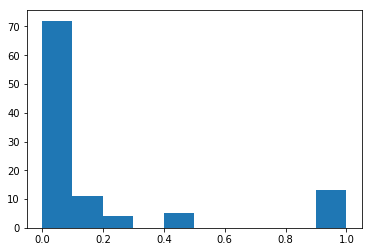

In [828]:
get_stats(df_new['bertb_ly_adv']) # a lot less top not than intensifiers 

correct target 0.1523809523809524
not top 0.01904761904761905
MRR 0.22317829871283143
median 0.03225806451612903


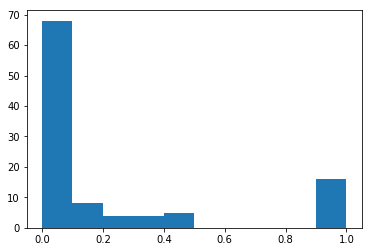

In [829]:
get_stats(df_new['bertl_ly_adv'])

correct target 0.39563106796116504
not top 0.01699029126213592
MRR 0.5372564124574373
median 0.5


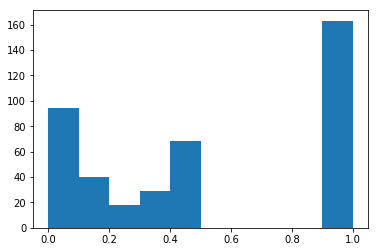

In [831]:
get_stats(df_new['bertb_not_ly_adv'])

correct target 0.470873786407767
not top 0.012135922330097087
MRR 0.5902013737072414
median 0.5


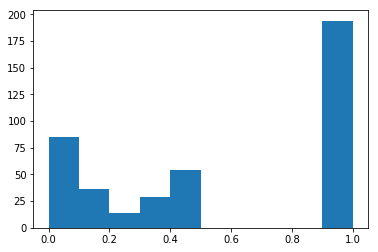

In [830]:
get_stats(df_new['bertl_not_ly_adv']) # gets correct target a LOT more and 'top not' a lot less

In [811]:
counter = 0
correct_counter = 0
not_counter = 0
MRR = []
for i in df_new['bertl_ly_adv']:
    if i != '':
        counter +=1
#         print(i[1])
        rank_adv = i[1][0]
        MRR.append(1/(1+ rank_adv))
        if i[1][0] == 0:
            correct_counter +=1
        if i[0][0] == 0:
            not_counter+=1
print(correct_counter/counter)
print(not_counter/counter) 
# print(MRR/counter)
# better than intensifiers: 0.15 vs 0.06 
# but that's also because the construction is less neutral?

0.1523809523809524
0.01904761904761905


0.03333333333333333


(array([72., 11.,  4.,  0.,  5.,  0.,  0.,  0.,  0., 13.]),
 array([6.11845326e-05, 1.00055066e-01, 2.00048948e-01, 3.00042829e-01,
        4.00036711e-01, 5.00030592e-01, 6.00024474e-01, 7.00018355e-01,
        8.00012237e-01, 9.00006118e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

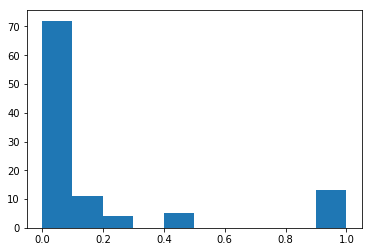

In [816]:
import matplotlib.pyplot as plt
import numpy as np
print(np.median(MRR))
plt.hist(MRR)

In [817]:
counter = 0
correct_counter = 0
not_counter = 0
MRR = 0
for i in df_new['bertb_not_ly_adv']:
    if i != '':
        counter +=1
#         print(i[1])
        rank_adv = i[1][0]
        MRR +=1/(1+ rank_adv)
        if i[1][0] == 0:
            correct_counter +=1
        if i[0][0] == 0:
            not_counter+=1
print(correct_counter/counter)
print(not_counter/counter) # better than intensifiers: 0.13 vs 0.05
print(MRR/counter)

0.39563106796116504
0.01699029126213592
0.5372564124574374


In [ ]:
counter = 0
correct_counter = 0
not_counter = 0
MRR = 0
for i in df_new['bertl_not_ly_adv']:
    if i != '':
        counter +=1
#         print(i[1])
        rank_adv = i[1][0]
        MRR +=1/(1+ rank_adv)
        if i[1][0] == 0:
            correct_counter +=1
        if i[0][0] == 0:
            not_counter+=1
print(correct_counter/counter)
print(not_counter/counter) # better than intensifiers: 0.13 vs 0.05
print(MRR/counter)

In [770]:
# import re
# adjectives = []
# for i in df_old['new_neutrals'].iloc[:40]:
#     adj = re.sub('\.', '', i.split()[-1])
#     adjectives.append(adj)
# len(adjectives)

In [836]:
# df_entail = pd.DataFrame()
# sent = []
# for a in temporal:
#     for a2 in temporal:
#         if a != a2:
#             for adj in adjectives:
#                 a = a.strip()
#                 a2 = a2.strip()
#                 s = f'If it is {a} {adj}, then it is {a2} {adj}'
#                 sent.append(s)

In [843]:
# sent_f = []
# for a in factual:
#     for a2 in factual:
#         if a != a2:
#             for adj in adjectives:
#                 a = a.strip()
#                 a2 = a2.strip()
#                 s = f'If it is {a} {adj}, then it is {a2} {adj}'
#                 sent_f.append(s)

In [844]:
# sent_o = []
# for a in other:
#     for a2 in other:
#         if a != a2:
#             for adj in adjectives:
#                 a = a.strip()
#                 a2 = a2.strip()
#                 s = f'If it is {a} {adj}, then it is {a2} {adj}'
#                 sent_o.append(s)

In [853]:
# df_entail_final['sentences'] = df_entail_final['sentences'].apply(lambda x: x +'.')

In [854]:
for i, s in df_entail_final['sentences'].iteritems():
    print(s)
# the issue is, when it's a downsizer they seem to not entail one another and be exclusive
# eg 'If it is very easy, then it is slightly easy.'
# 'If it is slightly easy, then it is very easy' (still worse...but)

If it is never able, then it is occasionally able.
If it is never bad, then it is occasionally bad.
If it is never big, then it is occasionally big.
If it is never black, then it is occasionally black.
If it is never clear, then it is occasionally clear.
If it is never different, then it is occasionally different.
If it is never early, then it is occasionally early.
If it is never easy, then it is occasionally easy.
If it is never economic, then it is occasionally economic.
If it is never federal, then it is occasionally federal.
If it is never free, then it is occasionally free.
If it is never full, then it is occasionally full.
If it is never good, then it is occasionally good.
If it is never hard, then it is occasionally hard.
If it is never high, then it is occasionally high.
If it is never human, then it is occasionally human.
If it is never important, then it is occasionally important.
If it is never international, then it is occasionally international.
If it is never large, then

If it is usually federal, then it is generally federal.
If it is usually free, then it is generally free.
If it is usually full, then it is generally full.
If it is usually good, then it is generally good.
If it is usually hard, then it is generally hard.
If it is usually high, then it is generally high.
If it is usually human, then it is generally human.
If it is usually important, then it is generally important.
If it is usually international, then it is generally international.
If it is usually large, then it is generally large.
If it is usually late, then it is generally late.
If it is usually little, then it is generally little.
If it is usually local, then it is generally local.
If it is usually low, then it is generally low.
If it is usually military, then it is generally military.
If it is usually national, then it is generally national.
If it is usually new, then it is generally new.
If it is usually old, then it is generally old.
If it is usually only, then it is generally on

If it is actually political, then it is maybe political.
If it is actually possible, then it is maybe possible.
If it is actually public, then it is maybe public.
If it is actually real, then it is maybe real.
If it is actually recent, then it is maybe recent.
If it is actually right, then it is maybe right.
If it is actually small, then it is maybe small.
If it is actually social, then it is maybe social.
If it is actually special, then it is maybe special.
If it is actually strong, then it is maybe strong.
If it is actually white, then it is maybe white.
If it is actually young, then it is maybe young.
If it is actually able, then it is perhaps able.
If it is actually bad, then it is perhaps bad.
If it is actually big, then it is perhaps big.
If it is actually black, then it is perhaps black.
If it is actually clear, then it is perhaps clear.
If it is actually different, then it is perhaps different.
If it is actually early, then it is perhaps early.
If it is actually easy, then it i

If it is slightly economic, then it is seriously economic.
If it is slightly federal, then it is seriously federal.
If it is slightly free, then it is seriously free.
If it is slightly full, then it is seriously full.
If it is slightly good, then it is seriously good.
If it is slightly hard, then it is seriously hard.
If it is slightly high, then it is seriously high.
If it is slightly human, then it is seriously human.
If it is slightly important, then it is seriously important.
If it is slightly international, then it is seriously international.
If it is slightly large, then it is seriously large.
If it is slightly late, then it is seriously late.
If it is slightly little, then it is seriously little.
If it is slightly local, then it is seriously local.
If it is slightly low, then it is seriously low.
If it is slightly military, then it is seriously military.
If it is slightly national, then it is seriously national.
If it is slightly new, then it is seriously new.
If it is slightly 

If it is quite easy, then it is hardly easy.
If it is quite economic, then it is hardly economic.
If it is quite federal, then it is hardly federal.
If it is quite free, then it is hardly free.
If it is quite full, then it is hardly full.
If it is quite good, then it is hardly good.
If it is quite hard, then it is hardly hard.
If it is quite high, then it is hardly high.
If it is quite human, then it is hardly human.
If it is quite important, then it is hardly important.
If it is quite international, then it is hardly international.
If it is quite large, then it is hardly large.
If it is quite late, then it is hardly late.
If it is quite little, then it is hardly little.
If it is quite local, then it is hardly local.
If it is quite low, then it is hardly low.
If it is quite military, then it is hardly military.
If it is quite national, then it is hardly national.
If it is quite new, then it is hardly new.
If it is quite old, then it is hardly old.
If it is quite only, then it is hardly

In [901]:
# df_entail_final.to_csv('/Users/isabellelorge/Desktop/entailment_task.csv')

In [1116]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

# model_name = 'bert-base-cased'
# model_name = 'bert-large-cased'
model_name = 'roberta-large'
model_torch_berta = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer_torch_berta = AutoTokenizer.from_pretrained(model_name)

def score(sentence, model, tokenizer):
    tensor_input = tokenizer.encode(sentence, return_tensors='pt')
    repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
    mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    with torch.inference_mode():
        loss = model(masked_input, labels=labels).loss
    return np.exp(loss.item())

# print(score(sentence='London is the capital of Great Britain.', model=model, tokenizer=tokenizer)) 
# # 4.541251105675365
# print(score(sentence='London is the capital of South America.', model=model, tokenizer=tokenizer)) 
# 6.162017238332462

In [866]:
# # need to exclude 'hardly' and 'never'though
# pairwise_rank = []
# for s in df_entail_final['sentences']:
#     adv1 = s.split()[3]
#     adv2 = s.split()[-2]
#     if adv1 == 'never':
#         adv1 = ' never'
#     if adv2 == 'never':
#         adv2 = ' never'
#     print(adv1, adv2)
#     for c in [temporal, factual, other]:
#         if adv1 and adv2 in c:
#             if c.index(adv1) > c.index(adv2):
#                 pairwise_rank.append(1)
#             else:
#                 pairwise_rank.append(0)
# df_entail_final['pairwise_rank'] = pairwise_rank

In [869]:
perplexities = []

for i, s in df_entail_final['sentences'].iteritems():
    print(i)
    perp = score(s, model_torch_berta, tokenizer_torch_berta)
    perplexities.append(perp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


In [895]:
# df_entail_final['roberta'] = perplexities

In [902]:
df_filt = df_entail_final[~df_entail_final['sentences'].str.contains('hardly| never')]

In [1153]:
df_filt

sentences  pairwise_rank  \
320   If it is occasionally able, then it is sometim...              0   
321   If it is occasionally bad, then it is sometime...              0   
322   If it is occasionally big, then it is sometime...              0   
323   If it is occasionally black, then it is someti...              0   
324   If it is occasionally clear, then it is someti...              0   
325   If it is occasionally different, then it is so...              0   
326   If it is occasionally early, then it is someti...              0   
327   If it is occasionally easy, then it is sometim...              0   
328   If it is occasionally economic, then it is som...              0   
329   If it is occasionally federal, then it is some...              0   
330   If it is occasionally free, then it is sometim...              0   
331   If it is occasionally full, then it is sometim...              0   
332   If it is occasionally good, then it is sometim...              0   
333   If it is occasionally hard, then it is sometim...              0   
334   If it is occasionally high, then it is sometim...              0   
335   If it is occasionally human, then it is someti...              0   
336   If it is occasionally important, then it is so...              0   
337   If it is occasionally international, then it i...              0   
338   If it is occasionally large, then it is someti...              0   
339   If it is occasionally late, then it is sometim...              0   
340   If it is occasionally little, then it is somet...              0   
341   If it is occasionally local, then it is someti...              0   
342   If it is occasionally low, then it is sometime...              0   
343   If it is occasionally military, then it is som...              0   
344   If it is occasionally national, then it is som...              0   
345   If it is occasionally new, then it is sometime...              0   
346   If it is occasionally old, then it is sometime...              0   
347   If it is occasionally only, then it is sometim...              0   
348   If it is occasionally political, then it is so...              0   
349   If it is occasionally possible, then it is som...              0   
...                                                 ...            ...   
6690    If it is completely free, then it is very free.              1   
6691    If it is completely full, then it is very full.              1   
6692    If it is completely good, then it is very good.              1   
6693    If it is completely hard, then it is very hard.              1   
6694    If it is completely high, then it is very high.              1   
6695  If it is completely human, then it is very human.              1   
6696  If it is completely important, then it is very...              1   
6697  If it is completely international, then it is ...              1   
6698  If it is completely large, then it is very large.              1   
6699    If it is completely late, then it is very late.              1   
6700  If it is completely little, then it is very li...              1   
6701  If it is completely local, then it is very local.              1   
6702      If it is completely low, then it is very low.              1   
6703  If it is completely military, then it is very ...              1   
6704  If it is completely national, then it is very ...              1   
6705      If it is completely new, then it is very new.              1   
6706      If it is completely old, then it is very old.              1   
6707    If it is completely only, then it is very only.              1   
6708  If it is completely political, then it is very...              1   
6709  If it is completely possible, then it is very ...              1   
6710  If it is completely public, then it is very pu...              1   
6711    If it is completely real, then it is very real.              1   
6712  If it is completely recent, then it is very 

In [957]:
true = 0
counter = 0
for adv in temporal[1:]:
    for adv2 in temporal[1:]:
        if adv != adv2:
            counter +=1
            if temporal.index(adv2) > temporal.index(adv):
                higher = adv2
                lower = adv
            else:
                higher = adv
                lower = adv2
            correct = df_filt['roberta'][df_filt['sentences'].str.contains(f'If it is {higher} .*, then it is {lower} .*')].mean()
            not_correct = df_filt['roberta'][df_filt['sentences'].str.contains(f'If it is {lower} .*, then it is {higher} .*')].mean()
                
            print(correct < not_correct, higher, lower, 'correct', correct, 'not_correct', not_correct)
            if correct < not_correct:
                true +=1
print(true/counter)

False sometimes occasionally correct 4.268347701580663 not_correct 3.9113802249102094
False often occasionally correct 5.2971358363731165 not_correct 4.015740371295593
False frequently occasionally correct 5.241949985445544 not_correct 3.6489984958272643
False generally occasionally correct 6.80641670519079 not_correct 4.9399599947546715
False usually occasionally correct 4.992928267881736 not_correct 4.193280104657284
False always occasionally correct 5.743041254163146 not_correct 2.7206288274457995
False sometimes occasionally correct 4.268347701580663 not_correct 3.9113802249102094
False often sometimes correct 4.179536004106754 not_correct 3.6203466552251187
False frequently sometimes correct 5.580851817086746 not_correct 4.390524479977614
False generally sometimes correct 6.285663194978346 not_correct 4.4715842387749785
False usually sometimes correct 4.053878375545478 not_correct 3.367198343823189
False always sometimes correct 4.5568322926286795 not_correct 1.9589196079523656
Fa

In [956]:
true = 0
counter = 0
for adv in factual:
    for adv2 in factual:
        if adv != adv2:
            counter +=1
            if factual.index(adv2) > factual.index(adv):
                higher = adv2
                lower = adv
            else:
                higher = adv
                lower = adv2
            correct = df_filt['roberta'][df_filt['sentences'].str.contains(f'If it is {higher} .*, then it is {lower} .*')].mean()
            not_correct = df_filt['roberta'][df_filt['sentences'].str.contains(f'If it is {lower} .*, then it is {higher} .*')].mean()
                
            print(correct < not_correct, higher, lower, 'correct', correct, 'not_correct', not_correct)
            if correct < not_correct:
                true +=1
print(true/counter)

False perhaps maybe correct 5.728019747070983 not_correct 5.307078450256613
False possibly maybe correct 4.539102549628649 not_correct 4.361129945796387
False probably maybe correct 4.080834488014832 not_correct 3.321363678541529
False actually maybe correct 6.951200063725684 not_correct 4.589171352958262
False really maybe correct 6.403234035822541 not_correct 4.802761083788688
False certainly maybe correct 6.6682905676334965 not_correct 6.239565971427862
False definitely maybe correct 5.0792089474836315 not_correct 2.7818512083108202
False perhaps maybe correct 5.728019747070983 not_correct 5.307078450256613
True possibly perhaps correct 5.382544391785784 not_correct 5.70161678548173
False probably perhaps correct 5.874729206062718 not_correct 4.878282096250632
False actually perhaps correct 9.79319576998751 not_correct 5.676286738557217
False really perhaps correct 9.784118105328517 not_correct 5.38940856176484
False certainly perhaps correct 6.719514245127994 not_correct 5.97170403

In [966]:
df_filt[df_filt['sentences'].str.contains('If it is definitely .*, then it is probably .*')].mean()

pairwise_rank    1.00000
roberta          4.53456
dtype: float64

In [967]:
df_filt[df_filt['sentences'].str.contains('If it is probably .*, then it is definitely .*')].mean()

pairwise_rank    0.00000
roberta          2.49874
dtype: float64

In [953]:
true = 0
counter = 0
for adv in other[1:]:
    for adv2 in other[1:]:
        if adv != adv2:
            counter +=1
            if other.index(adv2) > other.index(adv):
                higher = adv2
                lower = adv
            else:
                higher = adv
                lower = adv2
            correct = df_filt['roberta'][df_filt['sentences'].str.contains(f'If it is {higher} .*, then it is {lower} .*')].mean()
            not_correct = df_filt['roberta'][df_filt['sentences'].str.contains(f'If it is {lower} .*, then it is {higher} .*')].mean()
                
            print(correct < not_correct, higher, lower, 'correct', correct, 'not_correct', not_correct)
            if correct < not_correct:
                true +=1
print(true/counter)

False basically slightly correct 7.220870719080534 not_correct 6.0314936866125946
False pretty slightly correct 7.816192558651568 not_correct 5.495834823408465
False seriously slightly correct 9.588261926073805 not_correct 4.176344142136777
False quite slightly correct 6.421291534896755 not_correct 5.240842278998332
False very slightly correct 6.784683947536266 not_correct 3.6274549305139816
False completely slightly correct 6.766415830597971 not_correct 4.493604956597134
False basically slightly correct 7.220870719080534 not_correct 6.0314936866125946
True pretty basically correct 5.453585223631843 not_correct 5.934068733973599
False seriously basically correct 8.987236233707167 not_correct 6.680465273603713
True quite basically correct 7.016466238129991 not_correct 8.146149356025596
False very basically correct 6.330837722826137 not_correct 5.417596425636855
False completely basically correct 6.785232162350023 not_correct 4.9384939236855505
False pretty slightly correct 7.81619255865

In [ ]:
# the ranking isn't straightforward, there's a sense that they are sometimes mutually exclusive, like numbers
# eg 'If he has 3 apples, then he has 2 apples'

In [1003]:
test_sent = []

for i in range(1, 100):
    i2 = rng.integers(low=1, high=100, size=1)
    s = f'If he has {i} apples, then he has {i2[0]} apples'
    test_sent.append(s)

In [1020]:
test_sent2 = []

for i in range(1, 100):
    i2 = rng.integers(low=1, high=100, size=1)
    s = f'If he has {i} apples, then he has at least {i2[0]} apples'
    test_sent2.append(s)

In [1035]:
# perp_test = []

# for i, s in enumerate(test_sent2):
#     print(i)
#     perp = score(s, model, tokenizer)
#     perp_test.append(perp)

In [1023]:
# df_test = pd.DataFrame()
# df_test['sentences'] = test_sent
# df_test['perp'] = perp_test
df_test['sentences_least'] = test_sent2
df_test['perp_least'] = perp_test

In [1024]:
correct_least = []
for s in df_test['sentences_least']:
    digits = re.findall('\d+', s)
#     print(digits)
    if int(digits[0]) >= int(digits[1]):
#         print('YEE')
        correct_least.append(1)
    else:
        correct_least.append(0)

In [1025]:
df_test['correct_least'] = correct_least

In [1026]:
df_test

sentences      perp  correct  \
0     If he has 1 apples, then he has 4 apples  6.047688        0   
1    If he has 2 apples, then he has 43 apples  4.444711        0   
2    If he has 3 apples, then he has 23 apples  3.458963        0   
3     If he has 4 apples, then he has 8 apples  2.358164        0   
4     If he has 5 apples, then he has 2 apples  3.622879        1   
5    If he has 6 apples, then he has 78 apples  4.368420        0   
6    If he has 7 apples, then he has 49 apples  4.563680        0   
7    If he has 8 apples, then he has 42 apples  3.488882        0   
8    If he has 9 apples, then he has 90 apples  3.506954        0   
9   If he has 10 apples, then he has 76 apples  4.550522        0   
10  If he has 11 apples, then he has 90 apples  4.368427        0   
11  If he has 12 apples, then he has 12 apples  1.878567        1   
12  If he has 13 apples, then he has 93 apples  4.946647        0   
13  If he has 14 apples, then he has 26 apples  3.634055        0   
14  If he has 15 apples, then he has 87 apples  4.337179        0   
15  If he has 16 apples, then he has 19 apples  2.745133        0   
16  If he has 17 apples, then he has 44 apples  4.482721        0   
17   If he has 18 apples, then he has 9 apples  4.510562        1   
18  If he has 19 apples, then he has 98 apples  4.465705        0   
19  If he has 20 apples, then he has 93 apples  4.858321        0   
20  If he has 21 apples, then he has 90 apples  4.660989        0   
21  If he has 22 apples, then he has 55 apples  3.994788        0   
22   If he has 23 apples, then he has 3 apples  5.772420        1   
23  If he has 24 apples, then he has 35 apples  3.525924        0   
24  If he has 25 apples, then he has 91 apples  5.059931        0   
25  If he has 26 apples, then he has 56 apples  3.582485        0   
26  If he has 27 apples, then he has 34 apples  3.315781        0   
27  If he has 28 apples, then he has 84 apples  4.035988        0   
28  If he has 29 apples, then he has 80 apples  5.149317        0   
29  If he has 30 apples, then he has 69 apples  3.766671        0   
..                                         ...       ...      ...   
69  If he has 70 apples, then he has 78 apples  3.558111        0   
70  If he has 71 apples, then he has 45 apples  6.792123        1   
71   If he has 72 apples, then he has 5 apples  7.440904        1   
72  If he has 73 apples, then he has 34 apples  6.977658        1   
73  If he has 74 apples, then he has 38 apples  6.785042        1   
74  If he has 75 apples, then he has 97 apples  3.822447        0   
75  If he has 76 apples, then he has 98 apples  4.235282        0   
76  If he has 77 apples, then he has 78 apples  2.274686        0   
77  If he has 78 apples, then he has 45 apples  7.060446        1   
78  If he has 79 apples, then he has 36 apples  7.766490        1   
79  If he has 80 apples, then he has 84 apples  2.921157        0   
80  If he has 81 apples, then he has 65 apples  6.204503        1   
81  If he has 82 apples, then he has 11 apples  5.908291        1   
82  If he has 83 apples, then he has 35 apples  7.251292        1   
83  If he has 84 apples, then he has 46 apples  8.004092        1   
84  If he has 85 apples, then he has 84 apples  2.756630        1   
85  If he has 86 apples, then he has 64 apples  6.191182        1   
86  If he has 87 apples, then he has 27 apples  5.666663        1   
87   If he has 88 apples, then he has 9 apples  5.629742        1   
88  If he has 89 apples, then he has 33 apples  7.799808        1   
89   If he has 90 apples, then he has 2 apples  6.504698        1   
90  If he has 91 apples, then he has 68 apples  7.344554        1   
91   If he has 92 apples, then he has 8 apples  7.742090        1   
92  If he has 93 apples, then he has 28 apples  8.349663        1   
93  If he has 94 apples, then he has 16 apples  8.050741        1   
94   If he has 95 apples, then he has 4 apples  8.225401        1   
95  If he has 96 apples, then he ha

In [1031]:
df_test['perp'][df_test['correct'] == 1].mean()

6.184609205374126

In [1032]:
df_test['perp'][df_test['correct'] == 0].mean()

4.079074634509728

In [1033]:
df_test['perp_least'][df_test['correct_least'] == 1].mean()

3.5071594916674442

In [1034]:
df_test['perp_least'][df_test['correct_least'] == 0 ].mean()

3.1886305097015293

In [1108]:
from nltk.corpus import wordnet as wn

correct_hyp = set()
incorrect_hyp = set()

for s in df_new['sentences']:
    doc = nlp(s)
#     print(s)
    nouns = [token.lemma_ for token in doc if token.pos_ == 'NOUN']
    for n in nouns:
#         print(n)
        ns = [ss for ss in wn.synsets(n) if ss.pos() == 'n']
        if ns != []:
            n1 = [ss for ss in wn.synsets(n) if ss.pos() == 'n'][0]
            if n1.hypernyms() != [] and n1.hyponyms() != []:
                hypernym = n1.hypernyms()[0]
                hypernym = re.sub('\..\..*\d\d', '', hypernym.name()).split('_')
                hypernym = ' '.join(hypernym)
                hyponym = n1.hyponyms()[0]
                hyponym = re.sub('\..\..*\d\d', '', hyponym.name()).split('_')
                hyponym = ' '.join(hyponym)
                art1 = art2 = art3 = 'a'
                if n[0] in ['a', 'e', 'i', 'o', 'u']:
                    art1 = 'an'
                if hypernym[0] in ['a', 'e', 'i', 'o', 'u']:
                    art2 = 'an'
                if hyponym[0] in ['a', 'e', 'i', 'o', 'u']:
                    art3 = 'an'
                hyper = f'If it is {art2} {hypernym}, then it is {art1} {n}'
                hypo = f'If it is {art3} {hyponym}, then it is {art1} {n}'
                hyper2 = f'If it is {art1} {n}, then it is {art2} {hypernym}'
                hypo2 = f'If it is {art1} {n}, then it is {art3} {hyponym}'
                print(hyper)
                print(hypo)
                correct_hyp.add(hypo)
                correct_hyp.add(hyper2)
                incorrect_hyp.add(hyper)
                incorrect_hyp.add(hypo2)
#         for ss in wn.synsets(n):
#             if ss.pos() == 'n':
#                 print(n, ss.hypernyms(), ss.hyponyms())
#     print([token.lemma_ for token in doc if token.pos_ == 'NOUN'])

If it is a body of water, then it is an ocean
If it is a deep, then it is an ocean
If it is a timepiece, then it is a clock
If it is an alarm clock, then it is a clock
If it is a time unit, then it is a day
If it is a date, then it is a day
If it is a mishap, then it is an accident
If it is a collision, then it is an accident
If it is a plan of action, then it is a policy
If it is an activism, then it is a policy
If it is a difference, then it is an inequality
If it is a disparity, then it is an inequality
If it is an evidence, then it is an argument
If it is an adducing, then it is an argument
If it is an information, then it is an evidence
If it is a disproof, then it is an evidence
If it is a manner of speaking, then it is a tone
If it is a note, then it is a tone
If it is a statement, then it is a comment
If it is an ad-lib, then it is a comment
If it is an administrative district, then it is a province
If it is an american state, then it is a province
If it is a body, then it is a

If it is a medium of exchange, then it is a currency
If it is a cash, then it is a currency
If it is a control, then it is an authority
If it is a carte blanche, then it is an authority
If it is an economic process, then it is an inflation
If it is a cost-pull inflation, then it is an inflation
If it is a group, then it is a people
If it is an age group, then it is a people
If it is a juvenile, then it is a kid
If it is a bairn, then it is a kid
If it is a vehicle, then it is a rocket
If it is a missile, then it is a rocket
If it is an armament, then it is a launcher
If it is a bazooka, then it is a launcher
If it is a large indefinite quantity, then it is a lot
If it is a flood, then it is a lot
If it is a group, then it is a people
If it is an age group, then it is a people
If it is a content, then it is an idea
If it is a burden, then it is an idea
If it is an enlisted person, then it is a soldier
If it is an anzac, then it is a soldier
If it is a group, then it is a people
If it is

If it is a state, then it is a superpower
If it is a hegemon, then it is a superpower
If it is a consciousness, then it is a self
If it is an anima, then it is a self
If it is a natural object, then it is a world
If it is a closed universe, then it is a world
If it is a force, then it is a police
If it is an europol, then it is a police
If it is an activity, then it is a job
If it is an accountancy, then it is a job
If it is a professional, then it is a lawyer
If it is an advocate, then it is a lawyer
If it is a social control, then it is a management
If it is an administration, then it is a management
If it is a kind, then it is a type
If it is a breed, then it is a type
If it is a message, then it is a subject
If it is a bone of contention, then it is a subject
If it is an educator, then it is an academic
If it is a professor, then it is an academic
If it is a linguistic process, then it is a reading
If it is a browse, then it is a reading
If it is a point, then it is a source
If it 

If it is a category, then it is a kind
If it is an antitype, then it is a kind
If it is an explanation, then it is a definition
If it is a contextual definition, then it is a definition
If it is a kind, then it is a type
If it is a breed, then it is a type
If it is a happening, then it is a case
If it is a humiliation, then it is a case
If it is a device, then it is a key
If it is an ignition key, then it is a key
If it is an unit, then it is a family
If it is a broken home, then it is a family
If it is a room, then it is a classroom
If it is a home room, then it is a classroom
If it is a room, then it is a classroom
If it is a home room, then it is a classroom
If it is an unit, then it is a household
If it is a broken home, then it is a household
If it is a domestic partner, then it is a partner
If it is a bigamist, then it is a partner
If it is a collection, then it is a law
If it is an administrative law, then it is a law
If it is a business, then it is a firm
If it is an accounting

If it is a component, then it is a point
If it is an attractor, then it is a point
If it is an information, then it is a news
If it is a good word, then it is a news
If it is a nonfiction, then it is an article
If it is a column, then it is an article
If it is a print media, then it is a journalism
If it is a fleet street, then it is a journalism
If it is a belief, then it is an expectation
If it is an anticipation, then it is an expectation
If it is a value, then it is a price
If it is an assessment, then it is a price
If it is a vehicle, then it is a rocket
If it is a missile, then it is a rocket
If it is a property, then it is a degree
If it is an amplitude level, then it is a degree
If it is a part, then it is a rest
If it is a leftover, then it is a rest
If it is a position, then it is a post
If it is a bridgehead, then it is a post
If it is an institution, then it is a company
If it is a broadcasting company, then it is a company
If it is an animal, then it is a male
If it is a b

If it is a businessman, then it is an owner
If it is a bookseller, then it is an owner
If it is a rational motive, then it is an incentive
If it is a moral force, then it is an incentive
If it is a worker, then it is an employee
If it is a bartender, then it is an employee
If it is an awareness, then it is a sense
If it is a sense of direction, then it is a sense
If it is a part, then it is a piece
If it is a beam, then it is a piece
If it is a pastry, then it is a pie
If it is an apple pie, then it is a pie
If it is a consciousness, then it is a self
If it is an anima, then it is a self
If it is a curiosity, then it is an interest
If it is a concern, then it is an interest
If it is a pastry, then it is a pie
If it is an apple pie, then it is a pie
If it is an evidence, then it is an argument
If it is an adducing, then it is an argument
If it is a payment, then it is a benefit
If it is a cost-of-living benefit, then it is a benefit
If it is a value, then it is a price
If it is an asses

If it is a quality, then it is a difference
If it is a differentia, then it is a difference
If it is an artifact, then it is a toy
If it is a ball, then it is a toy
If it is an artifact, then it is a toy
If it is a ball, then it is a toy
If it is a quality, then it is a difference
If it is a differentia, then it is a difference
If it is a kind, then it is a type
If it is a breed, then it is a type
If it is a substance, then it is a stuff
If it is an abrasive, then it is a stuff
If it is a juvenile, then it is a child
If it is a bairn, then it is a child
If it is a rima, then it is a mouth
If it is a trap, then it is a mouth
If it is an instrumentality, then it is a medium
If it is an album, then it is a medium
If it is a large indefinite quantity, then it is a lot
If it is a flood, then it is a lot
If it is an activity, then it is a job
If it is an accountancy, then it is a job
If it is a need, then it is a necessity
If it is a requisiteness, then it is a necessity
If it is an instrume

If it is a region, then it is a side
If it is a bedside, then it is a side
If it is a scientific research, then it is an experiment
If it is a control experiment, then it is an experiment
If it is an activity, then it is a market
If it is a black market, then it is a market
If it is a state, then it is a situation
If it is an absurd, then it is a situation
If it is a juvenile, then it is a kid
If it is a bairn, then it is a kid
If it is an educational institution, then it is a school
If it is an academy, then it is a school
If it is a juvenile, then it is a kid
If it is a bairn, then it is a kid
If it is a locomotion, then it is a walk
If it is an ambulation, then it is a walk
If it is a being, then it is a life
If it is a ghetto, then it is a life
If it is a time unit, then it is a day
If it is a date, then it is a day
If it is a medical science, then it is a medicine
If it is an allergology, then it is a medicine
If it is a device, then it is a fan
If it is an electric fan, then it i

If it is a propulsion, then it is a drive
If it is a firewall, then it is a drive
If it is a marketplace, then it is a grocery
If it is a greengrocery, then it is a grocery
If it is a mercantile establishment, then it is a store
If it is a bakery, then it is a store
If it is an imperfection, then it is a flaw
If it is a blister, then it is a flaw
If it is a philosophy, then it is a logic
If it is a modal logic, then it is a logic
If it is a rational motive, then it is an incentive
If it is a moral force, then it is an incentive
If it is a consortium, then it is a cartel
If it is a drug cartel, then it is a cartel
If it is an act, then it is an action
If it is an accomplishment, then it is an action
If it is a quality, then it is a morality
If it is a conscience, then it is a morality
If it is a felony, then it is a theft
If it is a biopiracy, then it is a theft
If it is a quality, then it is a morality
If it is a conscience, then it is a morality
If it is a quality, then it is a morali

If it is an action, then it is an operation
If it is a commission, then it is an operation
If it is an investigation, then it is an analysis
If it is an anatomy, then it is an analysis
If it is a contestant, then it is a player
If it is a ballplayer, then it is a player
If it is a liking, then it is a preference
If it is an acquired taste, then it is a preference
If it is an amount, then it is a number
If it is a fewness, then it is a number
If it is a gathering, then it is a community
If it is an aleut, then it is a community
If it is a component, then it is a point
If it is an attractor, then it is a point
If it is an electronic communication, then it is an email
If it is a freemail, then it is an email
If it is a code, then it is an address
If it is an argument, then it is an address
If it is a record, then it is an account
If it is an ancient history, then it is an account
If it is an electronic communication, then it is an email
If it is a freemail, then it is an email
If it is a 

If it is a sexual activity, then it is a homosexuality
If it is an inversion, then it is a homosexuality
If it is a property, then it is a way
If it is an artistic style, then it is a way
If it is an instrumentality, then it is a system
If it is an audio system, then it is a system
If it is a happening, then it is a change
If it is an acceleration, then it is a change
If it is a kindness, then it is a favor
If it is a turn, then it is a favor
If it is a digit, then it is an one
If it is a monad, then it is an one
If it is an unit, then it is a household
If it is a broken home, then it is a household
If it is a levy, then it is a tax
If it is a capital gains tax, then it is a tax
If it is an approval, then it is a credit
If it is a memorial, then it is a credit
If it is an assertion, then it is a claim
If it is a cause of action, then it is a claim
If it is an administrative district, then it is a state
If it is an american state, then it is a state
If it is a worker, then it is an empl

If it is a language unit, then it is a word
If it is an anagram, then it is a word
If it is a social control, then it is a responsibility
If it is a burden of proof, then it is a responsibility
If it is a firm, then it is a corporation
If it is a boy scouts of america, then it is a corporation
If it is a counterintelligence, then it is a censorship
If it is a military censorship, then it is a censorship
If it is a cut, then it is a steak
If it is a beefsteak, then it is a steak
If it is a counterintelligence, then it is a censorship
If it is a military censorship, then it is a censorship
If it is a bedclothes, then it is a blanket
If it is an afghan, then it is a blanket
If it is a word, then it is a term
If it is a referent, then it is a term
If it is a punctuation, then it is a quote
If it is a double quotes, then it is a quote
If it is a digit, then it is an one
If it is a monad, then it is an one
If it is a weapon, then it is a gun
If it is an air gun, then it is a gun
If it is a h

If it is an aid, then it is a welfare
If it is a dole, then it is a welfare
If it is an outgo, then it is a cost
If it is a borrowing cost, then it is a cost
If it is an economic process, then it is an inflation
If it is a cost-pull inflation, then it is an inflation
If it is a property, then it is a way
If it is an artistic style, then it is a way
If it is a paste-up, then it is a montage
If it is a photomontage, then it is a montage
If it is a representation, then it is an image
If it is an auditory image, then it is an image
If it is a relation, then it is a part
If it is a basis, then it is a part
If it is an assistant, then it is a subordinate
If it is an associate, then it is a subordinate
If it is a military officer, then it is a commander
If it is a commander in chief, then it is a commander
If it is a knowledge domain, then it is a discipline
If it is an allometry, then it is a discipline
If it is a scholar, then it is a historian
If it is an annalist, then it is a historian
I

If it is a political unit, then it is a country
If it is an ally, then it is a country
If it is a body of water, then it is a sea
If it is a south sea, then it is a sea
If it is a property, then it is a level
If it is an amplitude level, then it is a level
If it is a time period, then it is a year
If it is an annum, then it is a year
If it is a group, then it is a people
If it is an age group, then it is a people
If it is a vote, then it is an election
If it is a by-election, then it is an election
If it is a politician, then it is a candidate
If it is a dark horse, then it is a candidate
If it is an assets, then it is a share
If it is an allotment, then it is a share
If it is an orientation, then it is a view
If it is a bird's eye view, then it is a view
If it is a social group, then it is a society
If it is a civilization, then it is a society
If it is a generalization, then it is a principle
If it is a feng shui, then it is a principle
If it is an average, then it is a mean
If it is

If it is a communicator, then it is an author
If it is an abstractor, then it is an author
If it is a nonfiction, then it is an article
If it is a column, then it is an article
If it is a statement, then it is a comment
If it is an ad-lib, then it is a comment
If it is a nonfiction, then it is an article
If it is a column, then it is an article
If it is a heading, then it is a headline
If it is a dropline, then it is a headline
If it is a facility, then it is a station
If it is a broadcasting station, then it is a station
If it is a psychological feature, then it is a knowledge
If it is an ability, then it is a knowledge
If it is a subjugation, then it is a slavery
If it is a bonded labor, then it is a slavery
If it is a time period, then it is a century
If it is a quattrocento, then it is a century
If it is a word, then it is a form
If it is an abbreviation, then it is a form
If it is a subjugation, then it is a slavery
If it is a bonded labor, then it is a slavery
If it is a collecti

If it is a duty, then it is a role
If it is a capacity, then it is a role
If it is a polity, then it is a government
If it is an ancien regime, then it is a government
If it is an imperfection, then it is a flaw
If it is a blister, then it is a flaw
If it is a quality, then it is a power
If it is a control, then it is a power
If it is a category, then it is a kind
If it is an antitype, then it is a kind
If it is an elite, then it is an aristocracy
If it is a baronetage, then it is an aristocracy
If it is an autocracy, then it is a stalinism
If it is a police state, then it is a stalinism
If it is a part, then it is an element
If it is a be-all and end-all, then it is an element
If it is a statement, then it is an explanation
If it is an accounting, then it is an explanation
If it is an ability, then it is an intelligence
If it is an acuteness, then it is an intelligence
If it is a need, then it is a lack
If it is an absence, then it is a lack
If it is a photographic equipment, then it 

If it is an election, then it is a primary
If it is a direct primary, then it is a primary
If it is a consequence, then it is a response
If it is a reaction, then it is a response
If it is a position, then it is a post
If it is a bridgehead, then it is a post
If it is an evidence, then it is an argument
If it is an adducing, then it is an argument
If it is a social group, then it is a society
If it is a civilization, then it is a society
If it is a discussion, then it is a negotiation
If it is a bargaining, then it is a negotiation
If it is a quality, then it is a power
If it is a control, then it is a power
If it is an influence, then it is a force
If it is a duress, then it is a force
If it is a region, then it is an area
If it is an anchorage, then it is an area
If it is an operation, then it is an attack
If it is a banzai attack, then it is an attack
If it is a time unit, then it is a day
If it is a date, then it is a day
If it is a cooking utensil, then it is a pot
If it is a cald

If it is a process, then it is an evolution
If it is an assibilation, then it is an evolution
If it is a person, then it is a gay
If it is a gay man, then it is a gay
If it is an organism, then it is an animal
If it is an acrodont, then it is an animal
If it is a teaching, then it is a lesson
If it is a dance lesson, then it is a lesson
If it is an information, then it is a fact
If it is a case, then it is a fact
If it is a socialism, then it is a communism
If it is a bolshevism, then it is a communism
If it is a word, then it is a form
If it is an abbreviation, then it is a form
If it is a social group, then it is a society
If it is a civilization, then it is a society
If it is a component, then it is a point
If it is an attractor, then it is a point
If it is an abstraction, then it is a relation
If it is an affinity, then it is a relation
If it is a sequence, then it is a gene
If it is an allele, then it is a gene
If it is a bodily process, then it is a sex
If it is an autoeroticism,

If it is a region, then it is an area
If it is an anchorage, then it is an area
If it is a content, then it is an idea
If it is a burden, then it is an idea
If it is a municipality, then it is a city
If it is a national capital, then it is a city
If it is an adult, then it is a man
If it is an adonis, then it is a man
If it is a transferred property, then it is a loss
If it is a financial loss, then it is a loss
If it is an experience, then it is a reality
If it is a real world, then it is a reality
If it is a time period, then it is a duration
If it is a clocking, then it is a duration
If it is a time period, then it is a month
If it is a date, then it is a month
If it is a capitalist, then it is an investor
If it is a bear, then it is an investor
If it is a finance, then it is an investment
If it is an arbitrage, then it is an investment
If it is an information, then it is a fact
If it is a case, then it is a fact
If it is an examination, then it is a study
If it is a resurvey, then 

If it is a communicator, then it is an author
If it is an abstractor, then it is an author
If it is a political orientation, then it is a liberalism
If it is a neoliberalism, then it is a liberalism
If it is an idea, then it is a concept
If it is an abstraction, then it is a concept
If it is a way, then it is a road
If it is an access road, then it is a road
If it is a formation, then it is a line
If it is a chorus, then it is a line
If it is a military action, then it is a defense
If it is an air defense, then it is a defense
If it is an extremity, then it is an end
If it is a bitter end, then it is an end
If it is an extremity, then it is an end
If it is a bitter end, then it is an end
If it is a representation, then it is a picture
If it is a bitmap, then it is a picture
If it is a part, then it is a rest
If it is a leftover, then it is a rest
If it is an educational institution, then it is a school
If it is an academy, then it is a school
If it is a large indefinite quantity, then 

If it is a metallic element, then it is an uranium
If it is an uranium 235, then it is an uranium
If it is a production, then it is a mining
If it is a placer mining, then it is a mining
If it is an animal, then it is a male
If it is a bullock, then it is a male
If it is a computer user, then it is a programmer
If it is a cracker, then it is a programmer
If it is a footwear, then it is a boot
If it is a buskin, then it is a boot
If it is a field game, then it is a hockey
If it is a shinny, then it is a hockey
If it is a woman, then it is a girl
If it is a baby, then it is a girl
If it is a man, then it is a guy
If it is a sod, then it is a guy
If it is a force, then it is a military
If it is a military reserve, then it is a military
If it is a conflict, then it is a fighting
If it is an affray, then it is a fighting
If it is a state, then it is a freedom
If it is an academic freedom, then it is a freedom
If it is a paper, then it is a card
If it is a playing card, then it is a card
If 

If it is a large integer, then it is a dozen
If it is a boxcars, then it is a dozen
If it is a point, then it is a position
If it is an anomaly, then it is a position
If it is a concern, then it is a matter
If it is a least, then it is a matter
If it is a content, then it is an idea
If it is a burden, then it is an idea
If it is a choice, then it is a decision
If it is an appointment, then it is a decision
If it is a rubbish, then it is a debris
If it is a slack, then it is a debris
If it is a component, then it is a point
If it is an attractor, then it is a point
If it is an evidence, then it is an argument
If it is an adducing, then it is an argument
If it is a visitor, then it is a guest
If it is a guest of honor, then it is a guest
If it is a communication, then it is a discussion
If it is a consideration, then it is a discussion
If it is a polity, then it is a government
If it is an ancien regime, then it is a government
If it is a race, then it is a campaign
If it is a governor's

In [1109]:
df_hyp = pd.DataFrame()
df_hyp['sentences'] = list(correct_hyp) + list(incorrect_hyp)

In [1110]:
df_hyp

sentences
0            If it is a ceiling, then it is an altitude
1           If it is an operator, then it is a function
2               If it is a waving, then it is a gesture
3       If it is an intelligence, then it is an ability
4        If it is an agent, then it is a representative
5                    If it is a type, then it is a kind
6             If it is a mine, then it is an excavation
7       If it is an anechoic chamber, then it is a room
8             If it is a hush money, then it is a bribe
9       If it is a spokesperson, then it is an advocate
10      If it is a consequence, then it is a phenomenon
11      If it is a dress, then it is a woman's clothing
12           If it is a view, then it is an orientation
13               If it is a lynch mob, then it is a mob
14                If it is an a-list, then it is a list
15     If it is a fleet street, then it is a journalism
16             If it is a proof, then it is an evidence
17         If it is a standpoint, then it is a position
18    If it is a roof, then it is a protective covering
19        If it is a contrivance, then it is a strategy
20        If it is an accretion, then it is an increase
21             If it is a statistic, then it is a datum
22                If it is a finger, then it is a digit
23            If it is a montage, then it is a paste-up
24          If it is an insult, then it is a disrespect
25      If it is an airmail letter, then it is a letter
26        If it is a can of worms, then it is a trouble
27             If it is a sit-down, then it is a strike
28               If it is a public, then it is a people
29            If it is a cold spell, then it is a while
...                                                 ...
3814    If it is a theatre, then it is an arena theater
3815     If it is a firm, then it is an accounting firm
3816         If it is a wealth, then it is an affluence
3817  If it is a spending, then it is a deficit spen...
3818             If it is a people, then it is a public
3819           If it is a sr, then it is a strontium 90
3820           If it is a run, then it is an earned run
3821    If it is an appointment, then it is a co-option
3822                If it is a son, then it is a junior
3823             If it is a time unit, then it is a day
3824          If it is a person, then it is an engineer
3825      If it is an opinion, then it is a speculation
3826            If it is a scene, then it is a darkness
3827             If it is an escort, then it is a guide
3828  If it is a deformity, then it is an arnold-chi...
3829  If it is a heavier-than-air craft, then it is ...
3830         If it is a liking, then it is a preference
3831   If it is a definite quantity, then it is an unit
3832              If it is a meal, then it is a banquet
3833  If it is an interpretation, then it is a clari...
3834  If it is a chemical process, then it is a reac...
3835  If it is a social scientist, then it is an eco...
3836           If it is a timepiece, then it is a clock
3837            If it is a head, then it is a secretary
3838  If it is a blame, then it is a self-incrimination
3839       If it is a loyalty, then it is an allegiance
3840  If it is a causal agent, then it is an individual
3841        If it is a criticism, then it is a critique
3842   If it is a planet, then it is an inferior planet
3843  If it is a place of business, then it is an of...

[3844 rows x 1 columns]

In [1146]:
df_entail_final

sentences  pairwise_rank  \
0     If it is never able, then it is occasionally a...              0   
1      If it is never bad, then it is occasionally bad.              0   
2      If it is never big, then it is occasionally big.              0   
3     If it is never black, then it is occasionally ...              0   
4     If it is never clear, then it is occasionally ...              0   
5     If it is never different, then it is occasiona...              0   
6     If it is never early, then it is occasionally ...              0   
7     If it is never easy, then it is occasionally e...              0   
8     If it is never economic, then it is occasional...              0   
9     If it is never federal, then it is occasionall...              0   
10    If it is never free, then it is occasionally f...              0   
11    If it is never full, then it is occasionally f...              0   
12    If it is never good, then it is occasionally g...              0   
13    If it is never hard, then it is occasionally h...              0   
14    If it is never high, then it is occasionally h...              0   
15    If it is never human, then it is occasionally ...              0   
16    If it is never important, then it is occasiona...              0   
17    If it is never international, then it is occas...              0   
18    If it is never large, then it is occasionally ...              0   
19    If it is never late, then it is occasionally l...              0   
20    If it is never little, then it is occasionally...              0   
21    If it is never local, then it is occasionally ...              0   
22     If it is never low, then it is occasionally low.              0   
23    If it is never military, then it is occasional...              0   
24    If it is never national, then it is occasional...              0   
25     If it is never new, then it is occasionally new.              0   
26     If it is never old, then it is occasionally old.              0   
27    If it is never only, then it is occasionally o...              0   
28    If it is never political, then it is occasiona...              0   
29    If it is never possible, then it is occasional...              0   
...                                                 ...            ...   
6690    If it is completely free, then it is very free.              1   
6691    If it is completely full, then it is very full.              1   
6692    If it is completely good, then it is very good.              1   
6693    If it is completely hard, then it is very hard.              1   
6694    If it is completely high, then it is very high.              1   
6695  If it is completely human, then it is very human.              1   
6696  If it is completely important, then it is very...              1   
6697  If it is completely international, then it is ...              1   
6698  If it is completely large, then it is very large.              1   
6699    If it is completely late, then it is very late.              1   
6700  If it is completely little, then it is very li...              1   
6701  If it is completely local, then it is very local.              1   
6702      If it is completely low, then it is very low.              1   
6703  If it is completely military, then it is very ...              1   
6704  If it is completely national, then it is very ...              1   
6705      If it is completely new, then it is very new.              1   
6706      If it is completely old, then it is very old.              1   
6707    If it is completely only, then it is very only.              1   
6708  If it is completely political, then it is very...              1   
6709  If it is completely possible, then it is very ...              1   
6710  If it is completely public, then it is very pu...              1   
6711    If it is completely real, then it is very real.              1   
6712  If it is completely recent, then it is very 

In [ ]:
# to avoid only frequent words
# but need to check they are in BERT's voc! / Roberta's voc

In [1117]:
perp_hyp = []
# model = model_berta
# tokenizer = tokenizer_berta

for i, s in df_hyp['sentences'].iteritems():
    print(i)
    perp = score(s, model_torch_berta, tokenizer_torch_berta)
    perp_hyp.append(perp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [1118]:
df_hyp['roberta'] = perp_hyp

In [1126]:
# correct = []
# for s in df_hyp['sentences']:
#     if s in correct_hyp:
#         correct.append(1)
#     if s in incorrect_hyp:
#         correct.append(0)
# df_hyp['correct'] = correct

In [1130]:
df_hyp['roberta'][df_hyp['correct'] == 1].mean()

4.47070232140718

In [1131]:
df_hyp['roberta'][df_hyp['correct'] == 0].mean()

4.7410431346371045

In [1142]:
for s in df_hyp['sentences']:
    t2 = s.split()[-1]
    t1 = s.split()[4]
    df_t = df_hyp[df_hyp['sentences'].str.contains(f' {t2} .* {t1}| {t1} .* {t2}')]
    if len(df_t) == 2 and set(df_t['sentences'].iloc[0].split()) == set(df_t['sentences'].iloc[1].split()):
        print(df_t)

                                          sentences   roberta  correct
0        If it is a ceiling, then it is an altitude  3.980820        1
1769  If it is an altitude, then it is an elevation  1.741365        1
2289     If it is an altitude, then it is a ceiling  3.982729        0
2842  If it is an elevation, then it is an altitude  1.615908        0
                                              sentences   roberta  correct
1           If it is an operator, then it is a function  1.647181        1
528   If it is a function, then it is a mathematical...  3.023533        1
1663       If it is an expansion, then it is a function  5.052512        1
3079        If it is a function, then it is an operator  1.717378        0
3497       If it is a function, then it is an expansion  3.962507        0
3761  If it is a mathematical relation, then it is a...  3.516320        0
                                    sentences   roberta  correct
2     If it is a waving, then it is a gesture  7.385362

                                  sentences    roberta  correct
22    If it is a finger, then it is a digit   3.469935        1
1021    If it is an one, then it is a digit   8.461972        1
3131    If it is a digit, then it is an one  10.386717        0
3669  If it is a digit, then it is a finger   4.199154        0
                                      sentences   roberta  correct
23    If it is a montage, then it is a paste-up  1.843181        1
2188  If it is a paste-up, then it is a montage  2.028763        0
                                        sentences   roberta  correct
24    If it is an insult, then it is a disrespect  2.205515        1
3095  If it is a disrespect, then it is an insult  2.449810        0
                                            sentences   roberta  correct
25    If it is an airmail letter, then it is a letter  1.582600        1
799          If it is a letter, then it is a document  2.864160        1
2699  If it is a letter, then it is an airmail letter

                                        sentences   roberta  correct
45    If it is a specialist, then it is an expert  1.960531        1
881         If it is an ace, then it is an expert  5.746483        1
1393    If it is an analyst, then it is an expert  2.754353        1
1587      If it is an expert, then it is a person  3.956841        1
2266  If it is an expert, then it is a specialist  1.869989        0
2644        If it is an expert, then it is an ace  5.808936        0
2882      If it is a person, then it is an expert  3.915106        0
2948    If it is an expert, then it is an analyst  2.828332        0
                                           sentences    roberta  correct
46         If it is a bath water, then it is a water   4.660050        1
135   If it is a water, then it is a binary compound  24.890694        1
352      If it is a lake, then it is a body of water   1.164268        1
673       If it is a sea, then it is a body of water   1.756817        1
721    If it i

                                              sentences    roberta  correct
69    If it is a knowledge, then it is a psychologic...  13.027290        1
484   If it is an event, then it is a psychological ...   7.403467        1
532            If it is an aspect, then it is a feature   2.312463        1
1347          If it is a feature, then it is a property   2.758645        1
1542  If it is a motivation, then it is a psychologi...   6.891186        1
2237  If it is a psychological feature, then it is a...   7.368783        0
2478  If it is a psychological feature, then it is a...  10.232173        0
2520           If it is a feature, then it is an aspect   2.465636        0
2849  If it is a psychological feature, then it is a...   6.794207        0
3609          If it is a property, then it is a feature   3.277629        0
                                              sentences    roberta  correct
32            If it is a measure, then it is a maneuver   6.553565        1
70          

                                     sentences   roberta  correct
92    If it is an end, then it is an extremity  1.918679        1
759   If it is a hand, then it is an extremity  2.021572        1
2924  If it is an extremity, then it is a hand  2.199795        0
3274  If it is an extremity, then it is an end  1.959100        0
                                              sentences   roberta  correct
93               If it is a textbook, then it is a book  2.213737        1
229   If it is an encyclopedia, then it is a referen...  1.998505        1
293   If it is a book of knowledge, then it is an en...  2.056291        1
508       If it is a book review, then it is a critique  2.071633        1
953          If it is a bookseller, then it is an owner  1.986502        1
1338           If it is a bookshelf, then it is a shelf  1.372550        1
1462          If it is a book, then it is a publication  2.436312        1
1552           If it is a bookmark, then it is a marker  4.567760     

                                        sentences   roberta  correct
113   If it is a foreigner, then it is a stranger  2.807274        1
1235  If it is a stranger, then it is an intruder  2.083567        1
3353  If it is a stranger, then it is a foreigner  2.661691        0
3554  If it is an intruder, then it is a stranger  2.542771        0
                                           sentences   roberta  correct
114              If it is a peak, then it is a limit  4.335544        1
207           If it is a limit, then it is an extent  3.000630        1
243        If it is a knife-edge, then it is a limit  3.337020        1
708   If it is an age limit, then it is a regulation  4.104004        1
2680             If it is a limit, then it is a peak  4.372829        0
3031  If it is a regulation, then it is an age limit  4.630945        0
3039          If it is an extent, then it is a limit  3.146610        0
3784       If it is a limit, then it is a knife-edge  2.678329        0
       

                                  sentences   roberta  correct
134   If it is an errand, then it is a trip  1.657904        1
683   If it is a trip, then it is a journey  2.310443        1
1947  If it is a journey, then it is a trip  2.539322        0
3221  If it is a trip, then it is an errand  1.955787        0
                                           sentences    roberta  correct
135   If it is a water, then it is a binary compound  24.890694        1
1802      If it is a compound eye, then it is an eye   2.001552        1
2087      If it is an eye, then it is a compound eye   3.455637        0
2930  If it is a binary compound, then it is a water   9.245715        0
                                              sentences   roberta  correct
136   If it is a medicine, then it is a medical science  2.671225        1
910   If it is a pathology, then it is a medical sci...  4.297259        1
1029   If it is a physics, then it is a natural science  3.692033        1
1403      If it is a

                                              sentences    roberta  correct
133               If it is a white, then it is a person  10.546112        1
155   If it is a soldier, then it is an enlisted person   2.371181        1
328              If it is a friend, then it is a person   3.633746        1
349      If it is an identity, then it is a personality   2.846795        1
588             If it is a fighter, then it is a person   4.686502        1
601   If it is an incarnation, then it is a personif...   6.161655        1
613           If it is an engineer, then it is a person   3.645257        1
653        If it is a person, then it is a causal agent   3.875045        1
692              If it is a leader, then it is a person   4.161146        1
760               If it is an user, then it is a person  11.929945        1
764              If it is a coward, then it is a person   4.979494        1
988             If it is a dweller, then it is a person   2.898389        1
1272        

3600       If it is an approval, then it is a credit  5.205549        0
                                         sentences   roberta  correct
178    If it is a child abuse, then it is an abuse  2.363692        1
739   If it is an abuse, then it is a mistreatment  1.473063        1
3750  If it is a mistreatment, then it is an abuse  1.292004        0
3808   If it is an abuse, then it is a child abuse  2.126771        0
                                  sentences   roberta  correct
179   If it is a table, then it is an array  1.997737        1
3438  If it is an array, then it is a table  1.834304        0
                                             sentences    roberta  correct
180         If it is an allies, then it is a coalition  10.592503        1
1750  If it is a coalition, then it is an organization   2.908231        1
2871  If it is an organization, then it is a coalition   3.043170        0
3684        If it is a coalition, then it is an allies   7.136982        0
              

                                    sentences   roberta  correct
201   If it is an acrylic, then it is a paint  2.739147        1
342    If it is a paint, then it is a coating  3.645013        1
2371  If it is a paint, then it is an acrylic  2.738786        0
3645   If it is a coating, then it is a paint  3.148925        0
                                              sentences    roberta  correct
202              If it is a referent, then it is a term   1.868994        1
348           If it is a terminology, then it is a word   6.093526        1
1139     If it is an abortion, then it is a termination   3.093241        1
1612  If it is a markup language, then it is a termi...   6.697838        1
1711   If it is a destruction, then it is a termination   6.461835        1
1756                 If it is a term, then it is a word   2.385136        1
1881       If it is a breakup, then it is a termination   3.659471        1
2563          If it is a word, then it is a terminology   4.763586 

                                              sentences   roberta  correct
223   If it is a police state, then it is an authori...  1.969809        1
659   If it is an authoritarianism, then it is an au...  1.788288        1
2692  If it is an autocracy, then it is an authorita...  1.930406        0
3383  If it is an authoritarianism, then it is a pol...  2.373885        0
                                              sentences   roberta  correct
224   If it is a grammar, then it is a descriptive l...  2.508158        1
2436  If it is a descriptive linguistics, then it is...  2.469344        0
                                      sentences    roberta  correct
225    If it is a security, then it is a safety   3.072777        1
1251  If it is a safety, then it is a condition  12.640428        1
1284  If it is a biosafety, then it is a safety   1.996393        1
2442  If it is a condition, then it is a safety   6.920956        0
3189   If it is a safety, then it is a security   2.572101  

                                    sentences   roberta  correct
244       If it is a curve, then it is a line  2.082281        1
307       If it is a track, then it is a line  3.686022        1
667   If it is a line, then it is a formation  3.380673        1
1212     If it is a chorus, then it is a line  5.098225        1
2039  If it is a formation, then it is a line  3.624990        0
3366      If it is a line, then it is a track  3.215247        0
3481     If it is a line, then it is a chorus  4.699272        0
3672      If it is a line, then it is a curve  2.383347        0
                                              sentences   roberta  correct
245     If it is an army, then it is a military service  2.351961        1
1288              If it is a service, then it is a work  6.156980        1
1566  If it is a consulting service, then it is a se...  2.798113        1
3331              If it is a work, then it is a service  6.549808        0
3632  If it is a service, then it is a c

                                              sentences    roberta  correct
210   If it is a participation, then it is a group a...  12.922990        1
267         If it is a tribe, then it is a social group   1.825453        1
431   If it is a cooperation, then it is a group action   8.227447        1
451               If it is a People, then it is a group   7.167652        1
456      If it is a conflict, then it is a group action   7.458298        1
513             If it is a subgroup, then it is a group   1.310097        1
737          If it is an age group, then it is a people   3.911860        1
1243              If it is a people, then it is a group   4.292895        1
1337      If it is a society, then it is a social group   2.222838        1
1394     If it is a peer group, then it is a generation   3.200842        1
1532        If it is a group, then it is an abstraction   3.229541        1
1546  If it is an organization, then it is a social ...   2.087990        1
1570        

                                             sentences    roberta  correct
227     If it is a handling, then it is a manual labor  14.260600        1
290                 If it is a fist, then it is a hand   2.102269        1
759           If it is a hand, then it is an extremity   2.021572        1
1199         If it is a loading, then it is a handling   4.870932        1
1207  If it is a calligraphy, then it is a handwriting   1.796752        1
1550     If it is a dead hand, then it is an influence   6.603894        1
1695      If it is a handwriting, then it is a writing   3.009832        1
2414                If it is a hand, then it is a fist   2.111038        0
2500      If it is a writing, then it is a handwriting   2.972941        0
2753     If it is an influence, then it is a dead hand   6.161397        0
2775    If it is a manual labor, then it is a handling   8.094960        0
2908         If it is a handling, then it is a loading   5.874376        0
2924          If it is an

                                              sentences    roberta  correct
312        If it is a century, then it is a time period   2.353889        1
369           If it is a year, then it is a time period   1.672623        1
697          If it is a night, then it is a time period   4.086218        1
1001         If it is an air alert, then it is a period  18.194459        1
1131  If it is a period, then it is a fundamental qu...  11.713558        1
1223          If it is a week, then it is a time period   2.150057        1
1241  If it is a repetition, then it is a periodic e...   5.174198        1
1554          If it is an era, then it is a time period   1.975337        1
1691      If it is a duration, then it is a time period   3.079158        1
1697         If it is a month, then it is a time period   1.893691        1
1981          If it is a time period, then it is an era   1.617204        0
2318       If it is a time period, then it is a century   2.239723        0
2404  If it 

                                           sentences   roberta  correct
335   If it is an assurance, then it is an insurance  3.656181        1
1749    If it is an insurance, then it is a security  3.532022        1
2612  If it is an insurance, then it is an assurance  4.264836        0
2678    If it is a security, then it is an insurance  3.631536        0
                                              sentences   roberta  correct
230   If it is a muscle, then it is a contractile organ  1.647510        1
336           If it is a root, then it is a plant organ  9.446523        1
520            If it is a beast, then it is an organism  3.339918        1
552   If it is an institution, then it is an organiz...  2.050131        1
766   If it is an adhocracy, then it is an organization  7.781831        1
800           If it is an eye, then it is a sense organ  4.651276        1
857       If it is an union, then it is an organization  8.264106        1
866          If it is an animal, then it

                                         sentences   roberta  correct
357   If it is a lawyer, then it is a professional  3.100084        1
488   If it is a critic, then it is a professional  4.561648        1
2174  If it is a professional, then it is a critic  5.231825        0
2337  If it is a professional, then it is a lawyer  3.657296        0
                                              sentences   roberta  correct
9       If it is a spokesperson, then it is an advocate  3.200822        1
358   If it is an ambassador, then it is a spokesperson  3.338358        1
2112    If it is an advocate, then it is a spokesperson  3.334488        0
2666  If it is a spokesperson, then it is an ambassador  3.061648        0
                                              sentences   roberta  correct
359   If it is an antiaircraft fire, then it is a fi...  3.251171        1
1812            If it is a firing, then it is an attack  5.944245        1
2599            If it is an attack, then it is a f

                                              sentences   roberta  correct
379   If it is an administration, then it is a manag...  4.418966        1
1183  If it is a management, then it is a social con...  8.707717        1
3406  If it is a management, then it is an administr...  4.560629        0
3590  If it is a social control, then it is a manage...  8.840547        0
                                         sentences   roberta  correct
380       If it is a resurvey, then it is a survey  2.630519        1
1229  If it is a survey, then it is an examination  3.242428        1
1984  If it is an examination, then it is a survey  3.299337        0
2431      If it is a survey, then it is a resurvey  2.447489        0
                                      sentences   roberta  correct
381   If it is a mark, then it is an evaluation  4.859979        1
3105  If it is an evaluation, then it is a mark  4.627549        0
                                              sentences    roberta  correc

                                              sentences   roberta  correct
401   If it is a commander, then it is a military of...  2.283792        1
2868  If it is a military officer, then it is a comm...  2.824627        0
                                         sentences    roberta  correct
402         If it is a boxcars, then it is a dozen   8.570909        1
1557  If it is a dozen, then it is a large integer   7.469831        1
2373        If it is a dozen, then it is a boxcars  22.953699        0
2416  If it is a large integer, then it is a dozen   8.189377        0
                                    sentences   roberta  correct
403   If it is a minutia, then it is a detail  1.852298        1
625      If it is a detail, then it is a fact  3.725595        1
2008     If it is a fact, then it is a detail  4.588003        0
2726  If it is a detail, then it is a minutia  1.910510        0
                                        sentences   roberta  correct
352   If it is a lake, the

                                sentences   roberta  correct
424   If it is a perch, then it is a seat  2.652189        1
1721  If it is a seat, then it is a space  4.452353        1
2392  If it is a seat, then it is a perch  2.114128        0
2669  If it is a space, then it is a seat  5.433570        0
                                              sentences   roberta  correct
425   If it is a concurring opinion, then it is a ju...  2.116338        1
1443  If it is a judgement, then it is a legal document  3.160356        1
2244  If it is a legal document, then it is a judgement  3.161181        0
3737  If it is a judgement, then it is a concurring ...  2.547814        0
                                          sentences   roberta  correct
426   If it is an eye-beaming, then it is a glimpse  4.578076        1
1565          If it is a glimpse, then it is a look  3.508406        1
3574          If it is a look, then it is a glimpse  3.317644        0
3756  If it is a glimpse, then it is

                                            sentences    roberta  correct
28             If it is a public, then it is a people   8.113851        1
446           If it is an admass, then it is a public  14.899495        1
784     If it is a bus, then it is a public transport   1.573653        1
1462        If it is a book, then it is a publication   2.436312        1
1877  If it is a train, then it is a public transport   1.885669        1
2763          If it is a public, then it is an admass  28.748308        0
2778  If it is a public transport, then it is a train   2.264604        0
3519    If it is a public transport, then it is a bus   2.020091        0
3755        If it is a publication, then it is a book   2.832969        0
3818           If it is a people, then it is a public   6.671802        0
                                           sentences   roberta  correct
447   If it is an affinity, then it is an attraction  4.738513        1
821        If it is a bond, then it is an 

                                        sentences   roberta  correct
468   If it is a hypocrisy, then it is a pretense  3.907349        1
2829  If it is a pretense, then it is a hypocrisy  2.387208        0
                                           sentences   roberta  correct
87            If it is a firm, then it is a business  2.674897        1
389        If it is a corporation, then it is a firm  2.544280        1
469   If it is an accounting firm, then it is a firm  1.633616        1
2593       If it is a firm, then it is a corporation  2.320678        0
3179          If it is a business, then it is a firm  2.739994        0
3815  If it is a firm, then it is an accounting firm  1.626630        0
                                              sentences   roberta  correct
140            If it is a start, then it is a beginning  2.263308        1
388        If it is a beginning, then it is a happening  4.870341        1
450      If it is a casus belli, then it is a beginning  2.29133

                                              sentences    roberta  correct
489   If it is a default option, then it is an alter...   4.913981        1
1070  If it is an alternative, then it is a decision...  12.013890        1
2999  If it is a decision making, then it is an alte...  12.722898        0
3722  If it is an alternative, then it is a default ...   7.447748        0
                                              sentences   roberta  correct
490   If it is an australian dollar, then it is a do...  1.232316        1
706       If it is a dollar, then it is a monetary unit  1.689485        1
2108      If it is a monetary unit, then it is a dollar  1.757090        0
2656  If it is a dollar, then it is an australian do...  1.310086        0
                                              sentences   roberta  correct
401   If it is a commander, then it is a military of...  2.283792        1
491   If it is a commander in chief, then it is a co...  1.902571        1
2035  If it is a com

                                        sentences   roberta  correct
271   If it is a suspension, then it is a mixture  5.164980        1
515     If it is a solution, then it is a mixture  3.916118        1
2932  If it is a mixture, then it is a suspension  6.060316        0
3240    If it is a mixture, then it is a solution  4.224467        0
                                       sentences    roberta  correct
516   If it is a birthplace, then it is a source   8.672623        1
664        If it is a source, then it is a point   5.103128        1
2456       If it is a point, then it is a source   4.302869        0
3066  If it is a source, then it is a birthplace  10.092563        0
                                            sentences   roberta  correct
3     If it is an intelligence, then it is an ability  6.663749        1
286       If it is an ability, then it is a knowledge  4.328237        1
517           If it is a skill, then it is an ability  1.527318        1
1255        If it 

                                         sentences    roberta  correct
538   If it is a razbliuto, then it is a sentiment  14.485552        1
1903    If it is a sentiment, then it is a feeling   3.228208        1
2135    If it is a feeling, then it is a sentiment   2.614242        0
3746  If it is a sentiment, then it is a razbliuto  15.410212        0
                                        sentences   roberta  correct
539   If it is a health hazard, then it is a risk  2.790488        1
1660         If it is a risk, then it is a danger  2.484583        1
2307  If it is a risk, then it is a health hazard  2.302553        0
2745         If it is a danger, then it is a risk  2.494791        0
                                              sentences   roberta  correct
411   If it is a principle, then it is a generalization  2.088341        1
540        If it is a feng shui, then it is a principle  2.829743        1
993           If it is an ethic, then it is a principle  3.502749        1


                                   sentences   roberta  correct
562   If it is a box, then it is a container  1.901424        1
1702  If it is a bag, then it is a container  2.625383        1
1923  If it is a container, then it is a bag  3.220992        0
3408  If it is a container, then it is a box  2.421675        0
                                              sentences   roberta  correct
563       If it is a stalinism, then it is an autocracy  2.422231        1
659   If it is an authoritarianism, then it is an au...  1.788288        1
1106   If it is a dictatorship, then it is an autocracy  1.272320        1
1861       If it is a monarchy, then it is an autocracy  1.558676        1
1977   If it is an autocracy, then it is a dictatorship  1.251357        0
2677       If it is an autocracy, then it is a monarchy  1.669306        0
2692  If it is an autocracy, then it is an authorita...  1.930406        0
3797      If it is an autocracy, then it is a stalinism  1.914604        0
     

                                         sentences   roberta  correct
586      If it is a document, then it is a writing  4.320288        1
1169     If it is an editing, then it is a writing  3.691590        1
1695  If it is a handwriting, then it is a writing  3.009832        1
2144     If it is a writing, then it is a document  4.795665        0
2500  If it is a writing, then it is a handwriting  2.972941        0
3774     If it is a writing, then it is an editing  3.549435        0
                                           sentences    roberta  correct
587        If it is a batting, then it is an attempt  16.658472        1
1423     If it is an attempt, then it is an activity   5.951357        1
1545         If it is a trial, then it is an attempt   2.798151        1
1619  If it is a contribution, then it is an attempt   4.362650        1
2301  If it is an attempt, then it is a contribution   3.852939        0
2410         If it is an attempt, then it is a trial   3.553803        0

2311  If it is a violation, then it is a disorderly ...  3.495062        0
                                       sentences   roberta  correct
610        If it is an apiary, then it is a shed  3.211937        1
1492  If it is a shed, then it is an outbuilding  1.766409        1
3287       If it is a shed, then it is an apiary  3.358615        0
3549  If it is an outbuilding, then it is a shed  1.643496        0
                                         sentences   roberta  correct
1      If it is an operator, then it is a function  1.647181        1
448      If it is a driver, then it is an operator  3.893073        1
611   If it is an identity, then it is an operator  4.775216        1
2792  If it is an operator, then it is an identity  5.178637        0
2917     If it is an operator, then it is a driver  3.509060        0
3079   If it is a function, then it is an operator  1.717378        0
                                     sentences   roberta  correct
612   If it is a chaos, then 

                                   sentences    roberta  correct
635    If it is a camise, then it is a shirt  10.603179        1
1146  If it is a shirt, then it is a garment   2.157519        1
2918   If it is a shirt, then it is a camise   9.687571        0
3292  If it is a garment, then it is a shirt   2.315120        0
                                           sentences   roberta  correct
636      If it is a flaw, then it is an imperfection  1.567243        1
1623  If it is a failing, then it is an imperfection  2.214679        1
2166  If it is an imperfection, then it is a failing  2.307237        0
3505     If it is an imperfection, then it is a flaw  1.500167        0
                                              sentences   roberta  correct
481          If it is a strike, then it is a job action  3.676375        1
637           If it is an accountancy, then it is a job  3.515788        1
944              If it is a job, then it is an activity  2.475389        1
1072  If it is 

                                     sentences   roberta  correct
498   If it is a favorite, then it is a choice  7.769668        1
657        If it is a turn, then it is a favor  9.677167        1
1658   If it is a favor, then it is a kindness  3.437688        1
2817       If it is a favor, then it is a turn  9.506081        0
3474  If it is a choice, then it is a favorite  6.256116        0
3563   If it is a kindness, then it is a favor  3.342988        0
                                        sentences   roberta  correct
658   If it is an areopagite, then it is a member  5.978046        1
1606   If it is a member, then it is an associate  2.757382        1
2940   If it is an associate, then it is a member  3.274299        0
3586  If it is a member, then it is an areopagite  8.047874        0
                                              sentences   roberta  correct
563       If it is a stalinism, then it is an autocracy  2.422231        1
659   If it is an authoritarianism, then it

                                              sentences   roberta  correct
677        If it is a show, then it is an entertainment  3.223841        1
1233  If it is an entertainment, then it is a diversion  7.354779        1
1380  If it is a beguilement, then it is an entertai...  2.169382        1
2147       If it is an entertainment, then it is a show  4.357368        0
2835  If it is an entertainment, then it is a beguil...  2.783852        0
3290  If it is a diversion, then it is an entertainment  5.797942        0
                                              sentences    roberta  correct
678   If it is a deficit spending, then it is a spen...   5.525814        1
840           If it is a spending, then it is a payment   6.435237        1
2370          If it is a payment, then it is a spending   5.002792        0
3817  If it is a spending, then it is a deficit spen...  10.107257        0
                                              sentences    roberta  correct
79         If it is

                                              sentences    roberta  correct
312        If it is a century, then it is a time period   2.353889        1
369           If it is a year, then it is a time period   1.672623        1
697          If it is a night, then it is a time period   4.086218        1
1001         If it is an air alert, then it is a period  18.194459        1
1131  If it is a period, then it is a fundamental qu...  11.713558        1
1223          If it is a week, then it is a time period   2.150057        1
1241  If it is a repetition, then it is a periodic e...   5.174198        1
1554          If it is an era, then it is a time period   1.975337        1
1691      If it is a duration, then it is a time period   3.079158        1
1697         If it is a month, then it is a time period   1.893691        1
1981          If it is a time period, then it is an era   1.617204        0
2318       If it is a time period, then it is a century   2.239723        0
2404  If it 

                                          sentences   roberta  correct
639    If it is a governor, then it is a politician  2.953521        1
718   If it is a candidate, then it is a politician  2.501992        1
1757     If it is a politician, then it is a leader  3.112865        1
2282   If it is a politician, then it is a governor  3.348271        0
2606     If it is a leader, then it is a politician  2.999086        0
2643  If it is a politician, then it is a candidate  2.668683        0
                                        sentences   roberta  correct
719           If it is a junior, then it is a son  7.148429        1
1688  If it is a son, then it is a male offspring  4.626267        1
2227  If it is a male offspring, then it is a son  3.236896        0
3822          If it is a son, then it is a junior  6.416614        0
                                              sentences   roberta  correct
720          If it is a body armor, then it is an armor  2.698340        1
816   If

                                              sentences    roberta  correct
55    If it is a socialism, then it is a political o...  10.309588        1
740        If it is a fabianism, then it is a socialism   7.764359        1
1376       If it is a communism, then it is a socialism   1.964071        1
2344       If it is a socialism, then it is a fabianism  10.911528        0
2724  If it is a political orientation, then it is a...   7.899121        0
3398       If it is a socialism, then it is a communism   2.049872        0
                                           sentences   roberta  correct
741      If it is a chance, then it is a possibility  2.479323        1
767   If it is a potential, then it is a possibility  2.195616        1
3014  If it is a possibility, then it is a potential  2.137743        0
3367     If it is a possibility, then it is a chance  2.276700        0
                                           sentences   roberta  correct
410           If it is an attack, th

                                       sentences   roberta  correct
761   If it is a product, then it is a commodity  2.022974        1
2995  If it is a commodity, then it is a product  2.115190        0
                                     sentences   roberta  correct
762   If it is a beefsteak, then it is a steak  1.239313        1
1730        If it is a steak, then it is a cut  5.574219        1
2387        If it is a cut, then it is a steak  5.350503        0
3350  If it is a steak, then it is a beefsteak  1.139589        0
                                            sentences   roberta  correct
105               If it is a fan, then it is a device  4.080595        1
763               If it is a key, then it is a device  3.364899        1
1242  If it is a bomb, then it is an explosive device  1.938957        1
1499           If it is a sensor, then it is a device  2.376630        1
1501      If it is an instrument, then it is a device  2.428200        1
1631          If it is a mac

                                         sentences    roberta  correct
585   If it is a sr, then it is a metallic element  22.020462        1
778       If it is a strontium 90, then it is a sr   6.160711        1
2751  If it is a metallic element, then it is a sr  18.188699        0
3819      If it is a sr, then it is a strontium 90  12.027968        0
                                              sentences    roberta  correct
50        If it is an education, then it is an activity   5.984933        1
73              If it is an use, then it is an activity  16.104166        1
354       If it is a leadership, then it is an activity  11.662121        1
364      If it is an assistance, then it is an activity  10.713936        1
394          If it is an acting, then it is an activity  10.008859        1
416             If it is a help, then it is an activity   8.424568        1
608             If it is an activity, then it is an act   4.027975        1
671       If it is a protection, then

                                              sentences   roberta  correct
786   If it is a braxton-hicks contraction, then it ...  1.210513        1
1456    If it is a contraction, then it is a shortening  2.136502        1
2274  If it is a contraction, then it is a braxton-h...  1.310877        0
3220    If it is a shortening, then it is a contraction  2.484940        0
                                      sentences   roberta  correct
629      If it is a guide, then it is an escort  4.131900        1
787   If it is an usherette, then it is a guide  4.255172        1
2031  If it is a guide, then it is an usherette  8.569289        0
3827     If it is an escort, then it is a guide  4.710517        0
                                     sentences   roberta  correct
788   If it is a fairytale, then it is a story  1.423168        1
1421    If it is a story, then it is a message  3.124444        1
2873  If it is a story, then it is a fairytale  1.280267        0
3601    If it is a message

3706  If it is an abstraction, then it is a relation   3.354225        0
                                              sentences    roberta  correct
521            If it is a movement, then it is a change   3.333918        1
647              If it is a damage, then it is a change  12.587123        1
695         If it is an impairment, then it is a change   5.456643        1
803       If it is an acceleration, then it is a change   3.699205        1
986               If it is a death, then it is a change   6.057876        1
1022         If it is a revolution, then it is a change   3.560584        1
1172               If it is a change, then it is a cash   8.726478        1
1506          If it is a change, then it is a happening   8.173016        1
1865  If it is a warming, then it is a temperature c...   6.023173        1
1896  If it is a transition, then it is a change of ...   2.500148        1
1940      If it is a change, then it is an acceleration   3.182765        0
2260        If 

                                           sentences   roberta  correct
447   If it is an affinity, then it is an attraction  4.738513        1
821        If it is a bond, then it is an attraction  6.688442        1
1723      If it is an attraction, then it is a force  4.130660        1
2064       If it is an attraction, then it is a bond  4.952970        0
2158  If it is an attraction, then it is an affinity  5.519339        0
2813      If it is a force, then it is an attraction  4.829583        0
                                              sentences   roberta  correct
303              If it is an ad, then it is a promotion  2.327202        1
822   If it is an advertisement, then it is a promotion  1.951341        1
1850    If it is an advertising, then it is a promotion  4.759932        1
2265    If it is a promotion, then it is an advertising  3.534151        0
2381  If it is a promotion, then it is an advertisement  1.762881        0
2558             If it is a promotion, then it

                                      sentences   roberta  correct
191   If it is a portion, then it is a relation  6.420480        1
846      If it is a basis, then it is a portion  6.942175        1
2042     If it is a portion, then it is a basis  6.277286        0
3606  If it is a relation, then it is a portion  6.040245        0
                                              sentences   roberta  correct
38          If it is a material, then it is a substance  1.996374        1
751           If it is a mineral, then it is a material  2.543898        1
847         If it is an abrasive, then it is a material  2.320920        1
1206   If it is a brick, then it is a building material  4.380348        1
1585  If it is a manufacturing, then it is a creatin...  3.512053        1
1869            If it is a paper, then it is a material  4.185144        1
2106        If it is a material, then it is an abrasive  1.833935        0
2348        If it is a substance, then it is a material  2.115213

                                              sentences    roberta  correct
144      If it is a closed universe, then it is a world   4.010738        1
712   If it is an universe, then it is a natural object  12.364921        1
867   If it is a closed universe, then it is an univ...   6.077274        1
2114  If it is an universe, then it is a closed univ...   5.763520        0
2401     If it is a world, then it is a closed universe   3.783229        0
2536  If it is a natural object, then it is an universe  10.295499        0
                                            sentences   roberta  correct
868       If it is an awareness, then it is a knowing  3.555636        1
1048  If it is an understanding, then it is a knowing  2.831312        1
2875      If it is a knowing, then it is an awareness  3.728412        0
3633  If it is a knowing, then it is an understanding  2.744740        0
                                       sentences   roberta  correct
263   If it is a car, then it is a 

                                  sentences   roberta  correct
885   If it is a shoot, then it is a sprout  3.928024        1
2921  If it is a sprout, then it is a shoot  4.013500        0
                                            sentences   roberta  correct
664             If it is a source, then it is a point  5.103128        1
886             If it is a moment, then it is a point  3.859097        1
1025          If it is a position, then it is a point  3.675163        1
1117         If it is a point, then it is a component  4.977306        1
1181  If it is a target, then it is a reference point  3.452801        1
1673        If it is an attractor, then it is a point  3.146094        1
1718             If it is a place, then it is a point  4.009351        1
2128             If it is a point, then it is a place  3.193893        0
2346         If it is a component, then it is a point  6.079092        0
2456            If it is a point, then it is a source  4.302869        0
2469    

                                              sentences    roberta  correct
12           If it is a view, then it is an orientation   4.201835        1
55    If it is a socialism, then it is a political o...  10.309588        1
217     If it is an ideology, then it is an orientation   4.743877        1
341   If it is a perspective, then it is an orientation   3.404635        1
704   If it is a conservatism, then it is a politica...   6.085411        1
909   If it is a liberalism, then it is a political ...   6.577537        1
2228  If it is a political orientation, then it is a...   5.416050        0
2512  If it is an orientation, then it is a perspective   3.558190        0
2724  If it is a political orientation, then it is a...   7.899121        0
3027    If it is an orientation, then it is an ideology   4.351761        0
3134  If it is a political orientation, then it is a...   5.704940        0
3454         If it is an orientation, then it is a view   4.076993        0
            

                                           sentences   roberta  correct
772        If it is an existence, then it is a state  5.093331        1
932   If it is an actuality, then it is an existence  2.387044        1
2012       If it is a state, then it is an existence  3.944634        0
2833  If it is an existence, then it is an actuality  2.387242        0
                                              sentences   roberta  correct
496          If it is an assistant, then it is a worker  3.868471        1
933           If it is an employee, then it is a worker  2.739579        1
1637             If it is a worker, then it is a person  5.123332        1
1845  If it is an official, then it is a skilled worker  5.480088        1
2674         If it is a worker, then it is an assistant  3.708163        0
2906          If it is a worker, then it is an employee  2.566758        0
3580             If it is a person, then it is a worker  5.301412        0
3674  If it is a skilled worker, then it

                                      sentences    roberta  correct
913     If it is a number, then it is an amount   2.225816        1
948    If it is an amount, then it is an assets   7.114179        1
957   If it is an advance, then it is an amount   8.699638        1
2020  If it is an amount, then it is an advance   7.639813        0
2504   If it is an assets, then it is an amount  11.519278        0
3436    If it is an amount, then it is a number   2.579186        0
                                              sentences   roberta  correct
264      If it is an image, then it is a representation  2.388060        1
345     If it is a picture, then it is a representation  3.151573        1
412      If it is a memory, then it is a representation  4.212806        1
958   If it is an interpretation, then it is a repre...  3.816907        1
1020        If it is a map, then it is a representation  3.113084        1
1651      If it is a photo, then it is a representation  4.079605        1

                                         sentences   roberta  correct
981   If it is an attitude, then it is a cognition  3.934718        1
1089       If it is a mind, then it is a cognition  3.506456        1
1149     If it is a psyche, then it is a cognition  4.603725        1
2085     If it is a cognition, then it is a psyche  5.204184        0
2848  If it is a cognition, then it is an attitude  5.452916        0
3345       If it is a cognition, then it is a mind  3.900128        0
                                            sentences   roberta  correct
982   If it is a black muslim, then it is an activist  2.789187        1
1912      If it is an activist, then it is a reformer  1.866359        1
3205  If it is an activist, then it is a black muslim  9.846106        0
3676      If it is a reformer, then it is an activist  2.161202        0
                                              sentences    roberta  correct
983   If it is a direct antonym, then it is an opposite   2.659507   

                                              sentences   roberta  correct
858   If it is a pollution, then it is an environmen...  4.643472        1
1003  If it is an air pollution, then it is a pollution  1.638695        1
2446  If it is a pollution, then it is an air pollution  1.833691        0
3328  If it is an environmental condition, then it i...  3.866792        0
                                          sentences   roberta  correct
387    If it is a similarity, then it is a sameness  1.926463        1
688   If it is an analogue, then it is a similarity  7.120235        1
1004   If it is a likeness, then it is a similarity  3.124484        1
3285  If it is a similarity, then it is an analogue  6.880601        0
3403   If it is a sameness, then it is a similarity  1.879426        0
3662   If it is a similarity, then it is a likeness  3.383395        0
                                              sentences   roberta  correct
393   If it is a code, then it is a written communic.

                                      sentences    roberta  correct
1024   If it is a holiday, then it is a leisure   5.348798        1
1805  If it is a vacation, then it is a leisure   4.416442        1
2233  If it is a leisure, then it is a vacation   7.113989        0
2498   If it is a leisure, then it is a holiday  10.129021        0
                                            sentences   roberta  correct
664             If it is a source, then it is a point  5.103128        1
886             If it is a moment, then it is a point  3.859097        1
1025          If it is a position, then it is a point  3.675163        1
1117         If it is a point, then it is a component  4.977306        1
1181  If it is a target, then it is a reference point  3.452801        1
1673        If it is an attractor, then it is a point  3.146094        1
1718             If it is a place, then it is a point  4.009351        1
2128             If it is a point, then it is a place  3.193893        0
234

                                        sentences   roberta  correct
1049  If it is a consent, then it is a permission  3.244129        1
3020  If it is a permission, then it is a consent  3.101464        0
                                      sentences    roberta  correct
1050   If it is a memorial, then it is a credit  10.419573        1
1254  If it is a credit, then it is an approval   5.513826        1
2513   If it is a credit, then it is a memorial  12.365121        0
3600  If it is an approval, then it is a credit   5.205549        0
                                         sentences    roberta  correct
542   If it is a victim, then it is an unfortunate   7.413593        1
1051      If it is a casualty, then it is a victim   3.170191        1
2101  If it is an unfortunate, then it is a victim  13.968600        0
3434      If it is a victim, then it is a casualty   3.097218        0
                                         sentences   roberta  correct
1052  If it is an aftereffec

                                              sentences   roberta  correct
176   If it is a frontier settlement, then it is a c...  4.052251        1
938             If it is a set, then it is a collection  2.093775        1
1073               If it is a bracket, then it is a set  3.594442        1
1379          If it is a scenario, then it is a setting  4.328045        1
1910      If it is a setting, then it is an environment  2.726872        1
3144  If it is a colony, then it is a frontier settl...  6.666333        0
3222               If it is a set, then it is a bracket  3.690531        0
3371            If it is a collection, then it is a set  2.067416        0
3663      If it is an environment, then it is a setting  3.853185        0
3740          If it is a setting, then it is a scenario  4.223780        0
                                              sentences   roberta  correct
956             If it is a secretary, then it is a head  7.143438        1
1074  If it is an attorne

                                         sentences   roberta  correct
1097  If it is an academic, then it is an educator  2.918139        1
1410    If it is a teacher, then it is an educator  1.459837        1
2738  If it is an educator, then it is an academic  2.887573        0
3348    If it is an educator, then it is a teacher  1.556153        0
                                              sentences    roberta  correct
233     If it is a country, then it is a political unit   2.357356        1
355         If it is a word, then it is a language unit   4.968865        1
384           If it is a second, then it is a time unit   3.580293        1
465              If it is a day, then it is a time unit   3.841932        1
545            If it is a household, then it is an unit  10.953300        1
706       If it is a dollar, then it is a monetary unit   1.689485        1
723             If it is a hour, then it is a time unit  10.051183        1
884      If it is a nation, then it is a p

                                              sentences    roberta  correct
79         If it is an ownership, then it is a relation   8.469783        1
191           If it is a portion, then it is a relation   6.420480        1
238      If it is a relationship, then it is a relation   2.614871        1
528   If it is a function, then it is a mathematical...   3.023533        1
679         If it is an affinity, then it is a relation   4.731178        1
802      If it is a relation, then it is an abstraction   3.070535        1
809   If it is a partnership, then it is a relationship   2.277542        1
1121             If it is a part, then it is a relation   4.606491        1
1575       If it is a foundation, then it is a relation   7.273284        1
1716   If it is a rate, then it is a magnitude relation  17.782623        1
2177       If it is a relation, then it is a foundation   6.879943        0
2502     If it is a relation, then it is a relationship   2.450061        0
2803        

                                              sentences    roberta  correct
428   If it is a poverty, then it is a financial con...  20.869412        1
458      If it is a condition, then it is an assumption   2.745892        1
616            If it is a condition, then it is a state   2.839470        1
744   If it is a blockage, then it is a physical con...   2.459977        1
797   If it is a conditional probability, then it is...   2.229136        1
858   If it is a pollution, then it is an environmen...   4.643472        1
1143  If it is a wealth, then it is a financial cond...  10.074753        1
1251          If it is a safety, then it is a condition  12.640428        1
1256     If it is an absolution, then it is a condition   5.107536        1
1318    If it is a circumstance, then it is a condition   3.158837        1
1778            If it is a luck, then it is a condition  19.229131        1
1844            If it is a need, then it is a condition   4.182197        1
1960        

                                      sentences   roberta  correct
268        If it is a side, then it is a region  5.333948        1
367         If it is a top, then it is a region  7.872765        1
1168  If it is a territory, then it is a region  3.224616        1
1275      If it is an area, then it is a region  1.768980        1
2654      If it is a region, then it is an area  1.813710        0
2714       If it is a region, then it is a side  5.520787        0
2912  If it is a region, then it is a territory  2.953038        0
3654        If it is a region, then it is a top  6.371781        0
                                         sentences   roberta  correct
586      If it is a document, then it is a writing  4.320288        1
1169     If it is an editing, then it is a writing  3.691590        1
1695  If it is a handwriting, then it is a writing  3.009832        1
2144     If it is a writing, then it is a document  4.795665        0
2500  If it is a writing, then it is a handwrit

                                              sentences   roberta  correct
16             If it is a proof, then it is an evidence  2.606998        1
1194        If it is a confirmation, then it is a proof  3.249149        1
1694  If it is a burden of proof, then it is a respo...  3.746079        1
2105           If it is an evidence, then it is a proof  2.574825        0
2247  If it is a responsibility, then it is a burden...  3.659869        0
3295        If it is a proof, then it is a confirmation  3.520092        0
                                         sentences    roberta  correct
535       If it is an appeal, then it is a request   3.581113        1
1195  If it is an adjuration, then it is an appeal   4.865697        1
2758  If it is an appeal, then it is an adjuration  10.663826        0
3399      If it is a request, then it is an appeal   3.428911        0
                                              sentences   roberta  correct
4        If it is an agent, then it is a repr

                                        sentences   roberta  correct
267   If it is a tribe, then it is a social group  1.825453        1
1219         If it is a phyle, then it is a tribe  5.458847        1
2190         If it is a tribe, then it is a phyle  5.444705        0
2363  If it is a social group, then it is a tribe  2.147093        0
                                          sentences   roberta  correct
23        If it is a montage, then it is a paste-up  1.843181        1
1220  If it is a photomontage, then it is a montage  1.128717        1
2188      If it is a paste-up, then it is a montage  2.028763        0
2287  If it is a montage, then it is a photomontage  1.102425        0
                                        sentences    roberta  correct
1221  If it is a provost marshal, then it is a mp   4.053558        1
1334           If it is a mp, then it is a lawman  37.091517        1
3056           If it is a lawman, then it is a mp  13.882341        0
3466  If it is a mp,

                                            sentences   roberta  correct
105               If it is a fan, then it is a device  4.080595        1
763               If it is a key, then it is a device  3.364899        1
1242  If it is a bomb, then it is an explosive device  1.938957        1
1499           If it is a sensor, then it is a device  2.376630        1
1501      If it is an instrument, then it is a device  2.428200        1
1631          If it is a machine, then it is a device  2.516968        1
1776   If it is a holder, then it is a holding device  3.022853        1
2305           If it is a device, then it is a sensor  2.506752        0
2417  If it is an explosive device, then it is a bomb  1.332866        0
2523          If it is a device, then it is a machine  2.497519        0
2938              If it is a device, then it is a key  3.522283        0
3209      If it is a device, then it is an instrument  2.347610        0
3390   If it is a holding device, then it is a hold

                                              sentences    roberta  correct
34          If it is a fifty percent, then it is a half   2.944680        1
1011        If it is a percent, then it is a proportion   4.067000        1
1265    If it is an absentee rate, then it is a percent  11.872494        1
1645     If it is a percentage, then it is a proportion   2.599792        1
1701  If it is an absentee rate, then it is a percen...   4.701299        1
2133    If it is a percent, then it is an absentee rate   8.551743        0
2445        If it is a proportion, then it is a percent   4.887914        0
2747     If it is a proportion, then it is a percentage   2.898117        0
3193        If it is a half, then it is a fifty percent   4.959785        0
3339  If it is a percentage, then it is an absentee ...   4.031394        0
                                      sentences    roberta  correct
807       If it is a rule, then it is a concept   3.550307        1
989    If it is an algorithm

                                              sentences    roberta  correct
161        If it is a field work, then it is a research   4.643146        1
453                  If it is a care, then it is a work   6.950921        1
496          If it is an assistant, then it is a worker   3.868471        1
779             If it is a work, then it is an activity   4.068873        1
933           If it is an employee, then it is a worker   2.739579        1
977                  If it is a task, then it is a work   4.840695        1
1028              If it is a project, then it is a work   3.829142        1
1067  If it is a surveillance, then it is a police work   6.609098        1
1288              If it is a service, then it is a work   6.156980        1
1481              If it is an action, then it is a work   4.017169        1
1633             If it is a lab, then it is a workplace   3.418381        1
1637             If it is a worker, then it is a person   5.123332        1
1845  If it 

                                           sentences   roberta  correct
59    If it is a maturity, then it is a time of life  8.398198        1
1312         If it is a prime, then it is a maturity  8.202704        1
2815         If it is a maturity, then it is a prime  8.828248        0
3629  If it is a time of life, then it is a maturity  7.322754        0
                                         sentences   roberta  correct
1313  If it is a supremacy, then it is a dominance  3.614567        1
2509  If it is a dominance, then it is a supremacy  3.288401        0
                                       sentences   roberta  correct
584       If it is a feeling, then it is a state  4.290208        1
1104      If it is a pride, then it is a feeling  7.617545        1
1141      If it is a shame, then it is a feeling  8.426727        1
1260   If it is an emotion, then it is a feeling  1.685585        1
1314    If it is a passion, then it is a feeling  4.115424        1
1582    If it is an af

                               sentences    roberta  correct
1334  If it is a mp, then it is a lawman  37.091517        1
3056  If it is a lawman, then it is a mp  13.882341        0
                                          sentences   roberta  correct
1047  If it is an aggression, then it is a behavior  5.034781        1
1335  If it is a violence, then it is an aggression  3.166688        1
3437  If it is a behavior, then it is an aggression  4.984236        0
3770  If it is an aggression, then it is a violence  2.643690        0
                                    sentences   roberta  correct
1336     If it is a brink, then it is an edge  6.164997        1
1911  If it is an edge, then it is a boundary  2.333094        1
2026  If it is a boundary, then it is an edge  2.498904        0
2334     If it is an edge, then it is a brink  5.913219        0
                                              sentences    roberta  correct
210   If it is a participation, then it is a group a...  12.9

                                              sentences    roberta  correct
352         If it is a lake, then it is a body of water   1.164268        1
475           If it is an university, then it is a body  15.547681        1
492   If it is a head, then it is an external body part   4.737215        1
505        If it is a body, then it is a natural object   4.894747        1
673          If it is a sea, then it is a body of water   1.756817        1
720          If it is a body armor, then it is an armor   2.698340        1
721       If it is a stream, then it is a body of water   1.445663        1
746                If it is a colony, then it is a body   5.050513        1
773   If it is a face, then it is an external body part   4.425081        1
928         If it is a hair, then it is a body covering   8.564757        1
1152     If it is a planet, then it is a celestial body   1.379620        1
1357           If it is a chromosome, then it is a body   5.028894        1
1387        

                                       sentences   roberta  correct
1383  If it is a pawnbroker, then it is a lender  1.911881        1
1537   If it is a lender, then it is an investor  2.115358        1
2377   If it is an investor, then it is a lender  2.049909        0
3241  If it is a lender, then it is a pawnbroker  1.746223        0
                                              sentences    roberta  correct
36     If it is an accomplishment, then it is an action   4.918734        1
210   If it is a participation, then it is a group a...  12.922990        1
240        If it is an opposition, then it is an action   5.583321        1
382      If it is a fight, then it is a military action   2.882772        1
420         If it is an operation, then it is an action   2.817742        1
431   If it is a cooperation, then it is a group action   8.227447        1
456      If it is a conflict, then it is a group action   7.458298        1
481          If it is a strike, then it is a job act

                                              sentences    roberta  correct
375    If it is a version, then it is an interpretation   5.669485        1
775   If it is a misinterpretation, then it is an in...   1.770663        1
958   If it is an interpretation, then it is a repre...   3.816907        1
1405  If it is a misunderstanding, then it is an int...   3.616446        1
1523  If it is an anagoge, then it is an interpretation   8.714045        1
1720  If it is a clarification, then it is an interp...   2.739640        1
2010   If it is an interpretation, then it is a version   5.657266        0
2385  If it is an interpretation, then it is an anagoge  10.564752        0
2713  If it is a representation, then it is an inter...   3.778547        0
3195  If it is an interpretation, then it is a misin...   1.425809        0
3621  If it is an interpretation, then it is a misun...   2.816870        0
3833  If it is an interpretation, then it is a clari...   3.034748        0
            

                                         sentences    roberta  correct
534       If it is a crowd, then it is a gathering   2.695304        1
1426  If it is an audience, then it is a gathering   3.357713        1
1624  If it is a community, then it is a gathering   3.520306        1
1786      If it is a grade, then it is a gathering  12.796735        1
1935  If it is a gathering, then it is a community   3.028907        0
2309      If it is a gathering, then it is a grade  12.372641        0
2618  If it is a gathering, then it is an audience   3.310642        0
2735      If it is a gathering, then it is a crowd   3.320316        0
                                           sentences   roberta  correct
376   If it is a brachycephalic, then it is an adult  2.089523        1
509     If it is a conservative, then it is an adult  5.851764        1
1075             If it is a man, then it is an adult  2.252935        1
1134        If it is a pacifist, then it is an adult  3.014310        1
1

                                     sentences   roberta  correct
1452  If it is a border, then it is a boundary  2.212023        1
1911   If it is an edge, then it is a boundary  2.333094        1
2026   If it is a boundary, then it is an edge  2.498904        0
2936  If it is a boundary, then it is a border  2.153546        0
                                   sentences   roberta  correct
1453  If it is a cotton, then it is a thread  8.451987        1
1835    If it is a thread, then it is a cord  4.466037        1
2339  If it is a thread, then it is a cotton  7.116571        0
2883    If it is a cord, then it is a thread  3.829097        0
                                         sentences   roberta  correct
981   If it is an attitude, then it is a cognition  3.934718        1
1418   If it is a credence, then it is an attitude  4.956849        1
1454   If it is a tendency, then it is an attitude  3.231588        1
2789   If it is an attitude, then it is a credence  4.742373        0


                                          sentences    roberta  correct
864     If it is a popularity, then it is a quality   6.050965        1
1477  If it is a hot stuff, then it is a popularity  11.979099        1
2544    If it is a quality, then it is a popularity   5.937431        0
2894  If it is a popularity, then it is a hot stuff  20.001055        0
                                              sentences   roberta  correct
1478  If it is a binomial distribution, then it is a...  1.481255        1
1839  If it is a distribution, then it is an arrange...  4.875848        1
1998  If it is a distribution, then it is a binomial...  2.347175        0
3807  If it is an arrangement, then it is a distribu...  4.209896        0
                                             sentences   roberta  correct
33    If it is a canalization, then it is a production  7.774534        1
249         If it is a mining, then it is a production  8.429092        1
761         If it is a product, then it is 

                                            sentences   roberta  correct
1203  If it is an accusation, then it is an assertion  2.523118        1
1495       If it is a blame, then it is an accusation  3.761257        1
2796       If it is an accusation, then it is a blame  2.966866        0
3685  If it is an assertion, then it is an accusation  2.848247        0
                                              sentences   roberta  correct
1482  If it is an analysis, then it is an investigation  4.681492        1
1496   If it is a research, then it is an investigation  6.529611        1
2537   If it is an investigation, then it is a research  3.670295        0
2564  If it is an investigation, then it is an analysis  4.078877        0
                                        sentences   roberta  correct
444   If it is a weapon, then it is an instrument  2.469074        1
991           If it is a gun, then it is a weapon  1.530832        1
1497          If it is a bow, then it is a weapon  2.

                                              sentences    roberta  correct
227      If it is a handling, then it is a manual labor  14.260600        1
644       If it is a bonded labor, then it is a slavery   3.496354        1
1027  If it is a labor resources, then it is a resource   8.978299        1
1518         If it is a labor force, then it is a labor   3.253787        1
1754  If it is an american labor party, then it is a...   2.670319        1
1774               If it is a labor, then it is a class  12.817043        1
2122               If it is a class, then it is a labor  10.441512        0
2294  If it is a resource, then it is a labor resources  10.006705        0
2453  If it is a party, then it is an american labor...   2.185142        0
2775     If it is a manual labor, then it is a handling   8.094960        0
2790      If it is a slavery, then it is a bonded labor   4.855738        0
2978         If it is a labor, then it is a labor force  11.036955        0
            

                                              sentences    roberta  correct
391   If it is an ammunition, then it is an information  15.459089        1
702          If it is an ammunition, then it is an info  18.295490        1
1540     If it is a cartridge, then it is an ammunition   3.415588        1
3423     If it is an ammunition, then it is a cartridge   4.364799        0
3546         If it is an info, then it is an ammunition  15.910503        0
3647  If it is an information, then it is an ammunition  11.753761        0
                                              sentences   roberta  correct
492   If it is a head, then it is an external body part  4.737215        1
956             If it is a secretary, then it is a head  7.143438        1
1155          If it is a headline, then it is a heading  4.671917        1
1177         If it is a dropline, then it is a headline  8.165359        1
1541           If it is a human head, then it is a head  1.642007        1
2383          If i

                                            sentences   roberta  correct
487   If it is an accessory, then it is a constituent  5.918651        1
1563         If it is a belt, then it is an accessory  2.210612        1
1706     If it is an accessory, then it is a clothing  4.042507        1
2004     If it is a clothing, then it is an accessory  7.136697        0
2777         If it is an accessory, then it is a belt  2.633179        0
3235  If it is a constituent, then it is an accessory  6.759712        0
                                              sentences    roberta  correct
133               If it is a white, then it is a person  10.546112        1
155   If it is a soldier, then it is an enlisted person   2.371181        1
328              If it is a friend, then it is a person   3.633746        1
349      If it is an identity, then it is a personality   2.846795        1
588             If it is a fighter, then it is a person   4.686502        1
601   If it is an incarnation, th

                                              sentences    roberta  correct
133               If it is a white, then it is a person  10.546112        1
155   If it is a soldier, then it is an enlisted person   2.371181        1
328              If it is a friend, then it is a person   3.633746        1
349      If it is an identity, then it is a personality   2.846795        1
588             If it is a fighter, then it is a person   4.686502        1
601   If it is an incarnation, then it is a personif...   6.161655        1
613           If it is an engineer, then it is a person   3.645257        1
653        If it is a person, then it is a causal agent   3.875045        1
692              If it is a leader, then it is a person   4.161146        1
760               If it is an user, then it is a person  11.929945        1
764              If it is a coward, then it is a person   4.979494        1
988             If it is a dweller, then it is a person   2.898389        1
1272        

                                              sentences    roberta  correct
348           If it is a terminology, then it is a word   6.093526        1
1612  If it is a markup language, then it is a termi...   6.697838        1
2563          If it is a word, then it is a terminology   4.763586        0
2591  If it is a terminology, then it is a markup la...  12.152443        0
                                      sentences    roberta  correct
948    If it is an amount, then it is an assets   7.114179        1
1558  If it is a resource, then it is an assets   4.216045        1
1571     If it is a share, then it is an assets   4.905796        1
1613   If it is a capital, then it is an assets   5.781306        1
2218   If it is an assets, then it is a capital   6.002694        0
2239     If it is an assets, then it is a share   6.725515        0
2504   If it is an assets, then it is an amount  11.519278        0
3017  If it is an assets, then it is a resource   5.403656        0
        

                                   sentences   roberta  correct
1636        If it is a fib, then it is a lie  2.257286        1
1820  If it is a lie, then it is a falsehood  1.676570        1
2704        If it is a lie, then it is a fib  2.336851        0
3523  If it is a falsehood, then it is a lie  1.709186        0
                                              sentences    roberta  correct
133               If it is a white, then it is a person  10.546112        1
155   If it is a soldier, then it is an enlisted person   2.371181        1
328              If it is a friend, then it is a person   3.633746        1
349      If it is an identity, then it is a personality   2.846795        1
588             If it is a fighter, then it is a person   4.686502        1
601   If it is an incarnation, then it is a personif...   6.161655        1
613           If it is an engineer, then it is a person   3.645257        1
653        If it is a person, then it is a causal agent   3.875045      

                                              sentences   roberta  correct
858   If it is a pollution, then it is an environmen...  4.643472        1
947        If it is a sphere, then it is an environment  3.840176        1
1608    If it is an environment, then it is a situation  2.867654        1
1661      If it is a context, then it is an environment  2.765317        1
1910      If it is a setting, then it is an environment  2.726872        1
2759       If it is an environment, then it is a sphere  4.473909        0
3234    If it is a situation, then it is an environment  3.170741        0
3328  If it is an environmental condition, then it i...  3.866792        0
3605      If it is an environment, then it is a context  2.986311        0
3663      If it is an environment, then it is a setting  3.853185        0
                                              sentences   roberta  correct
1662          If it is an agent, then it is an official  5.435996        1
1845  If it is an officia

                                              sentences   roberta  correct
52     If it is a medium, then it is an instrumentality  8.675452        1
444         If it is a weapon, then it is an instrument  2.469074        1
476    If it is a system, then it is an instrumentality  5.114882        1
926     If it is a media, then it is an instrumentality  9.343085        1
1306  If it is an equipment, then it is an instrumen...  7.740929        1
1501        If it is an instrument, then it is a device  2.428200        1
1681     If it is an analyzer, then it is an instrument  1.455253        1
2470        If it is an instrument, then it is a weapon  2.034525        0
2703  If it is an instrumentality, then it is an equ...  4.163557        0
3078   If it is an instrumentality, then it is a system  2.915854        0
3209        If it is a device, then it is an instrument  2.347610        0
3430   If it is an instrumentality, then it is a medium  3.066098        0
3472     If it is an inst

                                            sentences   roberta  correct
11    If it is a dress, then it is a woman's clothing  2.087156        1
1706     If it is an accessory, then it is a clothing  4.042507        1
2004     If it is a clothing, then it is an accessory  7.136697        0
3365  If it is a woman's clothing, then it is a dress  1.912134        0
                                           sentences   roberta  correct
619      If it is a conference, then it is a meeting  2.598803        1
1707  If it is a colloquium, then it is a conference  1.327174        1
3233  If it is a conference, then it is a colloquium  1.387194        0
3405     If it is a meeting, then it is a conference  2.417587        0
                                            sentences    roberta  correct
1368  If it is a differentia, then it is a difference   5.153303        1
1386      If it is a difference, then it is a quality   4.453086        1
1708  If it is an inequality, then it is a difference

                                      sentences   roberta  correct
566    If it is a walk, then it is a locomotion  1.711121        1
1729  If it is an ambulation, then it is a walk  3.043438        1
2352   If it is a locomotion, then it is a walk  2.093700        0
2487  If it is a walk, then it is an ambulation  2.731516        0
                                  sentences   roberta  correct
129   If it is a rake-off, then it is a cut  4.957823        1
553      If it is a cut, then it is a share  4.955162        1
1730     If it is a steak, then it is a cut  5.574219        1
2387     If it is a cut, then it is a steak  5.350503        0
2922  If it is a cut, then it is a rake-off  5.142161        0
2994     If it is a share, then it is a cut  6.161220        0
                                              sentences   roberta  correct
586           If it is a document, then it is a writing  4.320288        1
701       If it is a certificate, then it is a document  3.193149        1

                                              sentences   roberta  correct
1754  If it is an american labor party, then it is a...  2.670319        1
1843       If it is a party, then it is an organization  1.776954        1
2453  If it is a party, then it is an american labor...  2.185142        0
3530       If it is an organization, then it is a party  1.842091        0
                                              sentences   roberta  correct
1754  If it is an american labor party, then it is a...  2.670319        1
2453  If it is a party, then it is an american labor...  2.185142        0
                                              sentences    roberta  correct
25      If it is an airmail letter, then it is a letter   1.582600        1
260                   If it is an air, then it is a gas   3.295844        1
591           If it is an airlock, then it is a chamber   2.260622        1
631       If it is an air defense, then it is a defense   2.181119        1
814    If it is an a

                                              sentences   roberta  correct
586           If it is a document, then it is a writing  4.320288        1
701       If it is a certificate, then it is a document  3.193149        1
799            If it is a letter, then it is a document  2.864160        1
961     If it is a license, then it is a legal document  2.379781        1
965            If it is a report, then it is a document  2.892990        1
1016          If it is a charter, then it is a document  4.351642        1
1113       If it is a writ, then it is a legal document  1.741023        1
1424       If it is a resolution, then it is a document  4.830493        1
1443  If it is a judgement, then it is a legal document  3.160356        1
1731       If it is a bill, then it is a legal document  1.757604        1
1777           If it is a ballot, then it is a document  4.758054        1
2054           If it is a document, then it is a ballot  5.530212        0
2144          If it is a 

                                              sentences    roberta  correct
162       If it is a bird's eye view, then it is a view   1.461811        1
426       If it is an eye-beaming, then it is a glimpse   4.578076        1
495       If it is a black eye, then it is a reputation   4.123853        1
800           If it is an eye, then it is a sense organ   4.651276        1
1248        If it is an eye clinic, then it is a clinic   1.964556        1
1607  If it is a bird's eye view, then it is a persp...   1.875789        1
1790            If it is an eyes, then it is an opinion  29.860494        1
1802         If it is a compound eye, then it is an eye   2.001552        1
2087         If it is an eye, then it is a compound eye   3.455637        0
2146        If it is a clinic, then it is an eye clinic   2.542651        0
2293      If it is a reputation, then it is a black eye   4.216763        0
2380            If it is an opinion, then it is an eyes  13.923437        0
2690  If it 

                                        sentences   roberta  correct
1827  If it is a chamber, then it is an enclosure  2.888110        1
2719  If it is an enclosure, then it is a chamber  2.832181        0
                                              sentences   roberta  correct
1828  If it is a defamation, then it is a disparagement  2.169280        1
2625  If it is a disparagement, then it is a defamation  1.629007        0
                                     sentences    roberta  correct
523   If it is an affair, then it is a concern   6.408563        1
1829    If it is a least, then it is an affair  11.280829        1
2684  If it is a concern, then it is an affair   4.560519        0
3206    If it is an affair, then it is a least   9.270793        0
                                           sentences   roberta  correct
1475    If it is a betrayal, then it is a dishonesty  2.263348        1
1830  If it is a double cross, then it is a betrayal  4.700623        1
2755    If it is 

                                       sentences   roberta  correct
423        If it is a resort, then it is a hotel  2.234543        1
1852  If it is a dude ranch, then it is a resort  2.426071        1
2631  If it is a resort, then it is a dude ranch  4.414745        0
2788       If it is a hotel, then it is a resort  2.178097        0
                                              sentences    roberta  correct
163   If it is a bone of contention, then it is a topic   1.848063        1
166   If it is a bone of contention, then it is a su...   2.777492        1
246           If it is an essence, then it is a content   5.395040        1
780         If it is an ignorance, then it is a content  12.063079        1
1147            If it is an issue, then it is a content   6.819955        1
1316              If it is a goal, then it is a content   7.662648        1
1641            If it is a belief, then it is a content   6.387545        1
1853             If it is an idea, then it is a cont

                                              sentences    roberta  correct
784       If it is a bus, then it is a public transport   1.573653        1
1033  If it is an air transportation system, then it...   3.547665        1
1437   If it is a transportation, then it is a facility   8.508923        1
1877    If it is a train, then it is a public transport   1.885669        1
2477  If it is a transportation, then it is an air t...  13.232999        0
2778    If it is a public transport, then it is a train   2.264604        0
3103   If it is a facility, then it is a transportation   6.167725        0
3519      If it is a public transport, then it is a bus   2.020091        0
                                              sentences   roberta  correct
1424       If it is a resolution, then it is a document  4.830493        1
1878  If it is a joint resolution, then it is a reso...  3.186496        1
2369  If it is a resolution, then it is a joint reso...  3.243761        0
2427       If it

                                      sentences   roberta  correct
992         If it is a card, then it is a paper  3.803527        1
1869    If it is a paper, then it is a material  4.185144        1
1902  If it is an art paper, then it is a paper  3.010227        1
3006  If it is a paper, then it is an art paper  3.972200        0
3090        If it is a paper, then it is a card  4.514976        0
3776    If it is a material, then it is a paper  4.372309        0
                                       sentences   roberta  correct
584       If it is a feeling, then it is a state  4.290208        1
1104      If it is a pride, then it is a feeling  7.617545        1
1141      If it is a shame, then it is a feeling  8.426727        1
1260   If it is an emotion, then it is a feeling  1.685585        1
1314    If it is a passion, then it is a feeling  4.115424        1
1582    If it is an affect, then it is a feeling  4.074235        1
1705     If it is a desire, then it is a feeling  3.653

                                              sentences    roberta  correct
63               If it is an anagram, then it is a word   1.426389        1
348           If it is a terminology, then it is a word   6.093526        1
355         If it is a word, then it is a language unit   4.968865        1
565            If it is a descriptor, then it is a word   4.696522        1
724             If it is a good word, then it is a news  12.129515        1
1246            If it is an opposite, then it is a word  13.286768        1
1296                 If it is a form, then it is a word   3.047931        1
1439  If it is a sentence, then it is a string of words   1.748302        1
1756                 If it is a term, then it is a word   2.385136        1
1927        If it is a language unit, then it is a word   3.161978        0
2428  If it is a string of words, then it is a sentence   1.611016        0
2563          If it is a word, then it is a terminology   4.763586        0
2582        

                                              sentences   roberta  correct
841   If it is a balance-of-payments problem, then i...  1.316368        1
1500         If it is a balance, then it is an equality  3.275159        1
1951         If it is an equality, then it is a balance  4.443304        0
2623  If it is a problem, then it is a balance-of-pa...  1.358895        0
                                             sentences   roberta  correct
435   If it is a logical fallacy, then it is a fallacy  1.316898        1
687         If it is a modal logic, then it is a logic  1.973010        1
1603         If it is a logic, then it is a philosophy  3.693191        1
1952        If it is a logic, then it is a modal logic  2.017600        0
2167         If it is a philosophy, then it is a logic  3.800262        0
3598  If it is a fallacy, then it is a logical fallacy  1.465848        0
                                       sentences  roberta  correct
687   If it is a modal logic, then it is

                                              sentences   roberta  correct
4        If it is an agent, then it is a representative  3.415127        1
137                If it is a drug, then it is an agent  2.899279        1
181   If it is an individual, then it is a causal agent  3.459423        1
653        If it is a person, then it is a causal agent  3.875045        1
1196   If it is a biological agent, then it is an agent  2.269310        1
1476       If it is an agent, then it is a causal agent  2.875896        1
1662          If it is an agent, then it is an official  5.435996        1
1975       If it is a causal agent, then it is an agent  2.616432        0
2186          If it is an official, then it is an agent  5.915432        0
2947   If it is an agent, then it is a biological agent  2.643259        0
3005               If it is an agent, then it is a drug  3.214185        0
3117     If it is a representative, then it is an agent  3.140743        0
3705       If it is a cau

                               sentences   roberta  correct
1780  If it is a dash, then it is a rush  4.914463        1
1999  If it is a rush, then it is a dash  4.062116        0
                                           sentences   roberta  correct
911   If it is an uranium 235, then it is an uranium  2.016518        1
2000  If it is an uranium, then it is an uranium 235  6.196217        0
                                              sentences   roberta  correct
142   If it is a censorship, then it is a counterint...  6.012871        1
300   If it is a military censorship, then it is a c...  3.084701        1
1966  If it is a censorship, then it is a military c...  2.911767        0
2001  If it is a counterintelligence, then it is a c...  6.190249        0
                                              sentences   roberta  correct
230   If it is a muscle, then it is a contractile organ  1.647510        1
372   If it is a contract, then it is a written agre...  1.821944        1
786 

                                        sentences   roberta  correct
269     If it is a bazooka, then it is a launcher  2.084816        1
1487  If it is a launcher, then it is an armament  2.935369        1
2024  If it is an armament, then it is a launcher  2.822675        0
2210    If it is a launcher, then it is a bazooka  2.139727        0
                                         sentences   roberta  correct
1136   If it is a catchphrase, then it is a phrase  1.573541        1
1231  If it is a phrase, then it is a construction  5.855189        1
2025  If it is a construction, then it is a phrase  6.744793        0
2746   If it is a phrase, then it is a catchphrase  1.639712        0
                                    sentences   roberta  correct
1336     If it is a brink, then it is an edge  6.164997        1
1911  If it is an edge, then it is a boundary  2.333094        1
2026  If it is a boundary, then it is an edge  2.498904        0
2334     If it is an edge, then it is a brink

                                             sentences    roberta  correct
15    If it is a fleet street, then it is a journalism  40.149186        1
1628      If it is a street, then it is a thoroughfare   1.162976        1
1909            If it is an alley, then it is a street   1.493219        1
2027            If it is a street, then it is an alley   1.504271        0
2048      If it is a thoroughfare, then it is a street   1.218109        0
2511  If it is a journalism, then it is a fleet street  80.700108        0
                                            sentences   roberta  correct
317   If it is a divination, then it is a supposition  1.789200        1
409     If it is a supposition, then it is an opinion  1.389237        1
2049    If it is an opinion, then it is a supposition  1.468181        0
2169  If it is a supposition, then it is a divination  1.677770        0
                                            sentences   roberta  correct
703          If it is a rep, then it 

                                        sentences   roberta  correct
30       If it is a clock, then it is a timepiece  1.530788        1
132   If it is an alarm clock, then it is a clock  1.720092        1
1094   If it is a clocking, then it is a duration  5.865394        1
2072  If it is a clock, then it is an alarm clock  1.994220        0
2499   If it is a duration, then it is a clocking  7.775600        0
3836     If it is a timepiece, then it is a clock  1.181250        0
                                        sentences   roberta  correct
132   If it is an alarm clock, then it is a clock  1.720092        1
2072  If it is a clock, then it is an alarm clock  1.994220        0
                                        sentences   roberta  correct
1895  If it is a hegemon, then it is a superpower  1.703704        1
2073  If it is a superpower, then it is a hegemon  1.493872        0
                                              sentences   roberta  correct
599    If it is an ableism, 

                                              sentences   roberta  correct
797   If it is a conditional probability, then it is...  2.229136        1
930        If it is a probability, then it is a measure  4.762552        1
2095       If it is a measure, then it is a probability  3.884591        0
2985  If it is a probability, then it is a condition...  2.994712        0
                                              sentences    roberta  correct
58      If it is a formation, then it is an arrangement   3.445671        1
197    If it is a formation, then it is a manufacturing   9.522747        1
667             If it is a line, then it is a formation   3.380673        1
1551       If it is a backfield, then it is a formation   6.763421        1
1626       If it is a format, then it is an information   4.944366        1
1746  If it is a high-level formatting, then it is a...   3.706478        1
2039            If it is a formation, then it is a line   3.624990        0
2096       If it 

                                              sentences    roberta  correct
355         If it is a word, then it is a language unit   4.968865        1
936         If it is a name, then it is a language unit  10.236463        1
1005    If it is a language, then it is a communication   3.491446        1
1307  If it is an artificial language, then it is a ...   2.151742        1
1612  If it is a markup language, then it is a termi...   6.697838        1
1927        If it is a language unit, then it is a word   3.161978        0
2120    If it is a communication, then it is a language   4.791575        0
2462  If it is a language, then it is an artificial ...   1.836271        0
2591  If it is a terminology, then it is a markup la...  12.152443        0
3130        If it is a language unit, then it is a name   6.711910        0
                                              sentences    roberta  correct
36     If it is an accomplishment, then it is an action   4.918734        1
49     If it

                                              sentences   roberta  correct
1139     If it is an abortion, then it is a termination  3.093241        1
1561  If it is an induced abortion, then it is an ab...  1.648574        1
2145  If it is an abortion, then it is an induced ab...  1.692759        0
3583     If it is a termination, then it is an abortion  2.640620        0
                                              sentences   roberta  correct
1561  If it is an induced abortion, then it is an ab...  1.648574        1
2145  If it is an abortion, then it is an induced ab...  1.692759        0
                                              sentences   roberta  correct
433   If it is a clinic, then it is a medical instit...  1.844387        1
1248        If it is an eye clinic, then it is a clinic  1.964556        1
2146        If it is a clinic, then it is an eye clinic  2.542651        0
2707  If it is a medical institution, then it is a c...  2.022065        0
                         

                                            sentences   roberta  correct
122         If it is a divination, then it is a guess  5.757699        1
317   If it is a divination, then it is a supposition  1.789200        1
486   If it is a divination, then it is a speculation  5.026305        1
2169  If it is a supposition, then it is a divination  1.677770        0
2594  If it is a speculation, then it is a divination  5.736428        0
2604        If it is a guess, then it is a divination  5.205805        0
                                              sentences   roberta  correct
172   If it is an epiphenomenon, then it is a byproduct  1.273612        1
1124     If it is a byproduct, then it is a consequence  2.012953        1
2170     If it is a consequence, then it is a byproduct  1.972571        0
2208  If it is a byproduct, then it is an epiphenomenon  1.193693        0
                                        sentences   roberta  correct
82     If it is a fact, then it is an informa

                                              sentences    roberta  correct
36     If it is an accomplishment, then it is an action   4.918734        1
210   If it is a participation, then it is a group a...  12.922990        1
240        If it is an opposition, then it is an action   5.583321        1
382      If it is a fight, then it is a military action   2.882772        1
420         If it is an operation, then it is an action   2.817742        1
431   If it is a cooperation, then it is a group action   8.227447        1
456      If it is a conflict, then it is a group action   7.458298        1
481          If it is a strike, then it is a job action   3.676375        1
564        If it is a war, then it is a military action   1.817589        1
1116   If it is a defense, then it is a military action   4.638340        1
1197              If it is an action, then it is an act   2.220183        1
1384   If it is a strategy, then it is a plan of action   1.479098        1
1402     If 

                                              sentences   roberta  correct
213   If it is a capitalism, then it is a market eco...  3.599833        1
235                If it is a capital, then it is a top  9.317488        1
241      If it is a national capital, then it is a city  1.664260        1
462   If it is an operating capital, then it is a ca...  2.961147        1
1236     If it is a capital gains tax, then it is a tax  1.276571        1
1370      If it is an investor, then it is a capitalist  2.255447        1
1484   If it is a capitalist, then it is a conservative  4.308586        1
1613           If it is a capital, then it is an assets  5.781306        1
1868  If it is a venture capitalism, then it is a ca...  5.064433        1
2218           If it is an assets, then it is a capital  6.002694        0
2356     If it is a tax, then it is a capital gains tax  1.302553        0
2561   If it is a conservative, then it is a capitalist  4.017347        0
2665               If it 

                                              sentences   roberta  correct
835   If it is a reflection, then it is a consideration  6.495426        1
1538  If it is a consideration, then it is a discussion  3.927731        1
2060  If it is a consideration, then it is a reflection  6.527935        0
2242  If it is a discussion, then it is a consideration  4.485729        0
                                  sentences   roberta  correct
1422  If it is an aryan, then it is a white  4.148099        1
2243  If it is a white, then it is an aryan  5.027170        0
                                              sentences   roberta  correct
425   If it is a concurring opinion, then it is a ju...  2.116338        1
1443  If it is a judgement, then it is a legal document  3.160356        1
2244  If it is a legal document, then it is a judgement  3.161181        0
3737  If it is a judgement, then it is a concurring ...  2.547814        0
                                          sentences    robert

                                              sentences   roberta  correct
544    If it is a marriage, then it is a marital status  2.914249        1
1079           If it is a bigamy, then it is a marriage  3.405306        1
1576  If it is a same-sex marriage, then it is a couple  1.961493        1
2264           If it is a marriage, then it is a bigamy  4.020532        0
2267   If it is a marital status, then it is a marriage  2.632608        0
2867  If it is a couple, then it is a same-sex marriage  1.626927        0
                                 sentences    roberta  correct
154   If it is a flurry, then it is a snow   6.918010        1
2268  If it is a snow, then it is a flurry  14.205335        0
                                     sentences   roberta  correct
826   If it is a better, then it is a superior  3.824996        1
1392  If it is a superior, then it is a leader  6.215702        1
1933  If it is a superior, then it is a better  4.265759        0
2269  If it is a leade

                                              sentences    roberta  correct
48          If it is a master class, then it is a grade   5.075775        1
107         If it is a brass family, then it is a class  13.858574        1
284           If it is a class, then it is a collection   2.861074        1
338   If it is an attribution, then it is a classifi...   5.110593        1
590        If it is a home room, then it is a classroom   4.859001        1
801    If it is a class struggle, then it is a conflict   3.835480        1
941             If it is a classroom, then it is a room   3.091238        1
1774               If it is a labor, then it is a class  12.817043        1
2122               If it is a class, then it is a labor  10.441512        0
2292        If it is a grade, then it is a master class   6.493690        0
2565            If it is a room, then it is a classroom   2.395841        0
2675       If it is a classroom, then it is a home room   7.591490        0
2822        

                                  sentences    roberta  correct
340   If it is a facula, then it is a patch  11.378865        1
2317  If it is a patch, then it is a facula  11.156788        0
                                          sentences   roberta  correct
312    If it is a century, then it is a time period  2.353889        1
1584  If it is a quattrocento, then it is a century  1.625826        1
2318   If it is a time period, then it is a century  2.239723        0
2946  If it is a century, then it is a quattrocento  1.970089        0
                                     sentences   roberta  correct
630   If it is a bad check, then it is a check  2.697949        1
994       If it is a check, then it is a draft  6.448894        1
2319  If it is a check, then it is a bad check  1.645906        0
2855      If it is a draft, then it is a check  6.335129        0
                                     sentences   roberta  correct
630   If it is a bad check, then it is a check  2.697949 

                                         sentences   roberta  correct
715   If it is a bombing run, then it is a bombing  1.972896        1
1286            If it is a run, then it is a score  4.780461        1
1858      If it is an earned run, then it is a run  2.279266        1
1987  If it is a bombing, then it is a bombing run  9.718717        0
2342            If it is a score, then it is a run  4.584635        0
3820      If it is a run, then it is an earned run  2.071840        0
                                           sentences   roberta  correct
752         If it is an associate, then it is a peer  2.846729        1
1394  If it is a peer group, then it is a generation  3.200842        1
1891            If it is a peer, then it is a person  5.585507        1
2343            If it is a person, then it is a peer  5.459868        0
2734        If it is a peer, then it is an associate  2.677432        0
3427  If it is a generation, then it is a peer group  4.140466        0
      

                                              sentences    roberta  correct
361           If it is a home truth, then it is a truth   4.028197        1
500      If it is a broken home, then it is a household   4.977800        1
590        If it is a home room, then it is a classroom   4.859001        1
727   If it is a home away from home, then it is a home   1.273232        1
1150        If it is a broken home, then it is a family   3.517576        1
1171     If it is a home front, then it is a population   7.344097        1
1469            If it is a home, then it is a residence   2.192137        1
2102     If it is a household, then it is a broken home   4.811009        0
2366        If it is a family, then it is a broken home   5.637448        0
2533            If it is a residence, then it is a home   2.143543        0
2675       If it is a classroom, then it is a home room   7.591490        0
2841     If it is a population, then it is a home front  14.287744        0
3341        

                                           sentences   roberta  correct
1876  If it is an apparition, then it is an illusion  1.244226        1
2391  If it is an illusion, then it is an apparition  1.281155        0
                                sentences   roberta  correct
424   If it is a perch, then it is a seat  2.652189        1
2392  If it is a seat, then it is a perch  2.114128        0
                                      sentences   roberta  correct
1366  If it is a loiterer, then it is a trailer  3.034885        1
1919    If it is a trailer, then it is an idler  3.335285        1
2393    If it is an idler, then it is a trailer  3.011130        0
3086  If it is a trailer, then it is a loiterer  2.604834        0
                                              sentences   roberta  correct
1604  If it is an acquired taste, then it is a prefe...  2.052062        1
2394  If it is a preference, then it is an acquired ...  1.647024        0
                                         

                                            sentences   roberta  correct
150             If it is a heat, then it is an energy  3.010523        1
916   If it is a geothermal energy, then it is a heat  2.726145        1
2418            If it is an energy, then it is a heat  2.754885        0
2982  If it is a heat, then it is a geothermal energy  4.149695        0
                                             sentences   roberta  correct
33    If it is a canalization, then it is a production  7.774534        1
249         If it is a mining, then it is a production  8.429092        1
1375        If it is a making, then it is a production  4.967322        1
1822          If it is a production, then it is an act  3.413015        1
2419          If it is an act, then it is a production  3.450513        0
2424  If it is a production, then it is a canalization  9.525076        0
2830        If it is a production, then it is a making  5.871443        0
3694        If it is a production, then it 

                                              sentences   roberta  correct
47             If it is a bitter end, then it is an end  2.830927        1
92             If it is an end, then it is an extremity  1.918679        1
123          If it is an end, then it is a contribution  7.134720        1
152   If it is a be-all and end-all, then it is an e...  2.351044        1
1214   If it is an endeavour, then it is an undertaking  3.152074        1
1679               If it is a demise, then it is an end  4.617521        1
1800  If it is a business activity, then it is an en...  6.630968        1
2216  If it is an endeavour, then it is a business a...  9.605499        0
2443         If it is a contribution, then it is an end  7.422772        0
2845   If it is an undertaking, then it is an endeavour  3.088792        0
3274           If it is an extremity, then it is an end  1.959100        0
3375  If it is an element, then it is a be-all and e...  1.974341        0
3409               If it 

                                              sentences   roberta  correct
989            If it is an algorithm, then it is a rule  3.280219        1
1589  If it is a sorting algorithm, then it is an al...  2.282976        1
2467           If it is a rule, then it is an algorithm  2.818124        0
2987  If it is an algorithm, then it is a sorting al...  2.440620        0
                                             sentences   roberta  correct
732   If it is a worry, then it is a negative stimulus  6.583455        1
1232            If it is a bugaboo, then it is a worry  2.114107        1
2129            If it is a worry, then it is a bugaboo  1.883456        0
2468  If it is a negative stimulus, then it is a worry  4.422524        0
                                   sentences   roberta  correct
871   If it is a climax, then it is a moment  5.754470        1
886    If it is a moment, then it is a point  3.859097        1
2469   If it is a point, then it is a moment  3.995530        0

                                 sentences   roberta  correct
1303  If it is a wing, then it is an organ  3.388361        1
1771    If it is an ala, then it is a wing  6.187557        1
2492  If it is an organ, then it is a wing  3.461009        0
2697    If it is a wing, then it is an ala  6.036951        0
                                            sentences   roberta  correct
257   If it is a male chauvinism, then it is a sexism  1.736241        1
1061   If it is a sexism, then it is a discrimination  3.848390        1
2493   If it is a discrimination, then it is a sexism  3.906731        0
3718  If it is a sexism, then it is a male chauvinism  1.994333        0
                                        sentences    roberta  correct
185    If it is an alarmism, then it is a warning   3.434676        1
681   If it is a warning, then it is an informing   6.547248        1
2494  If it is an informing, then it is a warning  13.537818        0
3009   If it is a warning, then it is an alar

                                      sentences   roberta  correct
441     If it is a firewall, then it is a drive  6.102906        1
448   If it is a driver, then it is an operator  3.893073        1
1039  If it is a drive, then it is a propulsion  6.265839        1
1783     If it is a busman, then it is a driver  5.179961        1
2222    If it is a drive, then it is a firewall  6.074793        0
2423     If it is a driver, then it is a busman  6.395677        0
2518  If it is a propulsion, then it is a drive  7.253744        0
2917  If it is an operator, then it is a driver  3.509060        0
                                           sentences    roberta  correct
46         If it is a bath water, then it is a water   4.660050        1
135   If it is a water, then it is a binary compound  24.890694        1
352      If it is a lake, then it is a body of water   1.164268        1
673       If it is a sea, then it is a body of water   1.756817        1
721    If it is a stream, then i

                                             sentences   roberta  correct
1684  If it is an achromatic color, then it is a color  1.698793        1
2542  If it is a color, then it is an achromatic color  1.548829        0
                                          sentences   roberta  correct
346   If it is an amelogenesis, then it is a growth  4.970883        1
2543  If it is a growth, then it is an amelogenesis  5.040917        0
                                          sentences    roberta  correct
864     If it is a popularity, then it is a quality   6.050965        1
1477  If it is a hot stuff, then it is a popularity  11.979099        1
2544    If it is a quality, then it is a popularity   5.937431        0
2894  If it is a popularity, then it is a hot stuff  20.001055        0
                                            sentences   roberta  correct
336         If it is a root, then it is a plant organ  9.446523        1
1062    If it is a bottling plant, then it is a plant  2.53

2567   If it is a person, then it is a gay  5.100702        0
                                              sentences   roberta  correct
344       If it is a sound, then it is a sound property  9.202134        1
365   If it is a loss, then it is a transferred prop...  7.265881        1
605        If it is a property, then it is a possession  2.902491        1
660      If it is a color, then it is a visual property  3.594203        1
669              If it is an age, then it is a property  5.367005        1
782               If it is a way, then it is a property  6.453901        1
834             If it is a level, then it is a property  5.487027        1
850         If it is a commonage, then it is a property  8.908987        1
929            If it is a manner, then it is a property  5.732185        1
967         If it is a land, then it is a real property  7.260303        1
1347          If it is a feature, then it is a property  2.758645        1
1579   If it is a characteristic, then

                                              sentences    roberta  correct
355         If it is a word, then it is a language unit   4.968865        1
936         If it is a name, then it is a language unit  10.236463        1
1005    If it is a language, then it is a communication   3.491446        1
1307  If it is an artificial language, then it is a ...   2.151742        1
1612  If it is a markup language, then it is a termi...   6.697838        1
1927        If it is a language unit, then it is a word   3.161978        0
2120    If it is a communication, then it is a language   4.791575        0
2462  If it is a language, then it is an artificial ...   1.836271        0
2591  If it is a terminology, then it is a markup la...  12.152443        0
3130        If it is a language unit, then it is a name   6.711910        0
                                     sentences    roberta  correct
648   If it is a helm, then it is a leadership  10.131513        1
2592  If it is a leadership, t

                                            sentences   roberta  correct
1917  If it is a coeducation, then it is an education  2.243214        1
2616  If it is an education, then it is a coeducation  2.532121        0
                                              sentences   roberta  correct
927   If it is an american state, then it is a province  2.110176        1
1514  If it is a province, then it is an administrat...  2.273226        1
2617  If it is an administrative district, then it i...  2.242643        0
3651  If it is a province, then it is an american state  2.565353        0
                                         sentences   roberta  correct
146     If it is a gallery, then it is an audience  3.775988        1
1426  If it is an audience, then it is a gathering  3.357713        1
2618  If it is a gathering, then it is an audience  3.310642        0
2668    If it is an audience, then it is a gallery  3.900007        0
                                          sentences   ro

                                              sentences   roberta  correct
155   If it is a soldier, then it is an enlisted person  2.371181        1
768             If it is an anzac, then it is a soldier  6.751709        1
2640  If it is an enlisted person, then it is a soldier  2.217108        0
2731            If it is a soldier, then it is an anzac  7.445521        0
                                        sentences    roberta  correct
583          If it is a revenue, then it is a sum   9.168759        1
974   If it is a box office, then it is a revenue   3.925068        1
2641         If it is a sum, then it is a revenue   6.269760        0
2670  If it is a revenue, then it is a box office  12.832659        0
                                           sentences   roberta  correct
410           If it is an attack, then it is a crime  1.973310        1
742         If it is a bombing, then it is an attack  2.664822        1
1012  If it is a banzai attack, then it is an attack  1.934

                                              sentences   roberta  correct
482            If it is an accretion, then it is a gain  1.390513        1
968   If it is a gain, then it is an indefinite quan...  5.967761        1
1236     If it is a capital gains tax, then it is a tax  1.276571        1
1593    If it is an income, then it is a financial gain  3.554358        1
2356     If it is a tax, then it is a capital gains tax  1.302553        0
2661           If it is a gain, then it is an accretion  1.493815        0
2663  If it is an indefinite quantity, then it is a ...  5.260873        0
2943    If it is a financial gain, then it is an income  3.947570        0
                                              sentences   roberta  correct
592   If it is an appreciation, then it is an unders...  3.155373        1
2664  If it is an understanding, then it is an appre...  2.836540        0
                                              sentences   roberta  correct
213   If it is a capitali

                                    sentences   roberta  correct
143   If it is a food, then it is a substance  3.805228        1
1448   If it is a beverage, then it is a food  2.220768        1
2688  If it is a substance, then it is a food  2.736026        0
3683   If it is a food, then it is a beverage  2.573818        0
                                              sentences   roberta  correct
83    If it is a pressure, then it is a physical phe...  4.253560        1
1182   If it is a blood pressure, then it is a pressure  3.236713        1
2030   If it is a pressure, then it is a blood pressure  3.398983        0
2689  If it is a physical phenomenon, then it is a p...  5.725145        0
                                              sentences   roberta  correct
12           If it is a view, then it is an orientation  4.201835        1
162       If it is a bird's eye view, then it is a view  1.461811        1
1415       If it is a cityscape, then it is a viewpoint  3.163761        1


                                              sentences    roberta  correct
375    If it is a version, then it is an interpretation   5.669485        1
775   If it is a misinterpretation, then it is an in...   1.770663        1
958   If it is an interpretation, then it is a repre...   3.816907        1
1405  If it is a misunderstanding, then it is an int...   3.616446        1
1523  If it is an anagoge, then it is an interpretation   8.714045        1
1720  If it is a clarification, then it is an interp...   2.739640        1
2010   If it is an interpretation, then it is a version   5.657266        0
2385  If it is an interpretation, then it is an anagoge  10.564752        0
2713  If it is a representation, then it is an inter...   3.778547        0
3195  If it is an interpretation, then it is a misin...   1.425809        0
3621  If it is an interpretation, then it is a misun...   2.816870        0
3833  If it is an interpretation, then it is a clari...   3.034748        0
            

                                              sentences   roberta  correct
595   If it is an academic department, then it is a ...  3.489696        1
736        If it is a professor, then it is an academic  2.329568        1
1097       If it is an academic, then it is an educator  2.918139        1
1359  If it is an academic freedom, then it is a fre...  2.278984        1
2006  If it is a freedom, then it is an academic fre...  2.455629        0
2302       If it is an academic, then it is a professor  2.473181        0
2738       If it is an educator, then it is an academic  2.887573        0
2779  If it is a department, then it is an academic ...  3.126776        0
                               sentences    roberta  correct
1796  If it is a cant, then it is a talk  10.209625        1
2739  If it is a talk, then it is a cant   9.239353        0
                                         sentences    roberta  correct
439           If it is a scene, then it is an area   3.606745        1


                                    sentences    roberta  correct
446   If it is an admass, then it is a public  14.899495        1
2763  If it is a public, then it is an admass  28.748308        0
                                              sentences   roberta  correct
1041      If it is an aftereffect, then it is an effect  1.484456        1
1052       If it is an aftereffect, then it is a result  1.676458        1
1914  If it is an aftereffect, then it is a consequence  1.631622        1
2630  If it is a consequence, then it is an aftereffect  1.604658        0
2764      If it is an effect, then it is an aftereffect  1.510078        0
3429       If it is a result, then it is an aftereffect  1.641907        0
                                   sentences   roberta  correct
252   If it is a stuffer, then it is a flyer  4.109375        1
2765  If it is a flyer, then it is a stuffer  4.575864        0
                                      sentences   roberta  correct
398   If it is a l

                                        sentences   roberta  correct
851   If it is a cellarage, then it is a basement  4.807885        1
2787  If it is a basement, then it is a cellarage  6.737369        0
                                       sentences   roberta  correct
423        If it is a resort, then it is a hotel  2.234543        1
1852  If it is a dude ranch, then it is a resort  2.426071        1
2631  If it is a resort, then it is a dude ranch  4.414745        0
2788       If it is a hotel, then it is a resort  2.178097        0
                                        sentences   roberta  correct
1418  If it is a credence, then it is an attitude  4.956849        1
2789  If it is an attitude, then it is a credence  4.742373        0
                                              sentences    roberta  correct
227      If it is a handling, then it is a manual labor  14.260600        1
644       If it is a bonded labor, then it is a slavery   3.496354        1
1027  If it is a l

                                              sentences   roberta  correct
1647  If it is a zoomorphism, then it is an attribution  3.814386        1
2812  If it is an attribution, then it is a zoomorphism  3.380224        0
                                           sentences   roberta  correct
447   If it is an affinity, then it is an attraction  4.738513        1
821        If it is a bond, then it is an attraction  6.688442        1
1723      If it is an attraction, then it is a force  4.130660        1
2064       If it is an attraction, then it is a bond  4.952970        0
2158  If it is an attraction, then it is an affinity  5.519339        0
2813      If it is a force, then it is an attraction  4.829583        0
                                sentences   roberta  correct
1497  If it is a bow, then it is a weapon  2.728209        1
2814  If it is a weapon, then it is a bow  3.831363        0
                                    sentences   roberta  correct
1312  If it is a prime,

3624  If it is a station, then it is a broadcasting ...  2.926881        0
                                             sentences   roberta  correct
218              If it is an agenda, then it is a plan  2.751646        1
336          If it is a root, then it is a plant organ  9.446523        1
656   If it is an inferior planet, then it is a planet  3.154217        1
900                If it is a plan, then it is an idea  2.225333        1
1062     If it is a bottling plant, then it is a plant  2.530242        1
1152    If it is a planet, then it is a celestial body  1.379620        1
1373   If it is a plant, then it is a building complex  8.482931        1
1384  If it is a strategy, then it is a plan of action  1.479098        1
1429    If it is a policy, then it is a plan of action  1.944755        1
2411   If it is a building complex, then it is a plant  5.856207        0
2545     If it is a plant, then it is a bottling plant  2.356220        0
2810    If it is a celestial body, th

                                              sentences   roberta  correct
570   If it is a bill of health, then it is a certif...  5.034540        1
1617  If it is an appropriation bill, then it is a bill  1.742770        1
1731       If it is a bill, then it is a legal document  1.757604        1
2862  If it is a bill, then it is an appropriation bill  2.594105        0
3139       If it is a legal document, then it is a bill  1.976406        0
3634  If it is a certificate, then it is a bill of h...  3.832934        0
                                              sentences   roberta  correct
1617  If it is an appropriation bill, then it is a bill  1.742770        1
2862  If it is a bill, then it is an appropriation bill  2.594105        0
                                      sentences    roberta  correct
261    If it is a good, then it is an advantage  10.981867        1
724     If it is a good word, then it is a news  12.129515        1
1351  If it is a common good, then it is a goo

2886  If it is a weather, then it is an atmosphere  3.877683        0
                                              sentences   roberta  correct
88             If it is an exit poll, then it is a poll  1.645496        1
858   If it is a pollution, then it is an environmen...  4.643472        1
1003  If it is an air pollution, then it is a pollution  1.638695        1
1436             If it is a poll, then it is an inquiry  3.968058        1
2246             If it is an inquiry, then it is a poll  4.017185        0
2446  If it is a pollution, then it is an air pollution  1.833691        0
2887           If it is a poll, then it is an exit poll  1.678218        0
3328  If it is an environmental condition, then it i...  3.866792        0
                                     sentences   roberta  correct
88    If it is an exit poll, then it is a poll  1.645496        1
2887  If it is a poll, then it is an exit poll  1.678218        0
                                            sentences   r

                                     sentences    roberta  correct
149   If it is a mash, then it is a suspension  12.101242        1
2910  If it is a suspension, then it is a mash  10.783068        0
                                             sentences   roberta  correct
1305  If it is a baronetage, then it is an aristocracy  2.662229        1
2911  If it is an aristocracy, then it is a baronetage  4.114957        0
                                              sentences   roberta  correct
1168          If it is a territory, then it is a region  3.224616        1
1703  If it is an administrative district, then it i...  2.840056        1
2488  If it is a territory, then it is an administra...  3.512942        0
2912          If it is a region, then it is a territory  2.953038        0
                                         sentences   roberta  correct
23       If it is a montage, then it is a paste-up  1.843181        1
499            If it is a pie, then it is a pastry  2.478452  

                                       sentences   roberta  correct
104       If it is a voter, then it is a citizen  2.387913        1
541         If it is a vote, then it is a choice  3.082667        1
1331  If it is a constituent, then it is a voter  4.281864        1
1444     If it is an election, then it is a vote  1.605871        1
1908    If it is a block vote, then it is a vote  2.764220        1
2205     If it is a vote, then it is an election  1.460088        0
2566        If it is a choice, then it is a vote  2.914839        0
2718      If it is a citizen, then it is a voter  2.396507        0
2935    If it is a vote, then it is a block vote  4.526456        0
3531  If it is a voter, then it is a constituent  3.737123        0
                                     sentences   roberta  correct
1908  If it is a block vote, then it is a vote  2.764220        1
2935  If it is a vote, then it is a block vote  4.526456        0
                                          sentences   

                               sentences   roberta  correct
200   If it is a flood, then it is a lot  7.697936        1
2959  If it is a lot, then it is a flood  9.269168        0
                                       sentences    roberta  correct
751    If it is a mineral, then it is a material   2.543898        1
1156  If it is an ader wax, then it is a mineral  18.006620        1
2960   If it is a material, then it is a mineral   2.695002        0
2984  If it is a mineral, then it is an ader wax  25.062790        0
                                      sentences   roberta  correct
1058  If it is a deal, then it is a transaction  2.531242        1
1425   If it is an arms deal, then it is a deal  1.972120        1
2961   If it is a deal, then it is an arms deal  2.054045        0
3219  If it is a transaction, then it is a deal  2.907850        0
                                     sentences   roberta  correct
1425  If it is an arms deal, then it is a deal  1.972120        1
2961  If

                                          sentences   roberta  correct
1409  If it is an exactness, then it is an accuracy  2.513491        1
3001  If it is an accuracy, then it is an exactness  2.258827        0
                                        sentences   roberta  correct
452      If it is an abrasive, then it is a stuff  7.265690        1
847   If it is an abrasive, then it is a material  2.320920        1
2106  If it is a material, then it is an abrasive  1.833935        0
3002     If it is a stuff, then it is an abrasive  5.539359        0
                                            sentences    roberta  correct
16           If it is a proof, then it is an evidence   2.606998        1
722       If it is a disproof, then it is an evidence   2.912859        1
734   If it is an evidence, then it is an information   5.437282        1
796      If it is an argument, then it is an evidence   4.205429        1
1686       If it is a symptom, then it is an evidence   7.604435        

                                             sentences   roberta  correct
578   If it is a cardiac massage, then it is a massage  2.405290        1
3025  If it is a massage, then it is a cardiac massage  2.309539        0
                                           sentences   roberta  correct
335   If it is an assurance, then it is an insurance  3.656181        1
672    If it is an assurance, then it is a certainty  2.952871        1
2612  If it is an insurance, then it is an assurance  4.264836        0
3026   If it is a certainty, then it is an assurance  2.408274        0
                                            sentences   roberta  correct
217   If it is an ideology, then it is an orientation  4.743877        1
1447   If it is an absolutism, then it is an ideology  1.842304        1
2459   If it is an ideology, then it is an absolutism  1.595292        0
3027  If it is an orientation, then it is an ideology  4.351761        0
                                          sentences  

                                              sentences   roberta  correct
570   If it is a bill of health, then it is a certif...  5.034540        1
701       If it is a certificate, then it is a document  3.193149        1
3050      If it is a document, then it is a certificate  3.050260        0
3634  If it is a certificate, then it is a bill of h...  3.832934        0
                                          sentences    roberta  correct
1415   If it is a cityscape, then it is a viewpoint   3.163761        1
1568  If it is a cityscape, then it is a standpoint   7.947598        1
2094  If it is a standpoint, then it is a cityscape  13.883202        0
3051   If it is a viewpoint, then it is a cityscape   7.011572        0
                                           sentences   roberta  correct
1833  If it is an allergology, then it is a medicine  7.809744        1
3052  If it is a medicine, then it is an allergology  7.744733        0
                                              sen

                                             sentences   roberta  correct
117       If it is an aristocracy, then it is an elite  3.709022        1
1305  If it is a baronetage, then it is an aristocracy  2.662229        1
2911  If it is an aristocracy, then it is a baronetage  4.114957        0
3076      If it is an elite, then it is an aristocracy  2.687822        0
                                              sentences   roberta  correct
1746  If it is a high-level formatting, then it is a...  3.706478        1
3077  If it is a format, then it is a high-level for...  3.568643        0
                                              sentences    roberta  correct
289   If it is a criterion, then it is a system of m...   4.760644        1
476    If it is a system, then it is an instrumentality   5.114882        1
641   If it is a bertillon system, then it is a process  19.116471        1
693            If it is an economy, then it is a system   3.555266        1
696   If it is a republic

                                       sentences   roberta  correct
791         If it is a pawn, then it is a pledge  8.838281        1
1383  If it is a pawnbroker, then it is a lender  1.911881        1
3101        If it is a pledge, then it is a pawn  7.407966        0
3241  If it is a lender, then it is a pawnbroker  1.746223        0
                                  sentences   roberta  correct
168   If it is an assize, then it is a writ  9.688652        1
3102  If it is a writ, then it is an assize  9.251375        0
                                              sentences    roberta  correct
1033  If it is an air transportation system, then it...   3.547665        1
1437   If it is a transportation, then it is a facility   8.508923        1
2477  If it is a transportation, then it is an air t...  13.232999        0
3103   If it is a facility, then it is a transportation   6.167725        0
                                            sentences    roberta  correct
314     If it is 

                                       sentences   roberta  correct
512   If it is an acrodont, then it is an animal  2.535787        1
912     If it is an acrodont, then it is a beast  3.750691        1
2032  If it is an animal, then it is an acrodont  3.569274        0
3126    If it is a beast, then it is an acrodont  5.557609        0
                                      sentences   roberta  correct
1461  If it is a by-and-by, then it is a future  2.486733        1
3127  If it is a future, then it is a by-and-by  2.386365        0
                                              sentences   roberta  correct
845   If it is an advanced research and development ...  3.133837        1
849           If it is an agency, then it is a business  2.775655        1
1098  If it is an agency, then it is an administrati...  2.196432        1
2040  If it is an agency, then it is an advanced res...  3.540381        0
3128  If it is an administrative unit, then it is an...  2.182765        0
3163     

                                              sentences    roberta  correct
31    If it is a governing, then it is a social control  10.304255        1
169   If it is a punishment, then it is a social con...   3.467766        1
400   If it is a control experiment, then it is an e...   2.233725        1
643   If it is a responsibility, then it is a social...   8.059633        1
735         If it is an authority, then it is a control   4.943513        1
1183  If it is a management, then it is a social con...   8.707717        1
1333    If it is a penalty, then it is a social control   7.558658        1
1687  If it is a discrimination, then it is a social...   5.830510        1
1758             If it is a control, then it is a power   4.114218        1
2074  If it is a social control, then it is a discri...   4.834455        0
2435  If it is a social control, then it is a punish...   4.851599        0
2603  If it is a social control, then it is a respon...   9.074043        0
3151        

                                       sentences   roberta  correct
680    If it is a feedback, then it is an answer  8.040634        1
1717  If it is an answer, then it is a statement  2.378419        1
3176  If it is a statement, then it is an answer  2.745388        0
3538   If it is an answer, then it is a feedback  6.955849        0
                                        sentences    roberta  correct
1020  If it is a map, then it is a representation   3.113084        1
1161    If it is a mapmaking, then it is a making   5.130684        1
1655           If it is a chart, then it is a map   2.757559        1
1924           If it is a map, then it is a chart   2.759800        0
3177  If it is a representation, then it is a map   3.593757        0
3627    If it is a making, then it is a mapmaking  18.316999        0
                                     sentences   roberta  correct
1180  If it is a reply, then it is a statement  3.552882        1
1559   If it is a feedback, then it is

                                              sentences    roberta  correct
161        If it is a field work, then it is a research   4.643146        1
453                  If it is a care, then it is a work   6.950921        1
496          If it is an assistant, then it is a worker   3.868471        1
779             If it is a work, then it is an activity   4.068873        1
933           If it is an employee, then it is a worker   2.739579        1
977                  If it is a task, then it is a work   4.840695        1
1028              If it is a project, then it is a work   3.829142        1
1067  If it is a surveillance, then it is a police work   6.609098        1
1288              If it is a service, then it is a work   6.156980        1
1481              If it is an action, then it is a work   4.017169        1
1633             If it is a lab, then it is a workplace   3.418381        1
1637             If it is a worker, then it is a person   5.123332        1
1845  If it 

                                              sentences   roberta  correct
665   If it is an interview, then it is an interroga...  2.281046        1
1132  If it is a job interview, then it is an interview  1.366749        1
1956  If it is an interview, then it is a job interview  2.048467        0
3225  If it is an interrogation, then it is an inter...  2.855692        0
                                              sentences   roberta  correct
1078         If it is a philosophy, then it is a belief  3.347025        1
1603          If it is a logic, then it is a philosophy  3.693191        1
1719  If it is an abolitionism, then it is a philosophy  3.942058        1
2053  If it is a philosophy, then it is an abolitionism  3.799790        0
2167          If it is a philosophy, then it is a logic  3.800262        0
3226         If it is a belief, then it is a philosophy  3.200278        0
                                              sentences   roberta  correct
438   If it is a computer

                                          sentences   roberta  correct
820         If it is an effect, then it is a notion  5.329763        1
1041  If it is an aftereffect, then it is an effect  1.484456        1
1178   If it is an effect, then it is an impression  5.078219        1
1356    If it is an effect, then it is a phenomenon  2.617206        1
1398       If it is an effect, then it is a meaning  5.498038        1
1941       If it is a meaning, then it is an effect  5.110278        0
2764  If it is an effect, then it is an aftereffect  1.510078        0
2920    If it is a phenomenon, then it is an effect  2.904714        0
3247        If it is a notion, then it is an effect  5.123204        0
3779   If it is an impression, then it is an effect  4.445275        0
                                   sentences   roberta  correct
434   If it is an award, then it is a symbol  4.386674        1
3248  If it is a symbol, then it is an award  4.703481        0
                           

                                  sentences   roberta  correct
610   If it is an apiary, then it is a shed  3.211937        1
3287  If it is a shed, then it is an apiary  3.358615        0
                                              sentences    roberta  correct
352         If it is a lake, then it is a body of water   1.164268        1
475           If it is an university, then it is a body  15.547681        1
492   If it is a head, then it is an external body part   4.737215        1
505        If it is a body, then it is a natural object   4.894747        1
673          If it is a sea, then it is a body of water   1.756817        1
720          If it is a body armor, then it is an armor   2.698340        1
721       If it is a stream, then it is a body of water   1.445663        1
746                If it is a colony, then it is a body   5.050513        1
773   If it is a face, then it is an external body part   4.425081        1
928         If it is a hair, then it is a body cove

                                          sentences   roberta  correct
222     If it is a covalent bond, then it is a bond  1.343354        1
644   If it is a bonded labor, then it is a slavery  3.496354        1
821       If it is a bond, then it is an attraction  6.688442        1
1395    If it is a bond servant, then it is a slave  2.901936        1
2064      If it is an attraction, then it is a bond  4.952970        0
2388    If it is a slave, then it is a bond servant  4.226992        0
2790  If it is a slavery, then it is a bonded labor  4.855738        0
3309    If it is a bond, then it is a covalent bond  1.324461        0
                                        sentences   roberta  correct
222   If it is a covalent bond, then it is a bond  1.343354        1
3309  If it is a bond, then it is a covalent bond  1.324461        0
                                           sentences   roberta  correct
376   If it is a brachycephalic, then it is an adult  2.089523        1
3310  If i

                                          sentences   roberta  correct
493   If it is a civilization, then it is a society  2.650186        1
506        If it is a culture, then it is a society  2.129379        1
1337  If it is a society, then it is a social group  2.222838        1
2229  If it is a society, then it is a civilization  2.342775        0
2263       If it is a society, then it is a culture  2.146963        0
3329  If it is a social group, then it is a society  2.082516        0
                                     sentences    roberta  correct
232   If it is a chartism, then it is an ethic  14.328851        1
3330  If it is an ethic, then it is a chartism  23.175904        0
                                              sentences   roberta  correct
245     If it is an army, then it is a military service  2.351961        1
1288              If it is a service, then it is a work  6.156980        1
1566  If it is a consulting service, then it is a se...  2.798113        1
33

                                             sentences   roberta  correct
62      If it is an arithmetic mean, then it is a mean  2.963135        1
160     If it is a means, then it is an implementation  8.815996        1
731           If it is a meaning, then it is a message  4.949667        1
1398          If it is an effect, then it is a meaning  5.498038        1
1502            If it is a mean, then it is an average  2.365905        1
1659  If it is a desperate measure, then it is a means  5.639322        1
1941          If it is a meaning, then it is an effect  5.110278        0
2157    If it is an implementation, then it is a means  9.478816        0
2861          If it is a message, then it is a meaning  6.534159        0
3021    If it is a mean, then it is an arithmetic mean  2.747449        0
3092  If it is a means, then it is a desperate measure  6.072219        0
3352            If it is an average, then it is a mean  2.539472        0
                                      

                                  sentences   roberta  correct
1270   If it is a host, then it is an adult  6.520793        1
1773  If it is a hostess, then it is a host  2.551205        1
3374   If it is an adult, then it is a host  6.375433        0
3811  If it is a host, then it is a hostess  4.388398        0
                                              sentences   roberta  correct
152   If it is a be-all and end-all, then it is an e...  2.351044        1
3375  If it is an element, then it is a be-all and e...  1.974341        0
                                             sentences   roberta  correct
99            If it is a decision, then it is a choice  2.133692        1
498           If it is a favorite, then it is a choice  7.769668        1
541               If it is a vote, then it is a choice  3.082667        1
1008  If it is a method of choice, then it is a method  2.471389        1
1101   If it is a choice, then it is a decision making  6.196617        1
2566            

                                           sentences   roberta  correct
144   If it is a closed universe, then it is a world  4.010738        1
969    If it is a world, then it is a natural object  6.094783        1
1890     If it is a real world, then it is a reality  3.262708        1
2324     If it is a reality, then it is a real world  2.865519        0
2401  If it is a world, then it is a closed universe  3.783229        0
3395   If it is a natural object, then it is a world  4.897898        0
                                              sentences   roberta  correct
686   If it is a familiarization, then it is an expe...  7.795928        1
1792       If it is a reality, then it is an experience  4.121607        1
1809    If it is an experience, then it is an education  2.860850        1
2325       If it is an experience, then it is a reality  2.882348        0
2660  If it is an experience, then it is a familiari...  7.690746        0
3396    If it is an education, then it is an e

                                             sentences   roberta  correct
148    If it is an entirety, then it is a completeness  2.179308        1
923   If it is a whole shebang, then it is an entirety  3.804206        1
3415   If it is a completeness, then it is an entirety  2.269866        0
3511  If it is an entirety, then it is a whole shebang  7.958571        0
                                              sentences   roberta  correct
349      If it is an identity, then it is a personality  2.846795        1
611        If it is an identity, then it is an operator  4.775216        1
1114  If it is a gender identity, then it is an iden...  2.352047        1
1937  If it is an identity, then it is a gender iden...  4.281114        0
2792       If it is an operator, then it is an identity  5.178637        0
3416     If it is a personality, then it is an identity  2.775253        0
                                       sentences    roberta  correct
451        If it is a People, then i

                                            sentences   roberta  correct
1507  If it is an admixture, then it is an ingredient  1.432416        1
3439  If it is an ingredient, then it is an admixture  2.147285        0
                                              sentences    roberta  correct
409       If it is a supposition, then it is an opinion   1.389237        1
425   If it is a concurring opinion, then it is a ju...   2.116338        1
830       If it is a speculation, then it is an opinion   3.337891        1
1216           If it is an opinion, then it is a belief   2.022248        1
1408            If it is a guess, then it is an opinion   2.243096        1
1790            If it is an eyes, then it is an opinion  29.860494        1
2049      If it is an opinion, then it is a supposition   1.468181        0
2380            If it is an opinion, then it is an eyes  13.923437        0
3440           If it is a belief, then it is an opinion   1.961275        0
3521            If it

                                              sentences    roberta  correct
1018  If it is a conducting, then it is an administr...  12.062703        1
3464  If it is an administration, then it is a condu...  14.077644        0
                                      sentences   roberta  correct
1038  If it is an anchorage, then it is an area  1.479555        1
1300    If it is an anchorage, then it is a fee  3.561203        1
1994    If it is a fee, then it is an anchorage  8.784817        0
3465  If it is an area, then it is an anchorage  1.600556        0
                                        sentences   roberta  correct
1221  If it is a provost marshal, then it is a mp  4.053558        1
3466  If it is a mp, then it is a provost marshal  6.089270        0
                                             sentences   roberta  correct
36    If it is an accomplishment, then it is an action  4.918734        1
3467  If it is an action, then it is an accomplishment  3.782466        0
        

                                      sentences   roberta  correct
743   If it is an acanthoma, then it is a tumor  1.589533        1
1082      If it is a tumor, then it is a growth  5.061821        1
2440  If it is a tumor, then it is an acanthoma  2.711923        0
3489      If it is a growth, then it is a tumor  4.304346        0
                                              sentences    roberta  correct
82           If it is a fact, then it is an information   4.604387        1
391   If it is an ammunition, then it is an information  15.459089        1
518          If it is a news, then it is an information   7.429780        1
645              If it is an info, then it is a message   7.627026        1
681         If it is a warning, then it is an informing   6.547248        1
702          If it is an ammunition, then it is an info  18.295490        1
734     If it is an evidence, then it is an information   5.437282        1
1064  If it is an informed consent, then it is a con...  

3514  If it is an election, then it is a by-election  1.397118        0
                                       sentences   roberta  correct
1665  If it is an alsatian, then it is a dweller  2.904589        1
3515  If it is a dweller, then it is an alsatian  2.818684        0
                                              sentences    roberta  correct
464   If it is a reaction, then it is a chemical pro...   2.091933        1
1592            If it is a taxis, then it is a reaction  21.235100        1
1635         If it is a reaction, then it is a response   2.246837        1
1846  If it is an addition reaction, then it is a re...   3.206097        1
2885  If it is a reaction, then it is an addition re...   7.506281        0
3337            If it is a reaction, then it is a taxis  19.696550        0
3516         If it is a response, then it is a reaction   2.302641        0
3834  If it is a chemical process, then it is a reac...   2.116410        0
                                        

                                              sentences   roberta  correct
595   If it is an academic department, then it is a ...  3.489696        1
694        If it is a department, then it is a division  2.679894        1
2779  If it is a department, then it is an academic ...  3.126776        0
3539       If it is a division, then it is a department  2.803943        0
                                              sentences    roberta  correct
428   If it is a poverty, then it is a financial con...  20.869412        1
458      If it is a condition, then it is an assumption   2.745892        1
616            If it is a condition, then it is a state   2.839470        1
744   If it is a blockage, then it is a physical con...   2.459977        1
797   If it is a conditional probability, then it is...   2.229136        1
858   If it is a pollution, then it is an environmen...   4.643472        1
1143  If it is a wealth, then it is a financial cond...  10.074753        1
1251          If 

                                              sentences    roberta  correct
469      If it is an accounting firm, then it is a firm   1.633616        1
889   If it is an accounting, then it is an explanation  10.044552        1
1234     If it is an accounting data, then it is a data   5.133787        1
3564  If it is an explanation, then it is an accounting   5.346660        0
3648     If it is a data, then it is an accounting data   4.299938        0
3815     If it is a firm, then it is an accounting firm   1.626630        0
                                              sentences   roberta  correct
1824  If it is a non-discrimination, then it is a fa...  3.180292        1
3565  If it is a fairness, then it is a non-discrimi...  3.138112        0
                                     sentences   roberta  correct
652   If it is a creche, then it is a hospital  1.455706        1
3566  If it is a hospital, then it is a creche  1.751119        0
                                             

                                         sentences   roberta  correct
1816  If it is an allusion, then it is a reference  2.324136        1
3589  If it is a reference, then it is an allusion  2.441595        0
                                              sentences   roberta  correct
379   If it is an administration, then it is a manag...  4.418966        1
1183  If it is a management, then it is a social con...  8.707717        1
3406  If it is a management, then it is an administr...  4.560629        0
3590  If it is a social control, then it is a manage...  8.840547        0
                                     sentences    roberta  correct
1007  If it is a bastardy, then it is a status  10.089580        1
3591  If it is a status, then it is a bastardy  14.512633        0
                                              sentences   roberta  correct
166   If it is a bone of contention, then it is a su...  2.777492        1
175            If it is a subject, then it is a message  3.96873

                                              sentences   roberta  correct
7       If it is an anechoic chamber, then it is a room  1.486115        1
503                 If it is a room, then it is an area  2.900342        1
590        If it is a home room, then it is a classroom  4.859001        1
783   If it is a bedsitting room, then it is an apar...  2.247236        1
865             If it is a boardroom, then it is a room  2.359818        1
941             If it is a classroom, then it is a room  3.091238        1
1055         If it is a chat room, then it is a website  1.508204        1
1980            If it is a room, then it is a boardroom  4.313177        0
2038    If it is a room, then it is an anechoic chamber  1.484468        0
2565            If it is a room, then it is a classroom  2.395841        0
2675       If it is a classroom, then it is a home room  7.591490        0
3145         If it is a website, then it is a chat room  1.517070        0
3378                If it

                                    sentences    roberta  correct
582    If it is a man hour, then it is a hour   5.622073        1
723   If it is a hour, then it is a time unit  10.051183        1
3639   If it is a hour, then it is a man hour  16.863197        0
3730  If it is a time unit, then it is a hour   5.131506        0
                                   sentences    roberta  correct
582   If it is a man hour, then it is a hour   5.622073        1
3639  If it is a hour, then it is a man hour  16.863197        0
                                            sentences   roberta  correct
532          If it is an aspect, then it is a feature  2.312463        1
945   If it is an aspect, then it is a characteristic  2.743286        1
1261          If it is a sector, then it is an aspect  3.497660        1
2520         If it is a feature, then it is an aspect  2.465636        0
2761          If it is an aspect, then it is a sector  3.206080        0
3640  If it is a characteristic, then

                                          sentences   roberta  correct
1379      If it is a scenario, then it is a setting  4.328045        1
1910  If it is a setting, then it is an environment  2.726872        1
3663  If it is an environment, then it is a setting  3.853185        0
3740      If it is a setting, then it is a scenario  4.223780        0
                                         sentences    roberta  correct
106   If it is an athletic game, then it is a game   3.379336        1
115     If it is a hockey, then it is a field game  15.576629        1
1836       If it is a game, then it is an activity   2.082657        1
2712  If it is a game, then it is an athletic game   3.315765        0
3642    If it is a field game, then it is a hockey   8.932736        0
3664       If it is an activity, then it is a game   2.108806        0
                                              sentences   roberta  correct
196             If it is an antitype, then it is a sort  4.878509        

                                          sentences   roberta  correct
1370  If it is an investor, then it is a capitalist  2.255447        1
1537      If it is a lender, then it is an investor  2.115358        1
1863        If it is a bear, then it is an investor  5.762825        1
2377      If it is an investor, then it is a lender  2.049909        0
2461        If it is an investor, then it is a bear  6.335389        0
3689  If it is a capitalist, then it is an investor  2.688573        0
                                          sentences   roberta  correct
1163  If it is a door, then it is a movable barrier  2.551803        1
1412         If it is a car door, then it is a door  1.677551        1
1892          If it is a door, then it is an access  5.696792        1
1971         If it is a door, then it is a car door  4.320068        0
3215  If it is a movable barrier, then it is a door  2.389940        0
3690          If it is an access, then it is a door  7.792839        0
      

                                       sentences    roberta  correct
1324  If it is a shadowing, then it is a pursuit   9.465998        1
1741     If it is a pursuit, then it is a motion   7.337552        1
3010  If it is a pursuit, then it is a shadowing  12.541575        0
3714     If it is a motion, then it is a pursuit   7.328711        0
                                     sentences   roberta  correct
520   If it is a beast, then it is an organism  3.339918        1
912   If it is an acrodont, then it is a beast  3.750691        1
3126  If it is a beast, then it is an acrodont  5.557609        0
3715  If it is an organism, then it is a beast  3.110394        0
                                           sentences    roberta  correct
421      If it is a ratepayer, then it is a taxpayer   1.576618        1
843                If it is a tax, then it is a levy   1.935608        1
873        If it is a chemotaxis, then it is a taxis  12.719753        1
1236  If it is a capital gains ta

                                              sentences   roberta  correct
477   If it is a boy scouts of america, then it is a...  3.181293        1
614             If it is an altar boy, then it is a boy  2.961153        1
810                   If it is a boy, then it is a male  2.498348        1
2426                  If it is a male, then it is a boy  2.463772        0
3738            If it is a boy, then it is an altar boy  5.453733        0
3768  If it is a corporation, then it is a boy scout...  3.971657        0
                                    sentences   roberta  correct
614   If it is an altar boy, then it is a boy  2.961153        1
3738  If it is a boy, then it is an altar boy  5.453733        0
                                          sentences   roberta  correct
292      If it is an apophatism, then it is a faith  3.717653        1
1159  If it is an apophatism, then it is a religion  3.129426        1
2619     If it is a faith, then it is an apophatism  3.764604      

                                              sentences   roberta  correct
1           If it is an operator, then it is a function  1.647181        1
528   If it is a function, then it is a mathematical...  3.023533        1
1663       If it is an expansion, then it is a function  5.052512        1
3079        If it is a function, then it is an operator  1.717378        0
3497       If it is a function, then it is an expansion  3.962507        0
3761  If it is a mathematical relation, then it is a...  3.516320        0
                                        sentences    roberta  correct
107   If it is a brass family, then it is a class  13.858574        1
1069        If it is a family, then it is an unit   8.482272        1
1150  If it is a broken home, then it is a family   3.517576        1
2366  If it is a family, then it is a broken home   5.637448        0
2822  If it is a class, then it is a brass family  18.114117        0
3762        If it is an unit, then it is a family   8.3

                                            sentences   roberta  correct
345   If it is a picture, then it is a representation  3.151573        1
1678          If it is a bitmap, then it is a picture  4.027845        1
2249          If it is a picture, then it is a bitmap  4.609738        0
3785  If it is a representation, then it is a picture  3.970436        0
                                         sentences   roberta  correct
1342  If it is an annalist, then it is a historian  3.277078        1
3786  If it is a historian, then it is an annalist  4.201951        0
                                  sentences   roberta  correct
880   If it is an air gun, then it is a gun  1.485413        1
991     If it is a gun, then it is a weapon  1.530832        1
2089    If it is a weapon, then it is a gun  1.825617        0
3787  If it is a gun, then it is an air gun  1.663745        0
                                  sentences   roberta  correct
880   If it is an air gun, then it is a gun  1.

                                              sentences    roberta  correct
48          If it is a master class, then it is a grade   5.075775        1
107         If it is a brass family, then it is a class  13.858574        1
284           If it is a class, then it is a collection   2.861074        1
338   If it is an attribution, then it is a classifi...   5.110593        1
590        If it is a home room, then it is a classroom   4.859001        1
801    If it is a class struggle, then it is a conflict   3.835480        1
941             If it is a classroom, then it is a room   3.091238        1
1774               If it is a labor, then it is a class  12.817043        1
2122               If it is a class, then it is a labor  10.441512        0
2292        If it is a grade, then it is a master class   6.493690        0
2565            If it is a room, then it is a classroom   2.395841        0
2675       If it is a classroom, then it is a home room   7.591490        0
2822        

3835  If it is a social scientist, then it is an eco...  1.720623        0
                                        sentences   roberta  correct
30       If it is a clock, then it is a timepiece  1.530788        1
132   If it is an alarm clock, then it is a clock  1.720092        1
1094   If it is a clocking, then it is a duration  5.865394        1
2072  If it is a clock, then it is an alarm clock  1.994220        0
2499   If it is a duration, then it is a clocking  7.775600        0
3836     If it is a timepiece, then it is a clock  1.181250        0
                                              sentences   roberta  correct
956             If it is a secretary, then it is a head  7.143438        1
1074  If it is an attorney general, then it is a sec...  2.312114        1
2709  If it is a secretary, then it is an attorney g...  7.711325        0
3837            If it is a head, then it is a secretary  7.424684        0
                                              sentences   roberta  

In [1119]:
# df_hyp.to_csv('/Users/isabellelorge/Desktop/df_hyp_entail.csv')

In [ ]:
# also try and find target predictions and compare so it's exactly same...?